Part III: Implement N-step Double Q-learning[40 pts]

Referencing code of part 1 for making the environment

In [1]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
from collections import deque

In [4]:
class GridWorld(gym.Env):
    def __init__(self):
        super().__init__()

        # Grid dimensions
        self.grid_size = 6
        self.state_space = self.grid_size * self.grid_size

        # Action space
        self.action_space = spaces.Discrete(5)  # 0: Up, 1: Down, 2: Right, 3: Left, 4: Diagonal Down Right
        self.action_names = ["Up", "Down", "Right", "Left", "Diagonal Down Right"]

        # Observation space (6x6 grid positions) Flat index of (row, col)
        self.observation_space = spaces.Discrete(self.state_space)

        # Reward matrix
        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[1, 4] = 5
        self.rewards[2, 5] = 15
        self.rewards[3, 4] = 10
        self.rewards[1, 3] = 10
        self.rewards[5, 1] = 25
        self.rewards[3, 2] = 20
        self.rewards[5, 5] = 100

        # Initial state
        self.state = (0, 0)
        # Initialize the total reward
        self.total_reward = 0

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))

        # Create grid
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size, 1))
        ax.set_yticks(np.arange(0, self.grid_size, 1))
        ax.grid(True, which='both', color='black', linewidth=2)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        # Load reward images
        reward_images = {
            5: "images/reward5.png",
            10: "images/reward10.png",
            15: "images/reward15.png",
            20: "images/reward20.png",
            25: "images/reward25.png",
            100: "images/reward100.png",
        }

        # Image size
        image_size = 0.2
        image_width = 35
        image_height = 35

        # Plot rewards and agent
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                reward = self.rewards[i, j]
                if reward != 0:
                    reward_image = reward_images.get(reward)
                    if reward_image:
                        try:
                            img = Image.open(reward_image)
                            img = img.resize((image_width, image_height))
                            imagebox = OffsetImage(img)
                            ab = AnnotationBbox(imagebox, (j + 0.5, self.grid_size - 1 - i + 0.5), frameon=False, boxcoords="data")
                            ax.add_artist(ab)
                        except FileNotFoundError:
                            print(f"Warning: Image for reward {reward} not found.")
        agent_row, agent_col = self.state
        try:
            agent_img = Image.open("images/agent.png")
            agent_img = agent_img.convert("RGBA")
            agent_imagebox = OffsetImage(agent_img, zoom=image_size)
            agent_ab = AnnotationBbox(agent_imagebox, (agent_col + 0.5, self.grid_size - 1 - agent_row + 0.5), frameon=False, boxcoords="data")
            ax.add_artist(agent_ab)
        except FileNotFoundError:
            print("Warning: 'agent.png' image not found.")

        plt.show()

    def step(self, action):
        row, col = self.state
        old_state = self.state

        # Calculate new position based on action
        if action == 0:  # Up
            row = max(0, row - 1)
        elif action == 1:  # Down
            row = min(self.grid_size - 1, row + 1)
        elif action == 2:  # Right
            col = min(self.grid_size - 1, col + 1)
        elif action == 3:  # Left
            col = max(0, col - 1)
        elif action == 4:  # Diagonal Down Right
            if row < self.grid_size - 1 and col < self.grid_size - 1:
                row = row + 1
                col = col + 1

        self.state = (row, col)

        # If the state didn't change, no further processing for rewards.
        if self.state == old_state:
            return self.state, self.total_reward, False, False, {}

        # Get reward for the new position
        reward_collected = self.rewards[row, col]

        # If there's a reward, add it , after that make reward 0 for that cell
        if reward_collected != 0:
            self.total_reward += reward_collected
            self.rewards[row, col] = 0
        else:
            # Apply penalty if no reward at the new position
            self.total_reward -= 1

        # Check if the goal state is reached
        done = False
        if self.state == (5, 5):
            done = True  # Goal reached

        return self.state, self.total_reward, done, False, {}

    def reset(self):
        self.state = (0, 0)
        self.total_reward = 0
        return self.state

In [5]:

# Epsilon-greedy function for Double Q-learning
def epsilon_greedy_doubleQlearning(Q1, Q2, state, epsilon, num_actions):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, num_actions - 1)
    else:
        q_values = Q1[state[0] * 6 + state[1], :] + Q2[state[0] * 6 + state[1], :]
        return np.argmax(q_values)

#mapping state to index values
def s_index(state, grid_size):
    return state[0] * grid_size + state[1]

#code for visualisation
action_symbols = {
    0: '↑',
    1: '↓',
    2: '→',
    3: '←',
    4: '↘'
}

# n-step Double Q-learning algorithm
def nstep_double_q_learning(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay, n, max_steps):
    # Initialize Q-tables
    Q1 = np.random.uniform(low=0.0, high=0.02, size=(env.state_space, env.action_space.n))
    Q2 = np.random.uniform(low=0.0, high=0.02, size=(env.state_space, env.action_space.n))

    #handling boundry conditions within Q table
    for row in range(env.grid_size):
        for col in range(env.grid_size):
            state_index = s_index((row, col), env.grid_size)
            if row == 0:
                Q1[state_index, 0] = -100
                Q2[state_index, 0] = -100
            if row == env.grid_size - 1:
                Q1[state_index, 1] = -100
                Q2[state_index, 1] = -100
            if row == env.grid_size - 1 and col == env.grid_size - 1:
                Q1[state_index, 4] = -100
                Q2[state_index, 4] = -100
            if col == 0:
                Q1[state_index, 3] = -100
                Q2[state_index, 3] = -100
            if col == env.grid_size - 1:
                Q1[state_index, 2] = -100
                Q2[state_index, 2] = -100

    # Ensure terminal state Q-values are 0
    terminal_state = s_index((5, 5), env.grid_size)
    Q1[terminal_state, :] = 0
    Q2[terminal_state, :] = 0

    initial_Q1 = Q1.copy()
    initial_Q2 = Q2.copy()

    total_rewards_doubleQ = []
    epsilon_values = []

    for episode in range(episodes):
        state_val = env.reset()
        action = epsilon_greedy_doubleQlearning(Q1, Q2, state_val, epsilon, env.action_space.n)

        # Initialize history
        states_history = deque([state_val], maxlen=n + 1)
        actions_history = deque([action], maxlen=n)
        rewards_history = deque([0] * n, maxlen=n)
        dones_history = deque([False] * n, maxlen=n)

        total_reward = 0
        done = False
        t = 0
        step_count = 0

        while not done and step_count < max_steps:
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            
            states_history.append(next_state)
            rewards_history.append(reward)
            dones_history.append(done)

            if not done:
                next_action = epsilon_greedy_doubleQlearning(Q1, Q2, next_state, epsilon, env.action_space.n)
                actions_history.append(next_action)
            else:
                actions_history.append(None) 

            # Perform n-step update
            if t >= n - 1:
                state_val = states_history[0]
                a = actions_history[0]
                return_val = 0.0
                for i in range(n):
                    return_val += (discount ** i) * rewards_history[i]
                if not dones_history[-1]:
                    state_next = states_history[-1]
                    state_next_index = s_index(state_next, env.grid_size)
                    if random.choice([True, False]):
                        # Update Q1
                        a_n = np.argmax(Q1[state_next_index, :])
                        return_val += (discount ** n) * Q2[state_next_index, a_n]
                        state_idx = s_index(state_val, env.grid_size)
                        Q1[state_idx, a] += alpha * (return_val - Q1[state_idx, a])
                    else:
                        # Update Q2
                        a_n = np.argmax(Q2[state_next_index, :])
                        return_val += (discount ** n) * Q1[state_next_index, a_n]
                        state_idx = s_index(state_val, env.grid_size)
                        Q2[state_idx, a] += alpha * (return_val - Q2[state_idx, a])
                else:
                    state_idx = s_index(state_val, env.grid_size)
                    Q1[state_idx, a] += alpha * (return_val - Q1[state_idx, a])
                    Q2[state_idx, a] += alpha * (return_val - Q2[state_idx, a])

            state_val = next_state
            action = next_action if not done else None
            t += 1
            step_count += 1

        for _ in range(n):
            if len(states_history) <= 1:
                break
            state_val = states_history.popleft()
            a = actions_history.popleft()
            r = rewards_history.popleft()
            done_flag = dones_history.popleft()

            return_val = 0.0
            return_val += r
            if not done_flag:
                state_next = states_history[0]
                state_next_index = s_index(state_next, env.grid_size)
                if random.choice([True, False]):
                    # Update Q1
                    a_n = np.argmax(Q1[state_next_index, :])
                    return_val += (discount) * Q2[state_next_index, a_n]
                    state_idx = s_index(state_val, env.grid_size)
                    Q1[state_idx, a] += alpha * (return_val - Q1[state_idx, a])
                else:
                    # Update Q2
                    a_n = np.argmax(Q2[state_next_index, :])
                    return_val += (discount) * Q1[state_next_index, a_n]
                    state_idx = s_index(state_val, env.grid_size)
                    Q2[state_idx, a] += alpha * (return_val - Q2[state_idx, a])
            else:
                state_idx = s_index(state_val, env.grid_size)
                Q1[state_idx, a] += alpha * (return_val - Q1[state_idx, a])
                Q2[state_idx, a] += alpha * (return_val - Q2[state_idx, a])

        # Ensure terminal state Q-values are 0
        Q1[terminal_state, :] = 0
        Q2[terminal_state, :] = 0

        total_rewards_doubleQ.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    return initial_Q1, initial_Q2, Q1, Q2, total_rewards_doubleQ, epsilon_values


In [6]:

def tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes,max_steps):
    n_values = [1, 2, 3, 4, 5]
    # Looping through values of n
    for n in n_values:
        print("N value is - ", n)
        initial_Q1, initial_Q2, Q1, Q2, total_rewards, epsilon_values = nstep_double_q_learning(
            env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay, n, max_steps
        )

        # Initial Q1 and Q2 values
        print(f"Initial Q1 for n = {n} :")
        print(initial_Q1)
        print(f"Initial Q2 for n = {n} :")
        print(initial_Q2)

        # Trained Q1 and Q2 values
        print(f"Trained Q1 for n = {n} :")
        print(Q1)
        print(f"Trained Q2 for n = {n} :")
        print(Q2)

        # Plot total rewards per episode graph
        plt.figure(figsize=(10, 6))
        plt.plot(range(episodes), total_rewards, label=f"Value of n is {n}")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title(f"Total Rewards per Episode for n = {n}")
        plt.legend()
        plt.show()

        # Plot epsilon decay graph
        plt.figure(figsize=(10, 6))
        plt.plot(range(episodes), epsilon_values, label=f"Value of n is {n}")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.title(f"Epsilon Decay for n= {n}")
        plt.legend()
        plt.show()

        # Evaluation of performance with greedy actions
        print(f"Evaluation for n is {n}:")
        total_rewards_greedy = []
        action_grids = []
        for episode_number in range(10):
            state = env.reset()
            done = False
            total_reward = 0
            actions_taken = {}
            step = 0
            action_grid = [['.' for _ in range(env.grid_size)] for _ in range(env.grid_size)]
            while not done and step < max_steps:
                state_index = s_index(state, env.grid_size)
                q_values = Q1[state_index, :] + Q2[state_index, :]
                action = np.argmax(q_values)
                actions_taken[state] = action
                action_symbol = action_symbols.get(action, '?')
                action_grid[state[0]][state[1]] = action_symbol
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward
                state = next_state
                step += 1
            total_rewards_greedy.append(total_reward)
            action_grids.append(action_grid)
            print(f"Greedy Evaluation Episode {episode_number + 1}: Total Reward = {total_reward}")
            print("Action Grid:")
            for row in action_grid:
                print(' '.join(row))
            print("\n")


        # Plot total reward per episode for greedy policy evaluation
        plt.figure(figsize=(12, 6))
        plt.plot(range(10), total_rewards_greedy, label=f"Greedy evaluation for n is {n}")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title(f"Total Reward per Episode for Greedy Policy Evaluvation for n is {n}")
        plt.legend()
        plt.show()

Trying out the implementation of n - step Double - Q learning

N value is -  1
Episode 100/1000, Total Reward: -1169, Epsilon: 0.6058
Episode 200/1000, Total Reward: -111, Epsilon: 0.3670
Episode 300/1000, Total Reward: -121, Epsilon: 0.2223
Episode 400/1000, Total Reward: -55, Epsilon: 0.1347
Episode 500/1000, Total Reward: -57, Epsilon: 0.0816
Episode 600/1000, Total Reward: -3813, Epsilon: 0.0494
Episode 700/1000, Total Reward: -5050, Epsilon: 0.0299
Episode 800/1000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/1000, Total Reward: -28, Epsilon: 0.0110
Episode 1000/1000, Total Reward: -45, Epsilon: 0.0100
Initial Q1 for n = 1 :
[[-1.00000000e+02  1.60231781e-02  8.07602309e-03 -1.00000000e+02
   8.59514282e-03]
 [-1.00000000e+02  1.80993017e-03  1.67082176e-04  9.52407995e-03
   4.39495945e-03]
 [-1.00000000e+02  8.25015141e-03  7.73258356e-03  5.35942014e-03
   1.93239607e-02]
 [-1.00000000e+02  9.50020186e-03  4.62054049e-03  1.99920675e-02
   1.71852338e-02]
 [-1.00000000e+02  1.16633164e-02  1.60442149e-02  1.06649933e-02
   5.06526916e

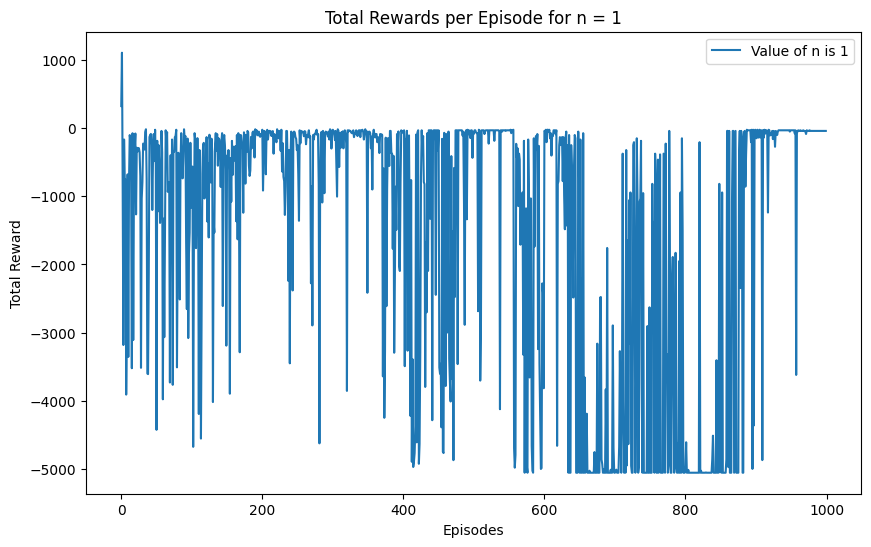

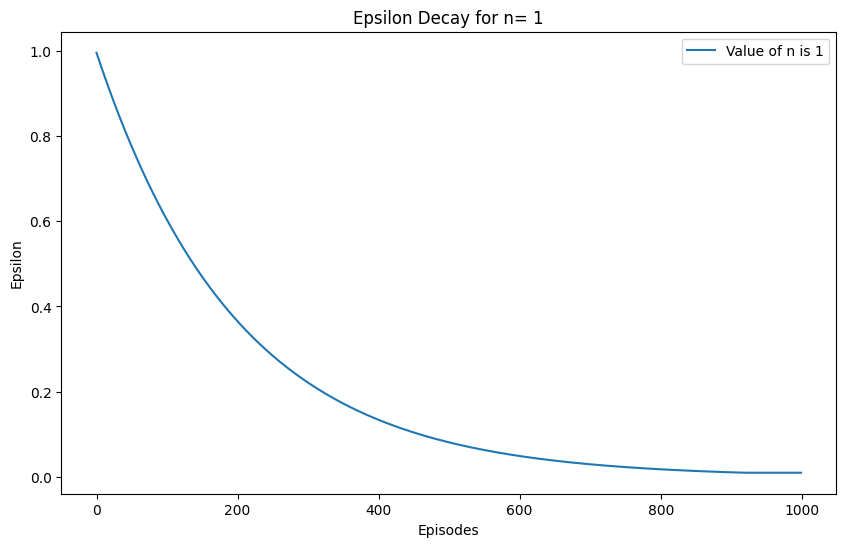

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -45
Action Grid:
↓ . . . . .
↓ . . . . .
↘ . . . . .
. ↓ . . . .
. → → → → ↓
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -45
Action Grid:
↓ . . . . .
↓ . . . . .
↘ . . . . .
. ↓ . . . .
. → → → → ↓
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -45
Action Grid:
↓ . . . . .
↓ . . . . .
↘ . . . . .
. ↓ . . . .
. → → → → ↓
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -45
Action Grid:
↓ . . . . .
↓ . . . . .
↘ . . . . .
. ↓ . . . .
. → → → → ↓
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -45
Action Grid:
↓ . . . . .
↓ . . . . .
↘ . . . . .
. ↓ . . . .
. → → → → ↓
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -45
Action Grid:
↓ . . . . .
↓ . . . . .
↘ . . . . .
. ↓ . . . .
. → → → → ↓
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -45
Action Grid:
↓ . . . . .
↓ . . . . .
↘ . . . . .
. ↓ . . . .
. → → → → ↓
. . . . . .


Greedy Evaluation Episode 8: Tot

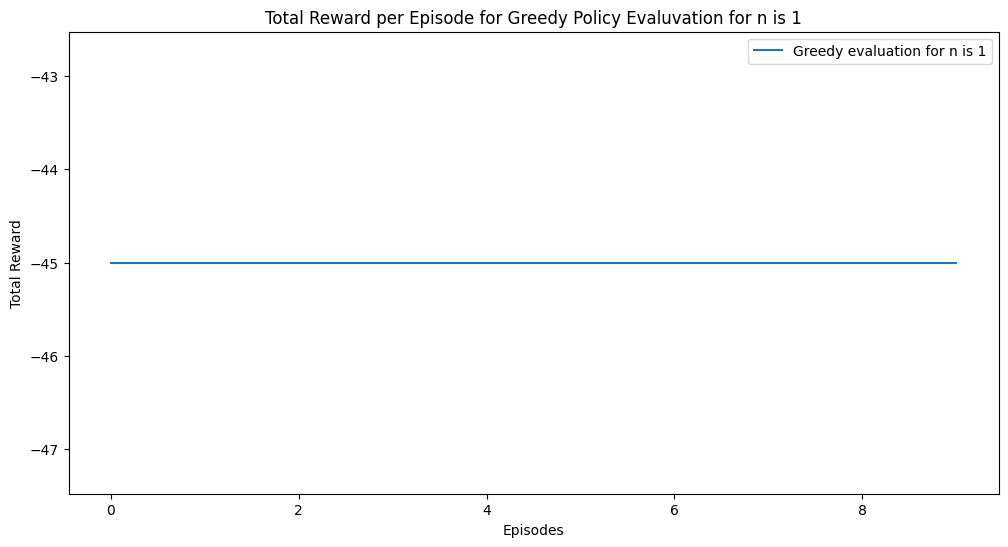

N value is -  2
Episode 100/1000, Total Reward: -45, Epsilon: 0.6058
Episode 200/1000, Total Reward: -685, Epsilon: 0.3670
Episode 300/1000, Total Reward: -820, Epsilon: 0.2223
Episode 400/1000, Total Reward: -199, Epsilon: 0.1347
Episode 500/1000, Total Reward: -1113, Epsilon: 0.0816
Episode 600/1000, Total Reward: -946, Epsilon: 0.0494
Episode 700/1000, Total Reward: -5050, Epsilon: 0.0299
Episode 800/1000, Total Reward: -5007, Epsilon: 0.0181
Episode 900/1000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/1000, Total Reward: -1891, Epsilon: 0.0100
Initial Q1 for n = 2 :
[[-1.00000000e+02  3.00305265e-03  1.45096145e-02 -1.00000000e+02
   3.48274024e-03]
 [-1.00000000e+02  3.91513881e-03  1.25931654e-02  4.18820992e-04
   2.33846860e-03]
 [-1.00000000e+02  6.45815476e-03  1.13062796e-02  5.28820855e-03
   1.54948172e-02]
 [-1.00000000e+02  4.07142585e-03  1.41473275e-02  1.44622293e-02
   1.15360140e-03]
 [-1.00000000e+02  1.11695833e-02  8.49236324e-03  7.47960789e-03
   1.93848

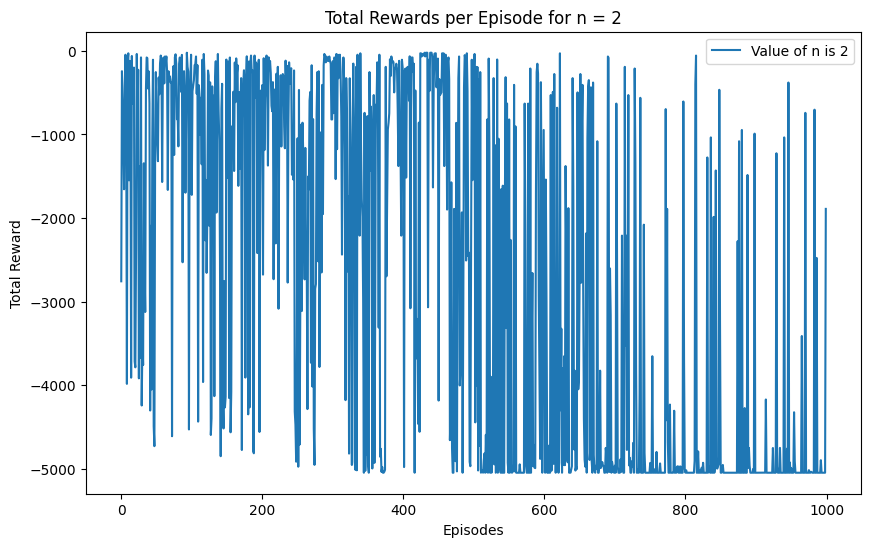

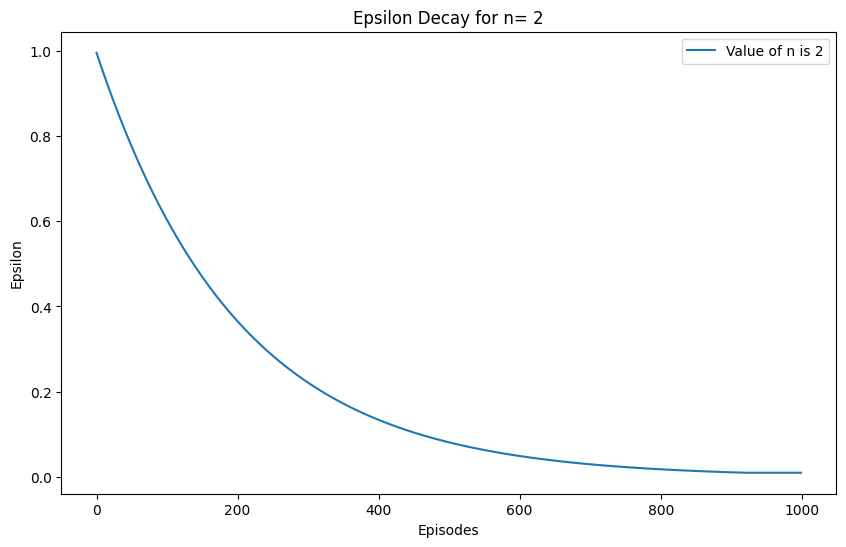

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

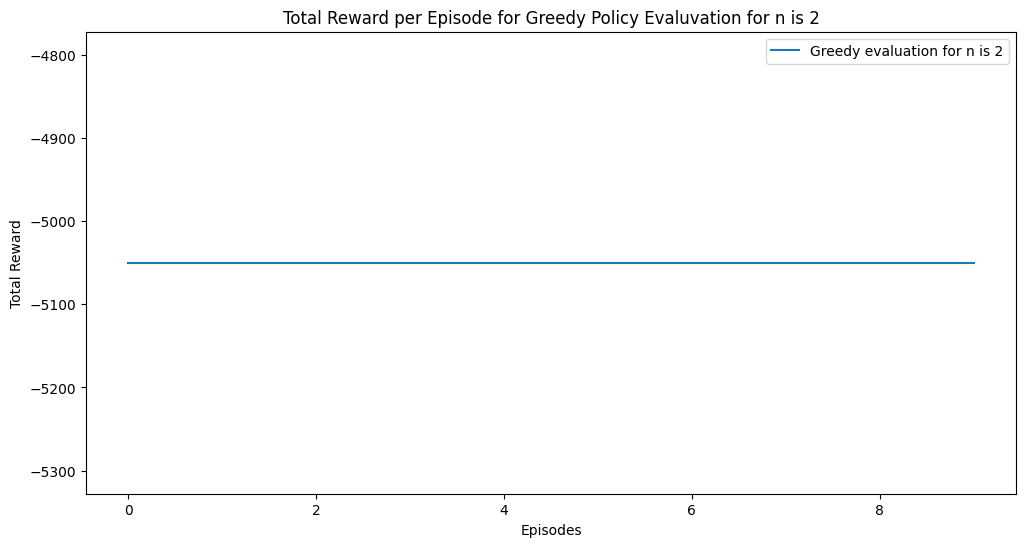

N value is -  3
Episode 100/1000, Total Reward: -889, Epsilon: 0.6058
Episode 200/1000, Total Reward: -904, Epsilon: 0.3670
Episode 300/1000, Total Reward: -167, Epsilon: 0.2223
Episode 400/1000, Total Reward: -1565, Epsilon: 0.1347
Episode 500/1000, Total Reward: -2278, Epsilon: 0.0816
Episode 600/1000, Total Reward: -4991, Epsilon: 0.0494
Episode 700/1000, Total Reward: -66, Epsilon: 0.0299
Episode 800/1000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/1000, Total Reward: -5041, Epsilon: 0.0110
Episode 1000/1000, Total Reward: -4958, Epsilon: 0.0100
Initial Q1 for n = 3 :
[[-1.00000000e+02  7.88069245e-03  1.75636931e-02 -1.00000000e+02
   1.70061926e-02]
 [-1.00000000e+02  1.69203773e-02  6.48222102e-03  9.44355969e-03
   2.05558316e-03]
 [-1.00000000e+02  8.54275990e-04  1.67133315e-02  1.70872643e-02
   1.69090568e-02]
 [-1.00000000e+02  1.95809161e-02  1.76582746e-02  1.19388183e-02
   9.04834690e-03]
 [-1.00000000e+02  1.95409078e-03  2.92524362e-03  1.19509200e-02
   8.3787

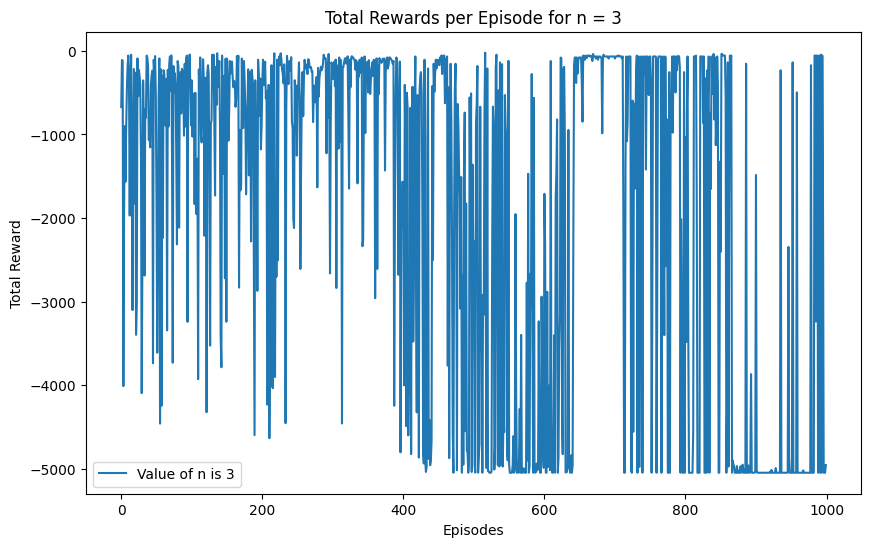

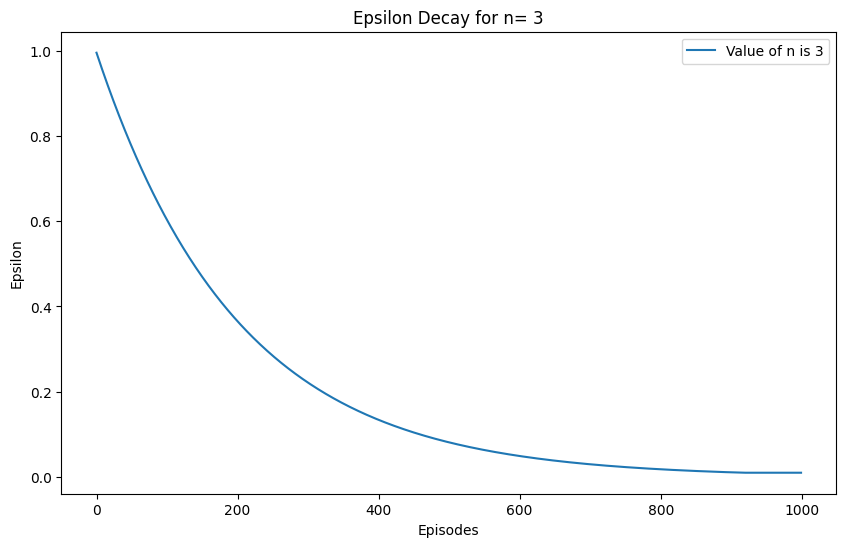

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↘ ↓ . .
. . . ↑ . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↘ ↓ . .
. . . ↑ . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↘ ↓ . .
. . . ↑ . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↘ ↓ . .
. . . ↑ . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↘ ↓ . .
. . . ↑ . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↘ ↓ . .
. . . ↑ . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↘ ↓ . .
. . . ↑ . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

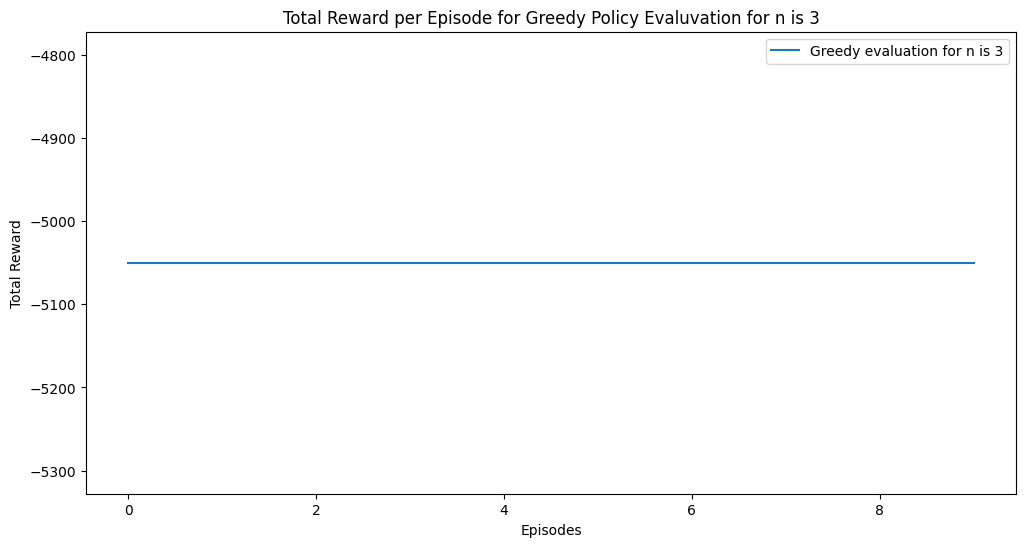

N value is -  4
Episode 100/1000, Total Reward: -234, Epsilon: 0.6058
Episode 200/1000, Total Reward: -621, Epsilon: 0.3670
Episode 300/1000, Total Reward: -2237, Epsilon: 0.2223
Episode 400/1000, Total Reward: -3346, Epsilon: 0.1347
Episode 500/1000, Total Reward: -1068, Epsilon: 0.0816
Episode 600/1000, Total Reward: -5050, Epsilon: 0.0494
Episode 700/1000, Total Reward: -4278, Epsilon: 0.0299
Episode 800/1000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/1000, Total Reward: -4595, Epsilon: 0.0110
Episode 1000/1000, Total Reward: -5050, Epsilon: 0.0100
Initial Q1 for n = 4 :
[[-1.00000000e+02  1.81950204e-02  1.86614657e-04 -1.00000000e+02
   4.16400415e-03]
 [-1.00000000e+02  1.58582014e-02  1.32457682e-03  1.13180077e-03
   2.20972614e-03]
 [-1.00000000e+02  8.04752467e-03  1.97129128e-03  1.03464224e-02
   1.01323778e-02]
 [-1.00000000e+02  1.94908895e-02  8.76801944e-03  1.67821822e-02
   4.02498236e-03]
 [-1.00000000e+02  1.27761842e-02  3.62869037e-03  4.59200405e-03
   1.1

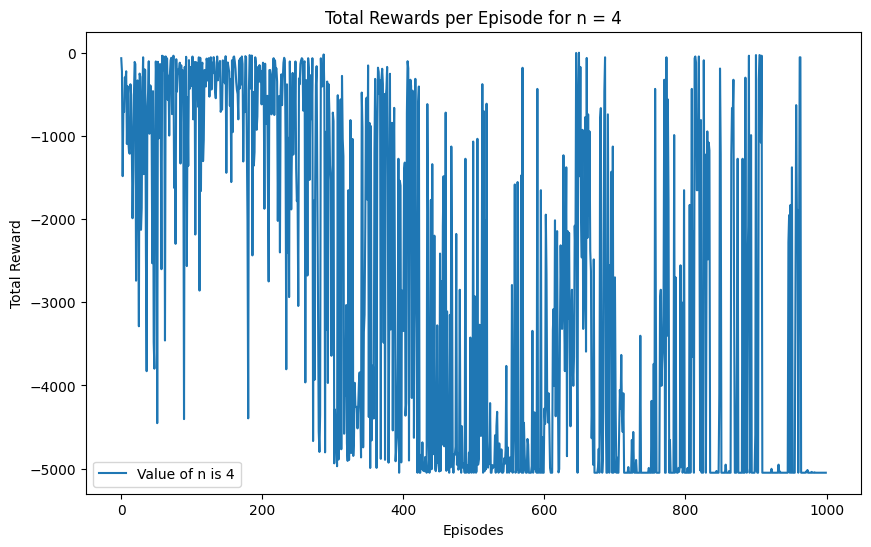

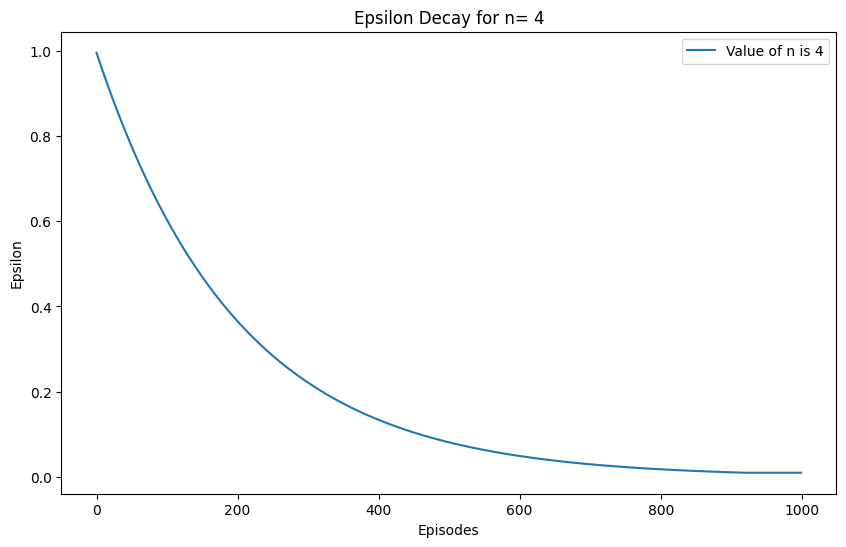

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ← . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ← . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ← . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ← . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ← . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ← . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ← . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

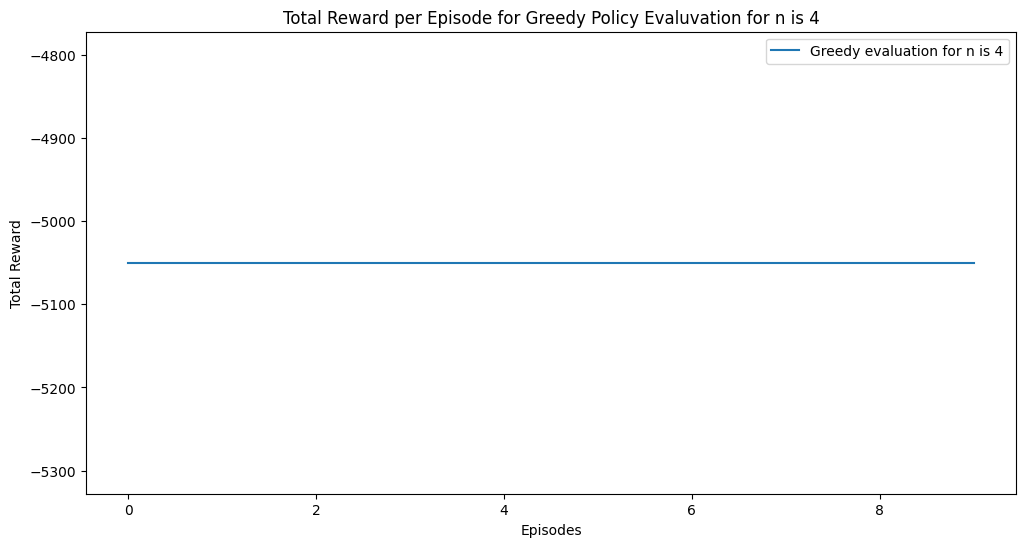

N value is -  5
Episode 100/1000, Total Reward: -148, Epsilon: 0.6058
Episode 200/1000, Total Reward: -659, Epsilon: 0.3670
Episode 300/1000, Total Reward: -1038, Epsilon: 0.2223
Episode 400/1000, Total Reward: -3159, Epsilon: 0.1347
Episode 500/1000, Total Reward: -1024, Epsilon: 0.0816
Episode 600/1000, Total Reward: -4967, Epsilon: 0.0494
Episode 700/1000, Total Reward: -5050, Epsilon: 0.0299
Episode 800/1000, Total Reward: -3403, Epsilon: 0.0181
Episode 900/1000, Total Reward: -1225, Epsilon: 0.0110
Episode 1000/1000, Total Reward: -45, Epsilon: 0.0100
Initial Q1 for n = 5 :
[[-1.00000000e+02  1.13451979e-02  2.87009674e-03 -1.00000000e+02
   9.83728754e-03]
 [-1.00000000e+02  1.71012710e-02  2.40437319e-03  1.42547699e-02
   6.41083215e-03]
 [-1.00000000e+02  9.63300896e-03  1.20104501e-02  3.78705144e-03
   2.78354874e-03]
 [-1.00000000e+02  4.89634760e-03  1.40474112e-02  2.51211110e-03
   1.15751622e-03]
 [-1.00000000e+02  6.83724282e-03  1.77308767e-02  1.17383512e-02
   8.792

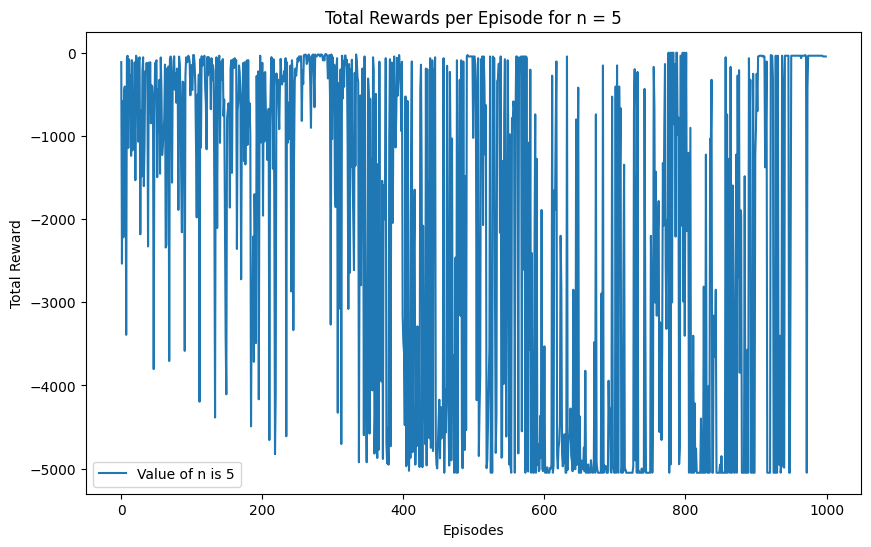

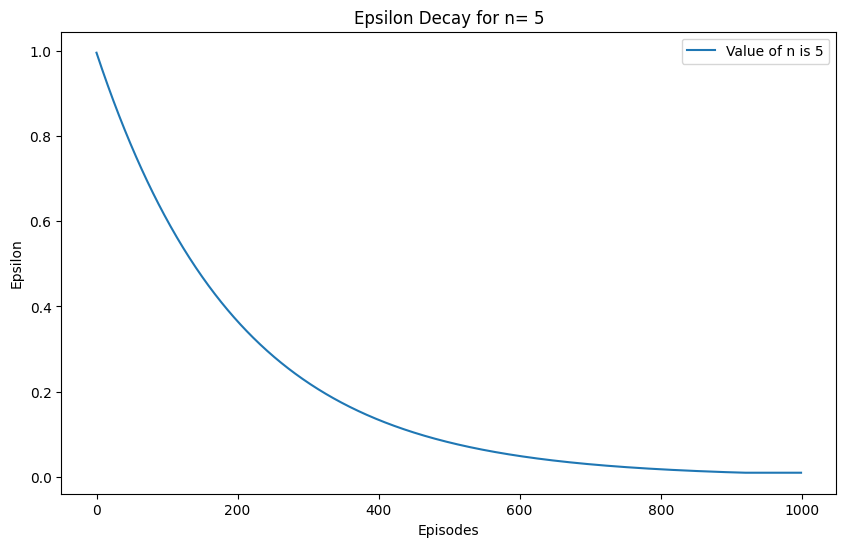

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -45
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 2: Total Reward = -45
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 3: Total Reward = -45
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 4: Total Reward = -45
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 5: Total Reward = -45
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 6: Total Reward = -45
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 7: Total Reward = -45
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 8: Tot

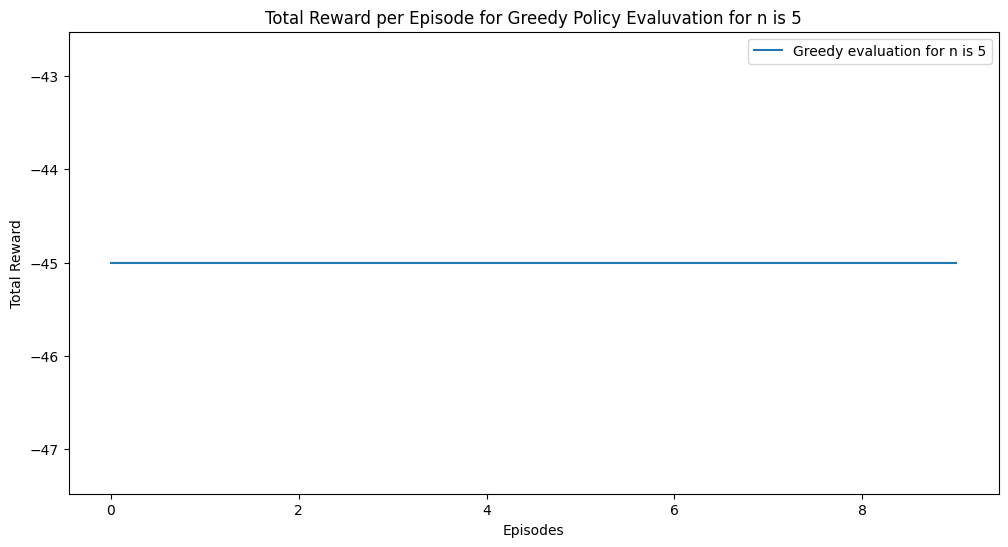

In [10]:
env = GridWorld()
discount = 1
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 1000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 1 - Number of episodes - Attempt 1

N value is -  1
Episode 100/500, Total Reward: -3998, Epsilon: 0.6058
Episode 200/500, Total Reward: -82, Epsilon: 0.3670
Episode 300/500, Total Reward: -426, Epsilon: 0.2223
Episode 400/500, Total Reward: -210, Epsilon: 0.1347
Episode 500/500, Total Reward: -28, Epsilon: 0.0816
Initial Q1 for n = 1 :
[[-1.00000000e+02  1.49691678e-02  7.30821688e-03 -1.00000000e+02
   4.47357120e-03]
 [-1.00000000e+02  1.87997279e-02  9.41546456e-03  3.64068531e-03
   1.26195334e-02]
 [-1.00000000e+02  1.74785697e-02  1.30007498e-02  8.10450059e-03
   1.09912755e-02]
 [-1.00000000e+02  1.71713009e-02  1.32160573e-02  3.84799052e-03
   9.77888574e-03]
 [-1.00000000e+02  3.79648504e-03  3.86426890e-03  1.59102228e-02
   5.09654968e-03]
 [-1.00000000e+02  9.64495449e-03 -1.00000000e+02  1.56137795e-02
   1.77910821e-02]
 [ 6.04212423e-03  1.43563992e-02  1.74173654e-02 -1.00000000e+02
   1.45214125e-02]
 [ 1.22255678e-03  1.67374298e-02  1.43974904e-02  7.41649636e-03
   1.63340955e-02]
 [ 1.64259154e-02

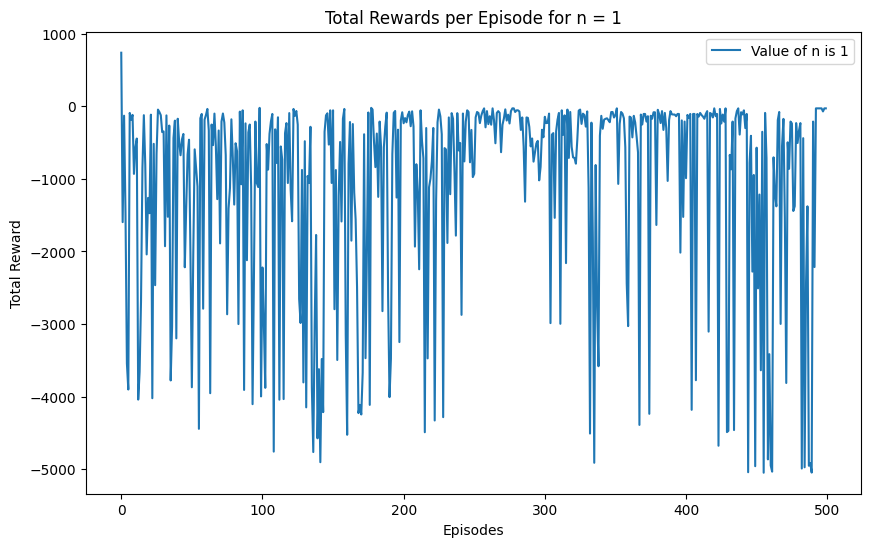

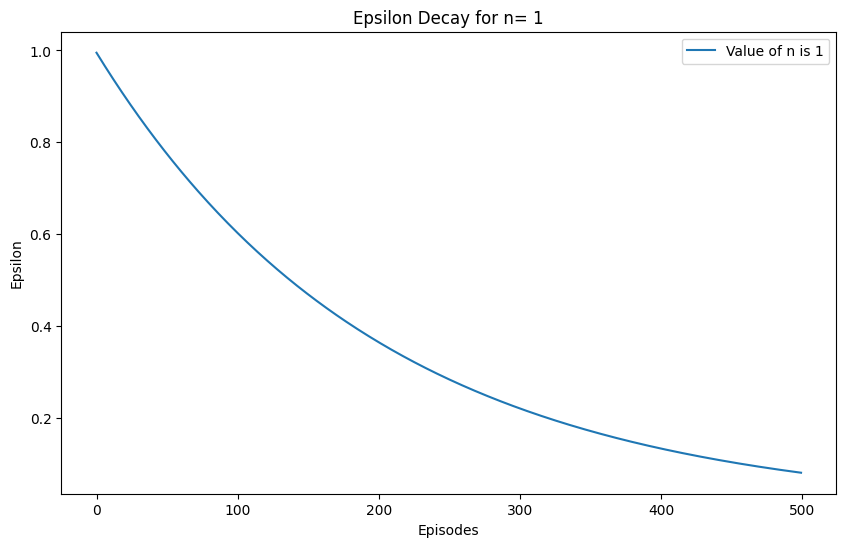

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 8: Tot

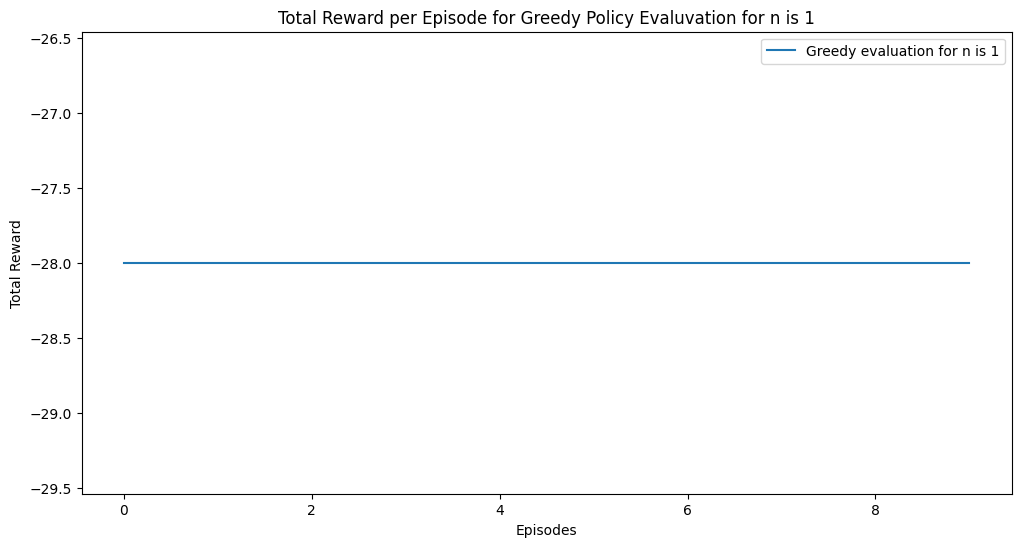

N value is -  2
Episode 100/500, Total Reward: -386, Epsilon: 0.6058
Episode 200/500, Total Reward: -4719, Epsilon: 0.3670
Episode 300/500, Total Reward: -210, Epsilon: 0.2223
Episode 400/500, Total Reward: -406, Epsilon: 0.1347
Episode 500/500, Total Reward: -932, Epsilon: 0.0816
Initial Q1 for n = 2 :
[[-1.00000000e+02  4.99973898e-03  1.81584207e-02 -1.00000000e+02
   3.18737268e-03]
 [-1.00000000e+02  2.42807321e-03  1.14553029e-02  1.90390498e-02
   1.88276064e-02]
 [-1.00000000e+02  1.25769310e-02  6.28174487e-04  4.07561408e-03
   1.08465421e-02]
 [-1.00000000e+02  1.27488857e-02  1.34099101e-02  1.55298996e-02
   1.26617765e-02]
 [-1.00000000e+02  1.94210432e-02  1.82655447e-04  7.72078726e-03
   1.96929732e-02]
 [-1.00000000e+02  1.31388992e-02 -1.00000000e+02  1.66926803e-02
   3.26752024e-03]
 [ 2.11223589e-03  4.69138464e-03  3.74463209e-03 -1.00000000e+02
   1.15709329e-02]
 [ 6.34733417e-03  1.32227149e-02  6.04460622e-03  4.18880134e-03
   7.08039559e-03]
 [ 1.04539142e-

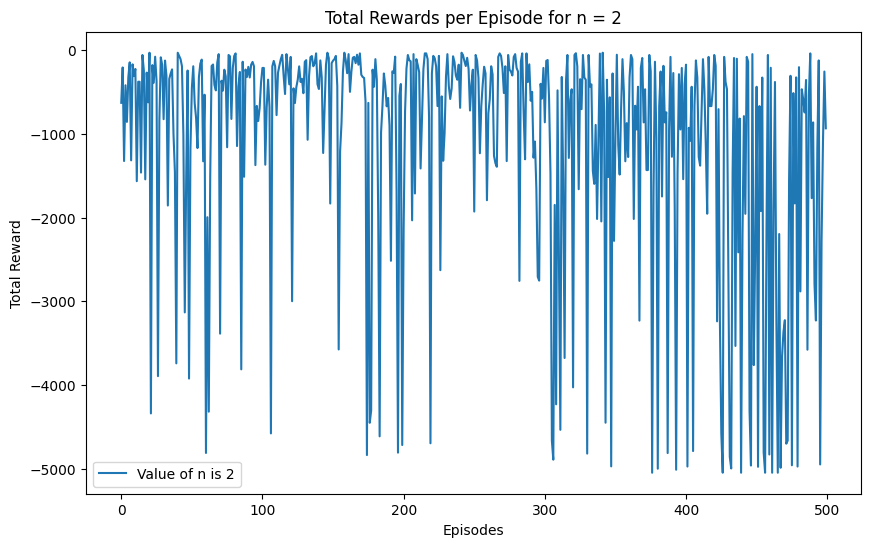

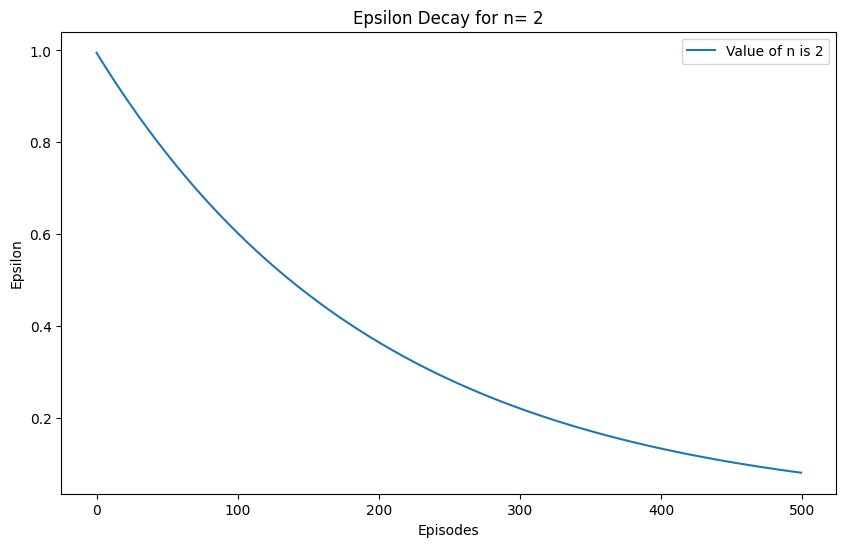

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ . . ↓ . .
↘ . → ↑ . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ . . ↓ . .
↘ . → ↑ . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ . . ↓ . .
↘ . → ↑ . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ . . ↓ . .
↘ . → ↑ . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ . . ↓ . .
↘ . → ↑ . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ . . ↓ . .
↘ . → ↑ . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ . . ↓ . .
↘ . → ↑ . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

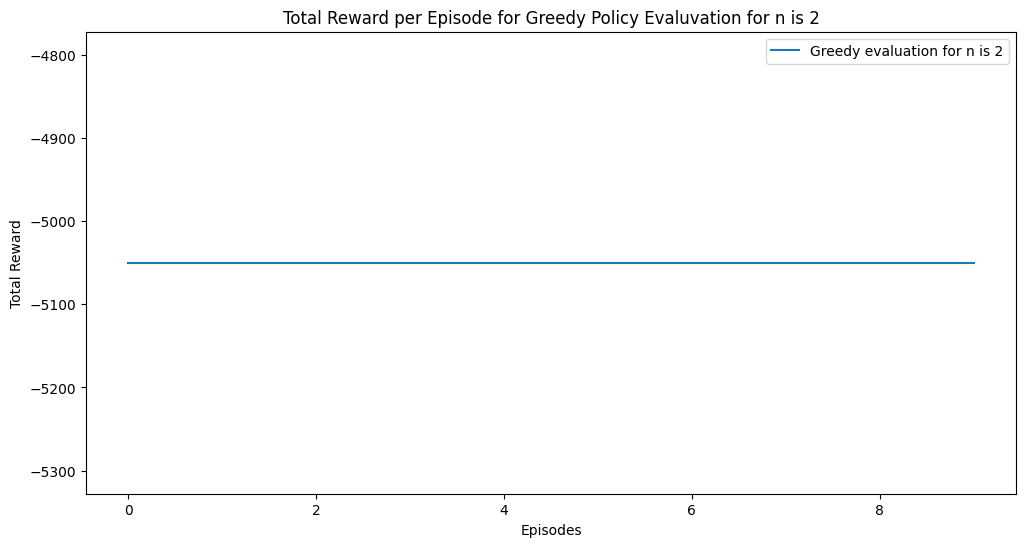

N value is -  3
Episode 100/500, Total Reward: -105, Epsilon: 0.6058
Episode 200/500, Total Reward: -1231, Epsilon: 0.3670
Episode 300/500, Total Reward: -55, Epsilon: 0.2223
Episode 400/500, Total Reward: -253, Epsilon: 0.1347
Episode 500/500, Total Reward: -300, Epsilon: 0.0816
Initial Q1 for n = 3 :
[[-1.00000000e+02  5.93955193e-03  4.93176168e-03 -1.00000000e+02
   1.59196580e-02]
 [-1.00000000e+02  1.47925110e-02  1.57654722e-02  1.29412331e-02
   1.96007232e-02]
 [-1.00000000e+02  2.34895645e-03  8.62189589e-03  2.36228935e-03
   5.52479543e-03]
 [-1.00000000e+02  1.27383777e-03  8.30515101e-03  6.44161392e-03
   1.30950247e-02]
 [-1.00000000e+02  3.74375544e-03  7.02475598e-03  8.92300133e-03
   1.43238395e-02]
 [-1.00000000e+02  8.14018845e-03 -1.00000000e+02  2.80425337e-03
   2.70234040e-03]
 [ 1.60948926e-02  5.51664358e-03  6.19666438e-03 -1.00000000e+02
   2.25633886e-03]
 [ 4.37936502e-03  1.61285195e-02  6.22777370e-03  1.47743809e-02
   1.47658783e-02]
 [ 1.62624095e-0

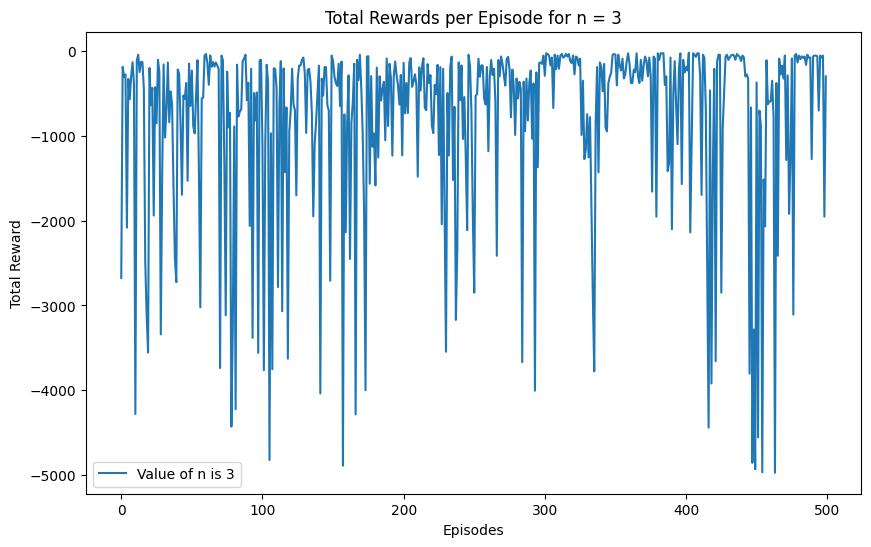

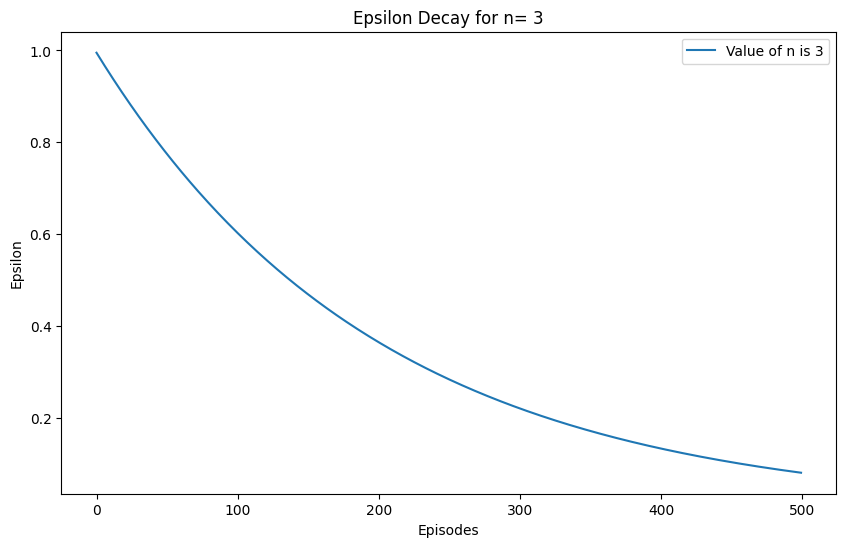

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ ↘ . . . .
→ ↑ → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↑ .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ ↘ . . . .
→ ↑ → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↑ .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ ↘ . . . .
→ ↑ → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↑ .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ ↘ . . . .
→ ↑ → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↑ .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ ↘ . . . .
→ ↑ → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↑ .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ ↘ . . . .
→ ↑ → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↑ .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ ↘ . . . .
→ ↑ → ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . ↑ .
. . . . . .


Greedy Evaluation 

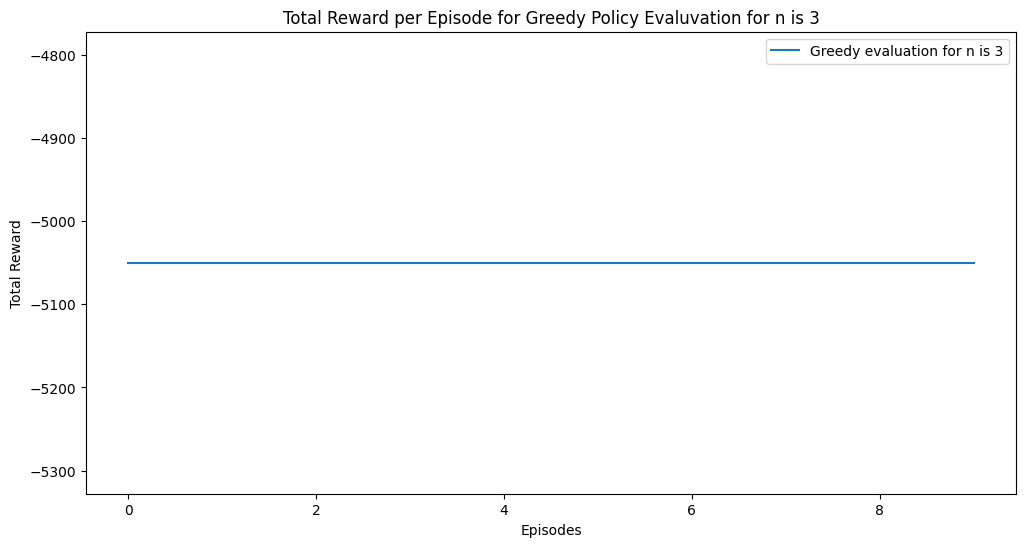

N value is -  4
Episode 100/500, Total Reward: -78, Epsilon: 0.6058
Episode 200/500, Total Reward: -100, Epsilon: 0.3670
Episode 300/500, Total Reward: -4253, Epsilon: 0.2223
Episode 400/500, Total Reward: -1847, Epsilon: 0.1347
Episode 500/500, Total Reward: -528, Epsilon: 0.0816
Initial Q1 for n = 4 :
[[-1.00000000e+02  1.68499580e-02  1.64703001e-02 -1.00000000e+02
   3.94517305e-03]
 [-1.00000000e+02  1.04048406e-02  1.94092755e-02  1.52082800e-02
   1.57130463e-02]
 [-1.00000000e+02  9.19949468e-03  1.88936224e-02  1.02729454e-03
   3.64130880e-03]
 [-1.00000000e+02  1.07458889e-02  2.37656162e-03  1.53387949e-03
   1.23507016e-03]
 [-1.00000000e+02  7.76897099e-04  6.94481234e-03  1.84232613e-02
   3.82239159e-03]
 [-1.00000000e+02  2.62170869e-04 -1.00000000e+02  1.99518063e-02
   1.14937955e-02]
 [ 2.71908643e-03  1.10871646e-02  2.89114692e-03 -1.00000000e+02
   1.45938830e-02]
 [ 3.12948573e-03  5.74911441e-03  4.70679765e-03  8.37466136e-03
   1.31309358e-02]
 [ 8.84321893e-

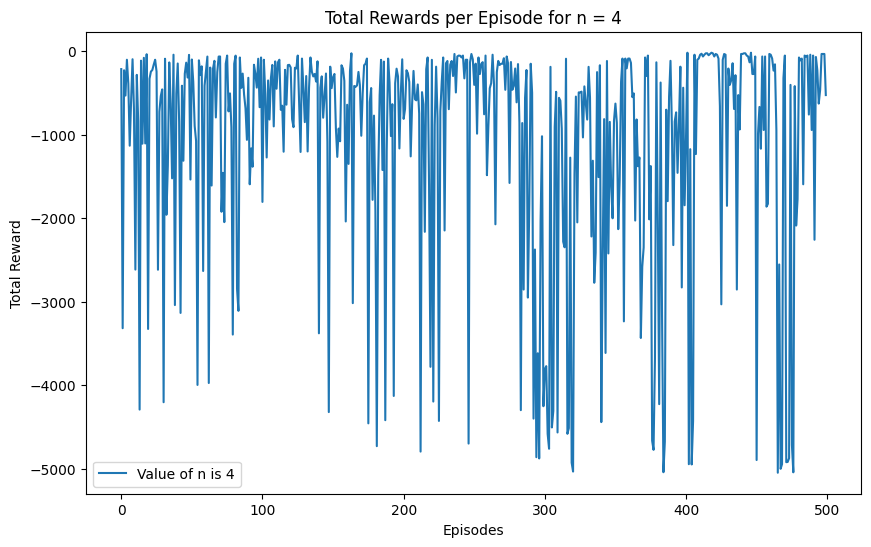

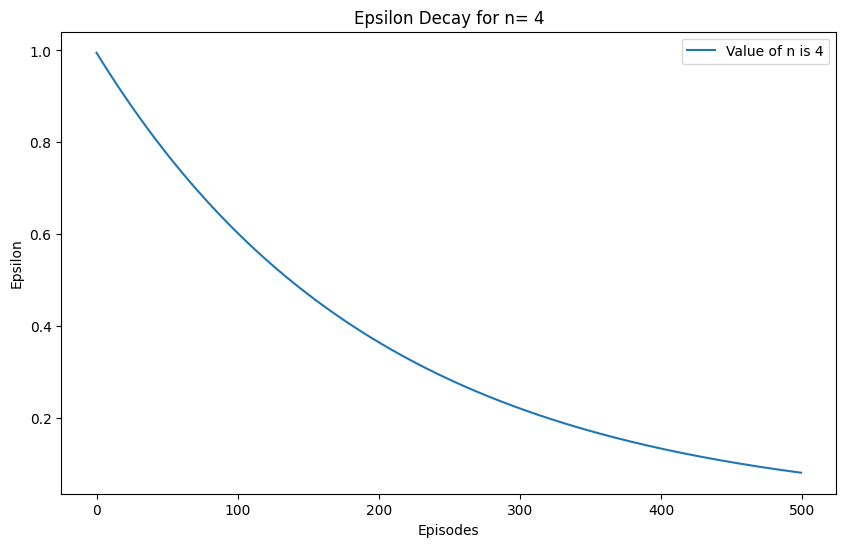

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -36
Action Grid:
→ ↓ . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 2: Total Reward = -36
Action Grid:
→ ↓ . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 3: Total Reward = -36
Action Grid:
→ ↓ . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 4: Total Reward = -36
Action Grid:
→ ↓ . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 5: Total Reward = -36
Action Grid:
→ ↓ . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 6: Total Reward = -36
Action Grid:
→ ↓ . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 7: Total Reward = -36
Action Grid:
→ ↓ . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 8: Tot

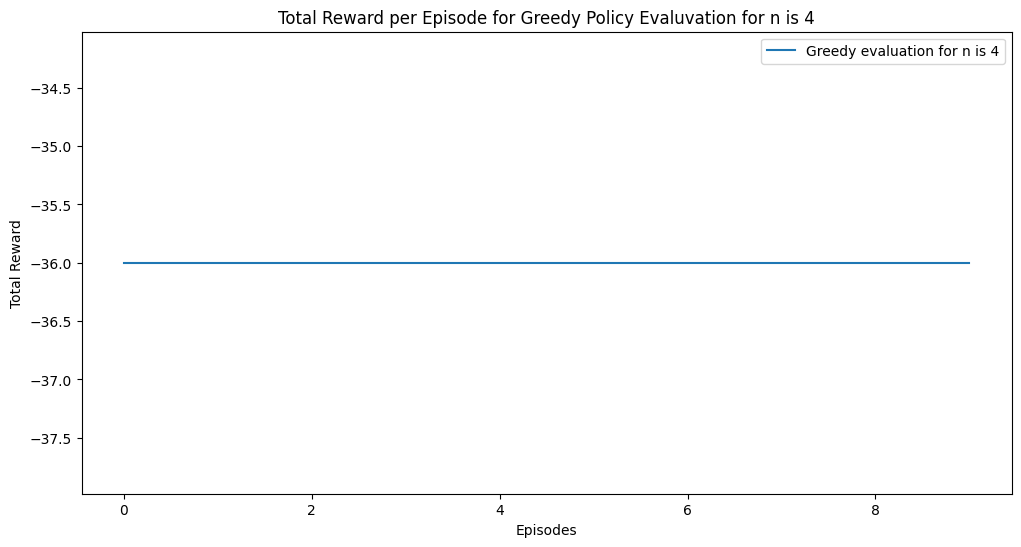

N value is -  5
Episode 100/500, Total Reward: -82, Epsilon: 0.6058
Episode 200/500, Total Reward: -692, Epsilon: 0.3670
Episode 300/500, Total Reward: -1226, Epsilon: 0.2223
Episode 400/500, Total Reward: -45, Epsilon: 0.1347
Episode 500/500, Total Reward: -5050, Epsilon: 0.0816
Initial Q1 for n = 5 :
[[-1.00000000e+02  1.98576213e-02  1.40746775e-02 -1.00000000e+02
   6.80348842e-03]
 [-1.00000000e+02  1.52603665e-02  2.08728283e-03  1.17501861e-02
   9.35687444e-03]
 [-1.00000000e+02  3.28628723e-03  8.85292711e-03  3.73485209e-03
   1.55495982e-02]
 [-1.00000000e+02  1.72295847e-02  2.99991046e-03  9.67097294e-03
   8.61372791e-03]
 [-1.00000000e+02  1.30355442e-02  1.96067220e-02  2.23911157e-03
   6.74960690e-03]
 [-1.00000000e+02  1.83641364e-02 -1.00000000e+02  1.20722016e-02
   9.56704548e-03]
 [ 8.38776993e-04  6.50745928e-03  1.94787167e-02 -1.00000000e+02
   1.93646043e-02]
 [ 5.83009877e-03  1.49584894e-02  8.96819491e-03  1.37823595e-02
   5.98334127e-03]
 [ 1.84875923e-0

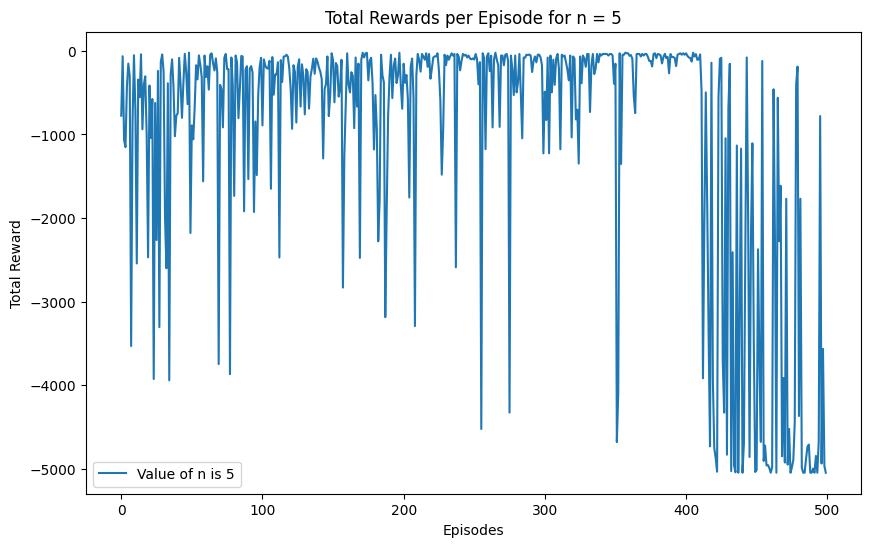

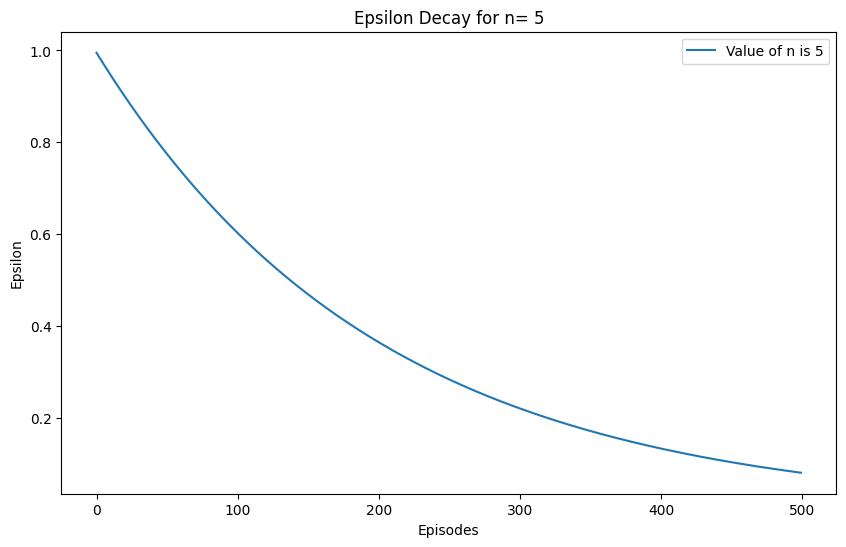

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . → ← . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . → ← . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . → ← . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . → ← . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . → ← . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . → ← . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . → ← . .
. → ↑ . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

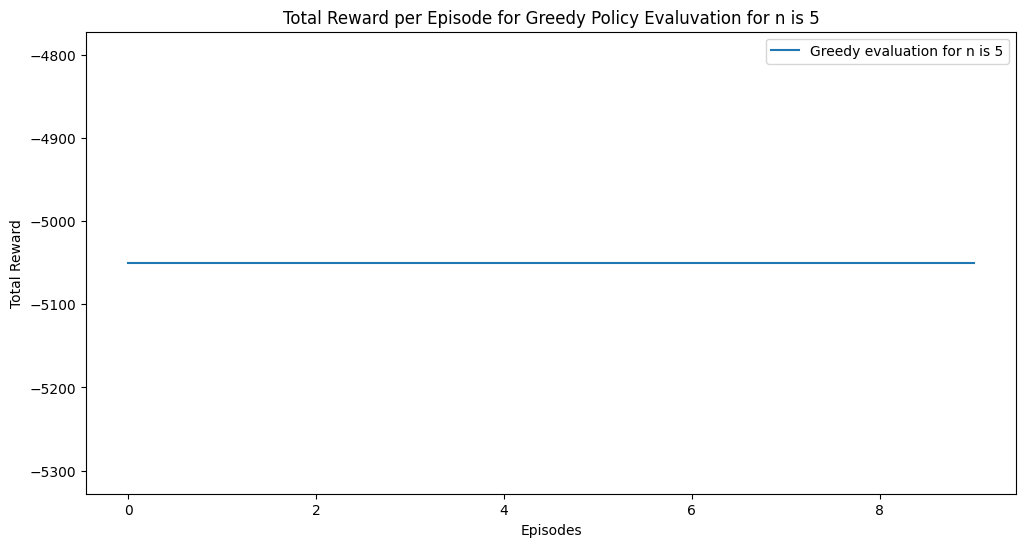

In [13]:
env = GridWorld()
discount = 1
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 500
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 1 - Number of episodes - Attempt 2

N value is -  1
Episode 100/2000, Total Reward: -153, Epsilon: 0.6058
Episode 200/2000, Total Reward: -969, Epsilon: 0.3670
Episode 300/2000, Total Reward: -45, Epsilon: 0.2223
Episode 400/2000, Total Reward: -1431, Epsilon: 0.1347
Episode 500/2000, Total Reward: -36, Epsilon: 0.0816
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0494
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -55, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5040, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.01

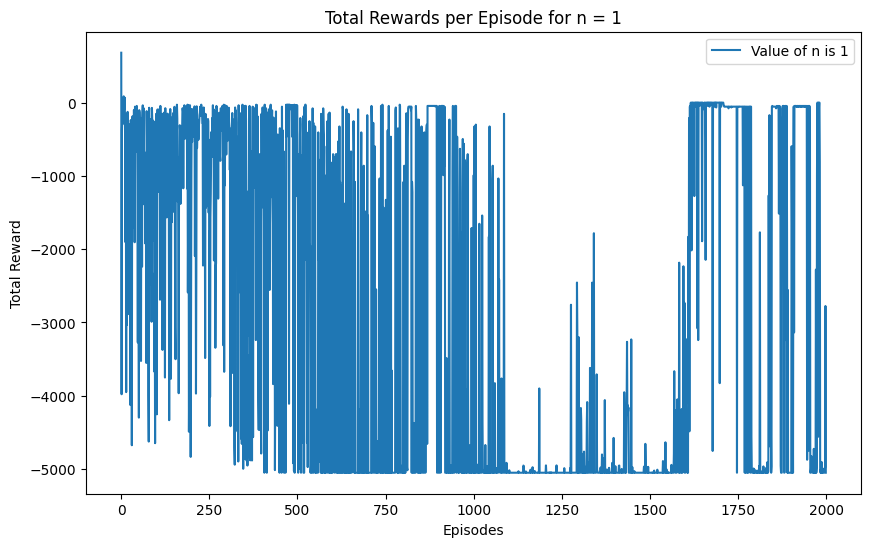

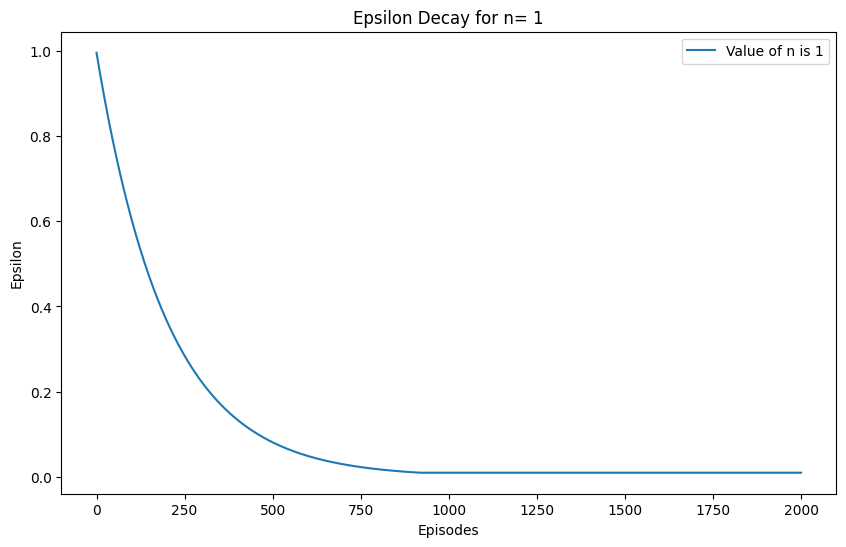

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ → → ↘ . .
. ↑ . . ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ → → ↘ . .
. ↑ . . ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ → → ↘ . .
. ↑ . . ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ → → ↘ . .
. ↑ . . ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ → → ↘ . .
. ↑ . . ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ → → ↘ . .
. ↑ . . ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ → → ↘ . .
. ↑ . . ↓ .
. . . . ↓ .
. . . . ↓ .
. . . . → ←
. . . . . .


Greedy Evaluation 

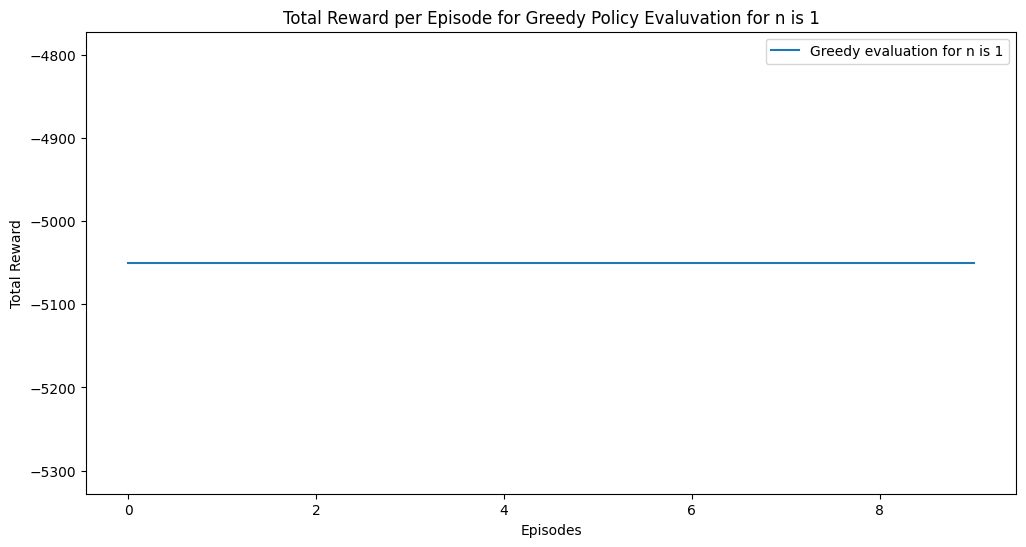

N value is -  2
Episode 100/2000, Total Reward: -3960, Epsilon: 0.6058
Episode 200/2000, Total Reward: -374, Epsilon: 0.3670
Episode 300/2000, Total Reward: -4744, Epsilon: 0.2223
Episode 400/2000, Total Reward: -5050, Epsilon: 0.1347
Episode 500/2000, Total Reward: -66, Epsilon: 0.0816
Episode 600/2000, Total Reward: -45, Epsilon: 0.0494
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -2211, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -1711, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -435, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon

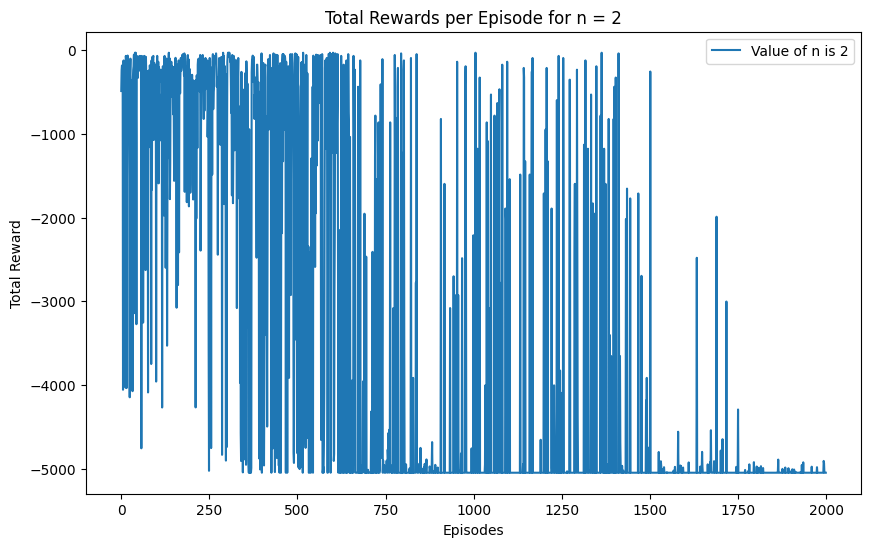

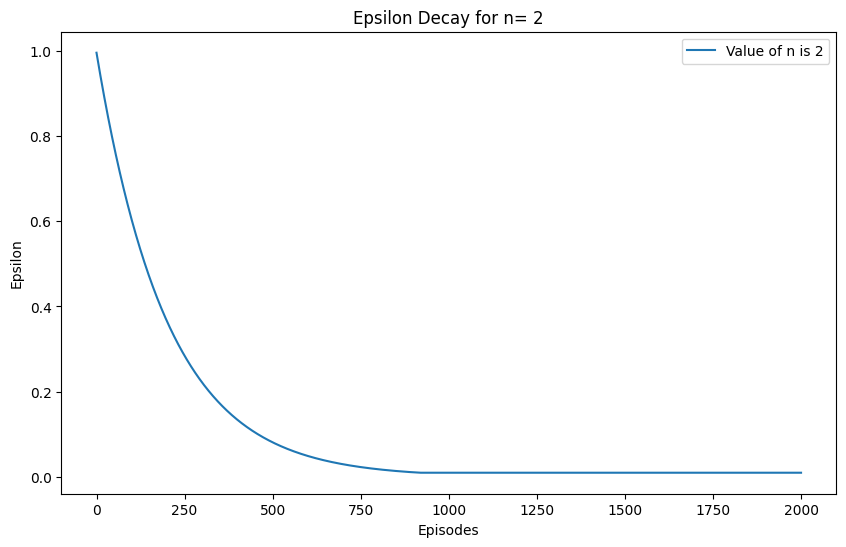

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . ↓
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . ↓
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . ↓
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . ↓
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . ↓
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . ↓
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . ↓
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

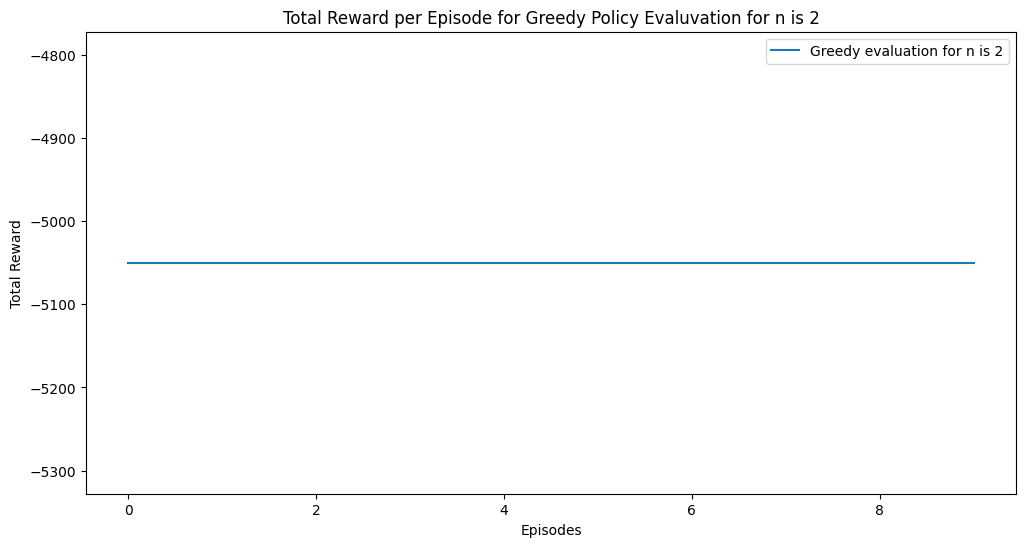

N value is -  3
Episode 100/2000, Total Reward: -153, Epsilon: 0.6058
Episode 200/2000, Total Reward: -673, Epsilon: 0.3670
Episode 300/2000, Total Reward: -470, Epsilon: 0.2223
Episode 400/2000, Total Reward: -28, Epsilon: 0.1347
Episode 500/2000, Total Reward: -4889, Epsilon: 0.0816
Episode 600/2000, Total Reward: -66, Epsilon: 0.0494
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0299
Episode 800/2000, Total Reward: -990, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -231, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -55, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -4831, Epsilon: 0.0100
Ep

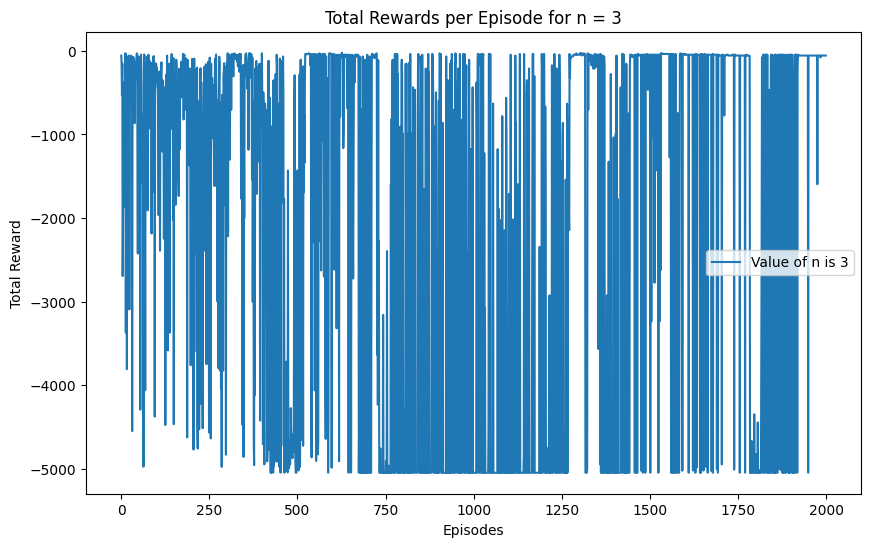

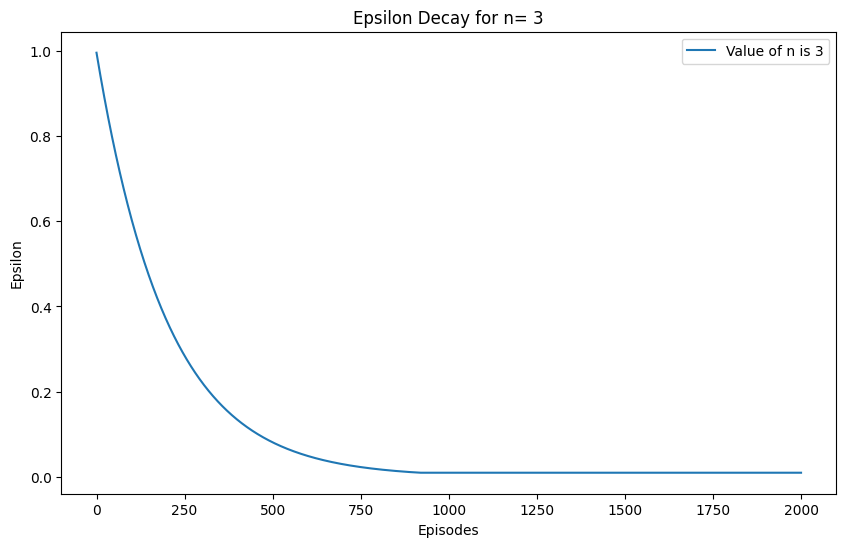

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -55
Action Grid:
→ ↓ . . . .
. ↓ . . . .
. ↓ . . . .
. → → → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 2: Total Reward = -55
Action Grid:
→ ↓ . . . .
. ↓ . . . .
. ↓ . . . .
. → → → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 3: Total Reward = -55
Action Grid:
→ ↓ . . . .
. ↓ . . . .
. ↓ . . . .
. → → → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 4: Total Reward = -55
Action Grid:
→ ↓ . . . .
. ↓ . . . .
. ↓ . . . .
. → → → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 5: Total Reward = -55
Action Grid:
→ ↓ . . . .
. ↓ . . . .
. ↓ . . . .
. → → → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 6: Total Reward = -55
Action Grid:
→ ↓ . . . .
. ↓ . . . .
. ↓ . . . .
. → → → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 7: Total Reward = -55
Action Grid:
→ ↓ . . . .
. ↓ . . . .
. ↓ . . . .
. → → → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 8: Tot

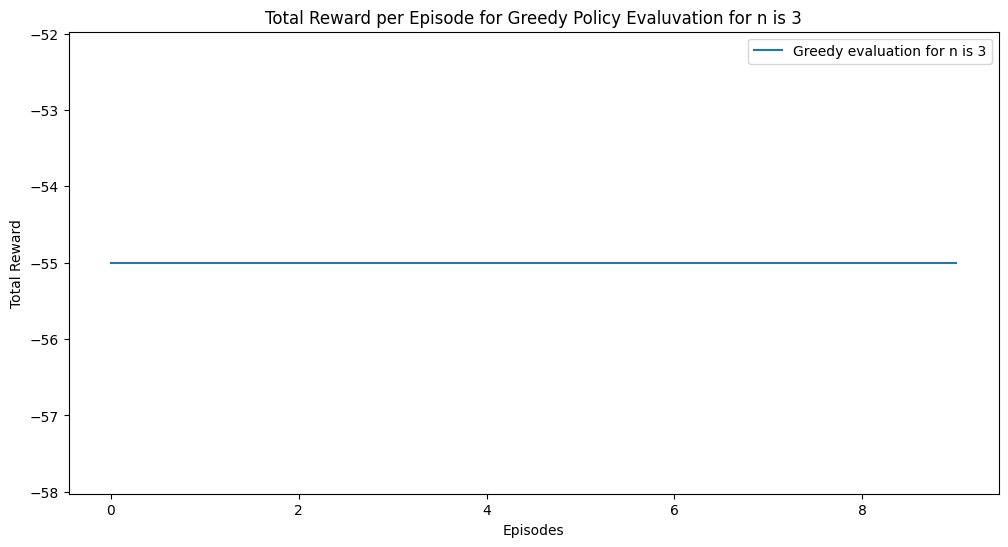

N value is -  4
Episode 100/2000, Total Reward: -171, Epsilon: 0.6058
Episode 200/2000, Total Reward: -28, Epsilon: 0.3670
Episode 300/2000, Total Reward: -2138, Epsilon: 0.2223
Episode 400/2000, Total Reward: -94, Epsilon: 0.1347
Episode 500/2000, Total Reward: -15, Epsilon: 0.0816
Episode 600/2000, Total Reward: -15, Epsilon: 0.0494
Episode 700/2000, Total Reward: -2193, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -4973, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -4998, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -4761, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5022, Epsilon: 0

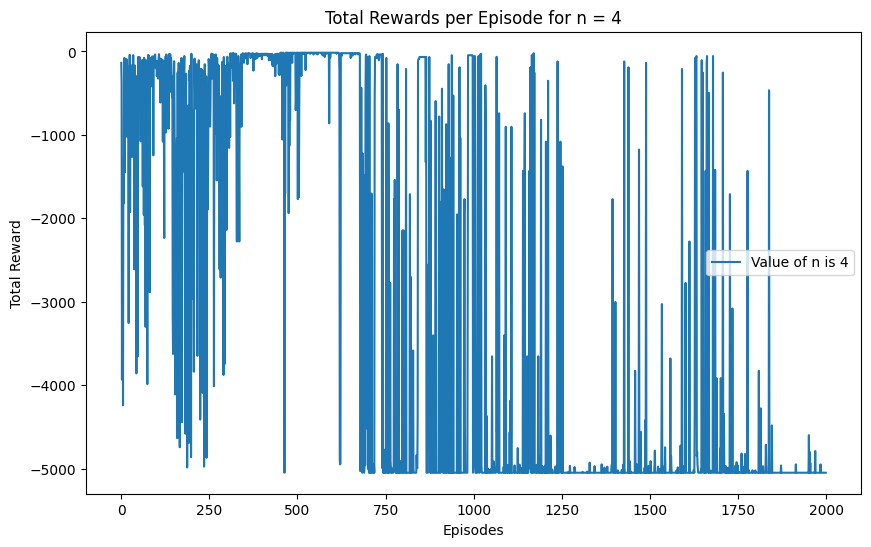

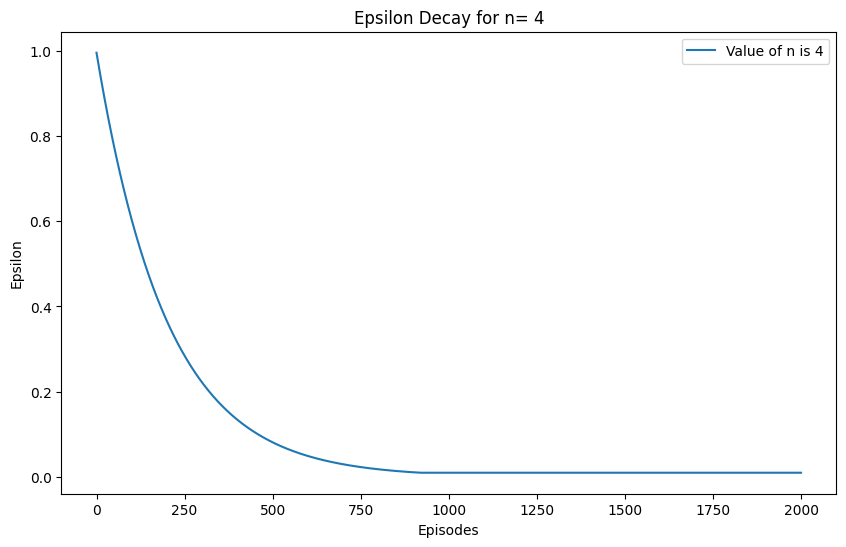

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
→ ↘ → ↓ . .
. . ↑ ← . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
→ ↘ → ↓ . .
. . ↑ ← . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
→ ↘ → ↓ . .
. . ↑ ← . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
→ ↘ → ↓ . .
. . ↑ ← . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
→ ↘ → ↓ . .
. . ↑ ← . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
→ ↘ → ↓ . .
. . ↑ ← . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
→ ↘ → ↓ . .
. . ↑ ← . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

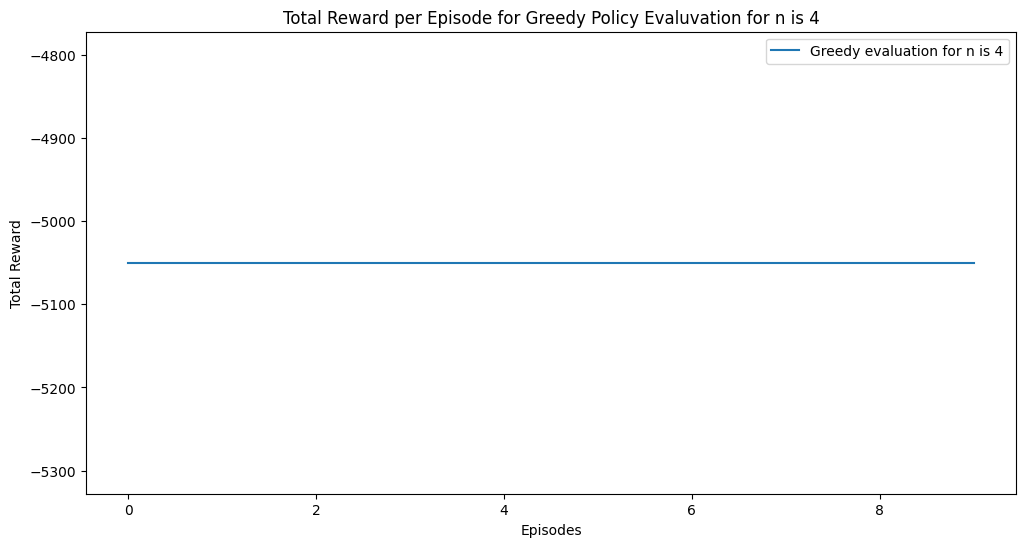

N value is -  5
Episode 100/2000, Total Reward: -89, Epsilon: 0.6058
Episode 200/2000, Total Reward: -78, Epsilon: 0.3670
Episode 300/2000, Total Reward: -164, Epsilon: 0.2223
Episode 400/2000, Total Reward: -36, Epsilon: 0.1347
Episode 500/2000, Total Reward: -276, Epsilon: 0.0816
Episode 600/2000, Total Reward: -2346, Epsilon: 0.0494
Episode 700/2000, Total Reward: -4988, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -1326, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -15, Epsilon: 0.0100
Episode 190

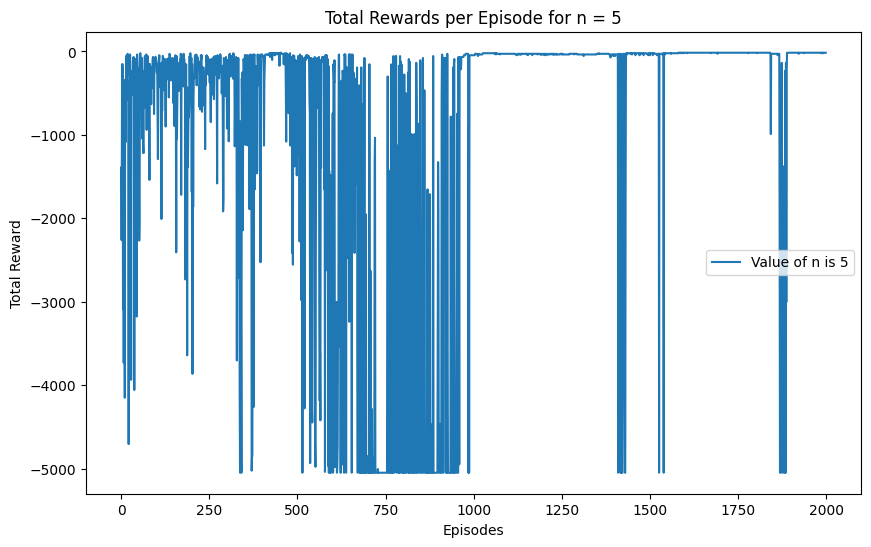

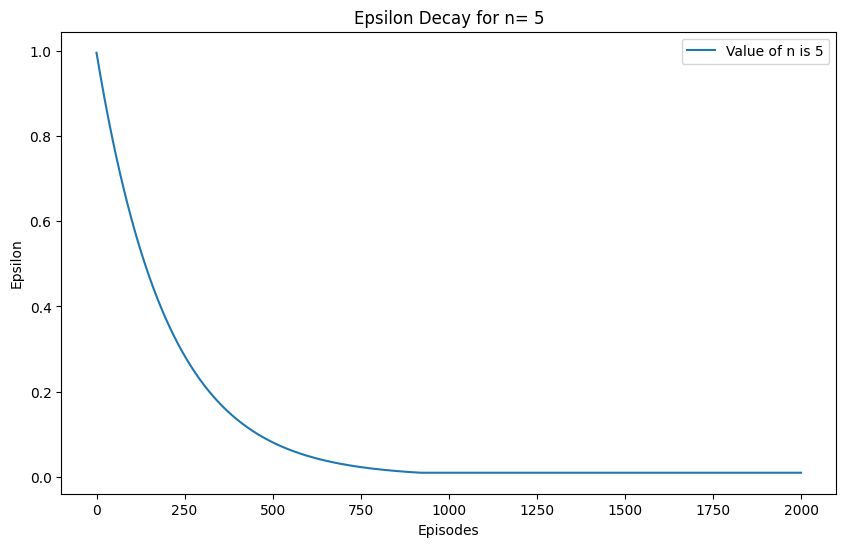

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 8: Tot

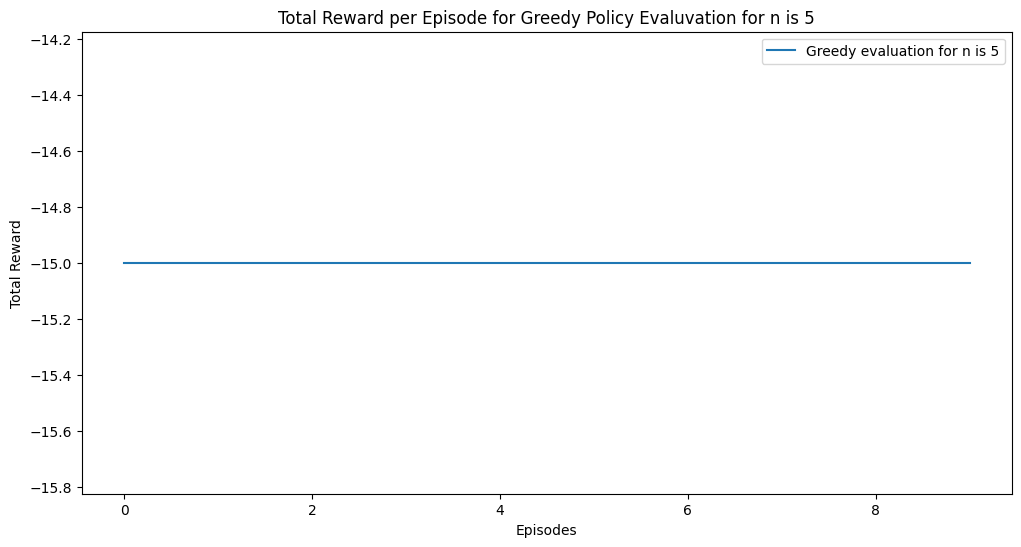

In [14]:
env = GridWorld()
discount = 1
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 2000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 1 - Number of episodes - Attempt 3

N value is -  1
Episode 100/3000, Total Reward: -355, Epsilon: 0.6058
Episode 200/3000, Total Reward: -1058, Epsilon: 0.3670
Episode 300/3000, Total Reward: -136, Epsilon: 0.2223
Episode 400/3000, Total Reward: -3943, Epsilon: 0.1347
Episode 500/3000, Total Reward: -703, Epsilon: 0.0816
Episode 600/3000, Total Reward: -4964, Epsilon: 0.0494
Episode 700/3000, Total Reward: -66, Epsilon: 0.0299
Episode 800/3000, Total Reward: -66, Epsilon: 0.0181
Episode 900/3000, Total Reward: -55, Epsilon: 0.0110
Episode 1000/3000, Total Reward: -45, Epsilon: 0.0100
Episode 1100/3000, Total Reward: -45, Epsilon: 0.0100
Episode 1200/3000, Total Reward: -66, Epsilon: 0.0100
Episode 1300/3000, Total Reward: -66, Epsilon: 0.0100
Episode 1400/3000, Total Reward: -45, Epsilon: 0.0100
Episode 1500/3000, Total Reward: -45, Epsilon: 0.0100
Episode 1600/3000, Total Reward: -5000, Epsilon: 0.0100
Episode 1700/3000, Total Reward: -45, Epsilon: 0.0100
Episode 1800/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 

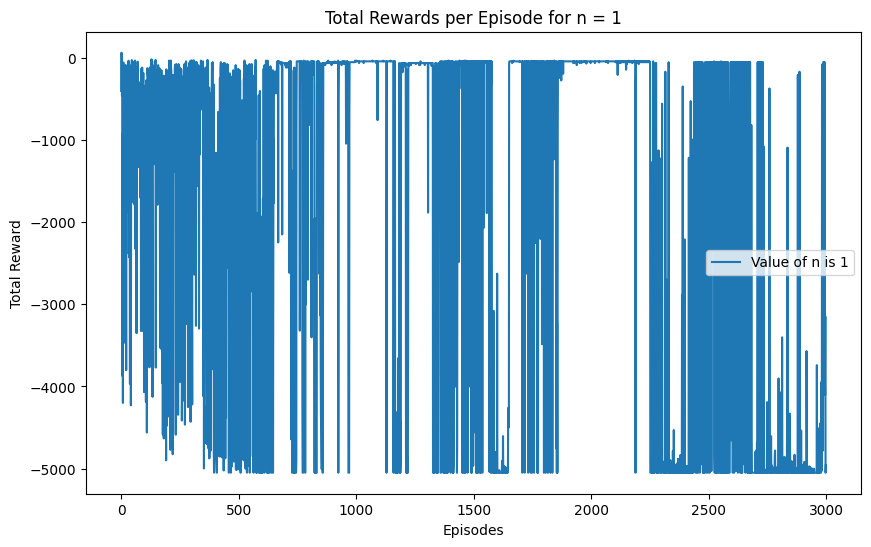

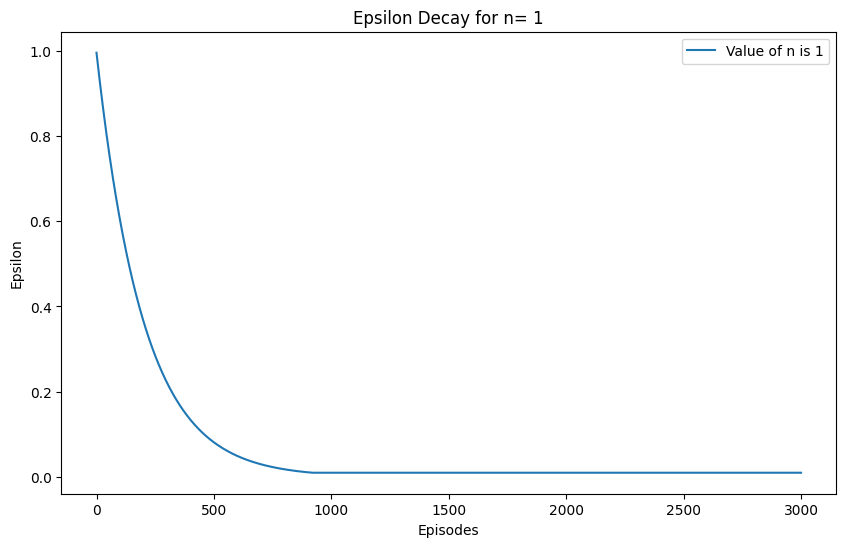

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↓ . . . .
. → ↓ . . .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↓ . . . .
. → ↓ . . .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↓ . . . .
. → ↓ . . .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↓ . . . .
. → ↓ . . .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↓ . . . .
. → ↓ . . .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↓ . . . .
. → ↓ . . .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↓ . . . .
. → ↓ . . .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation 

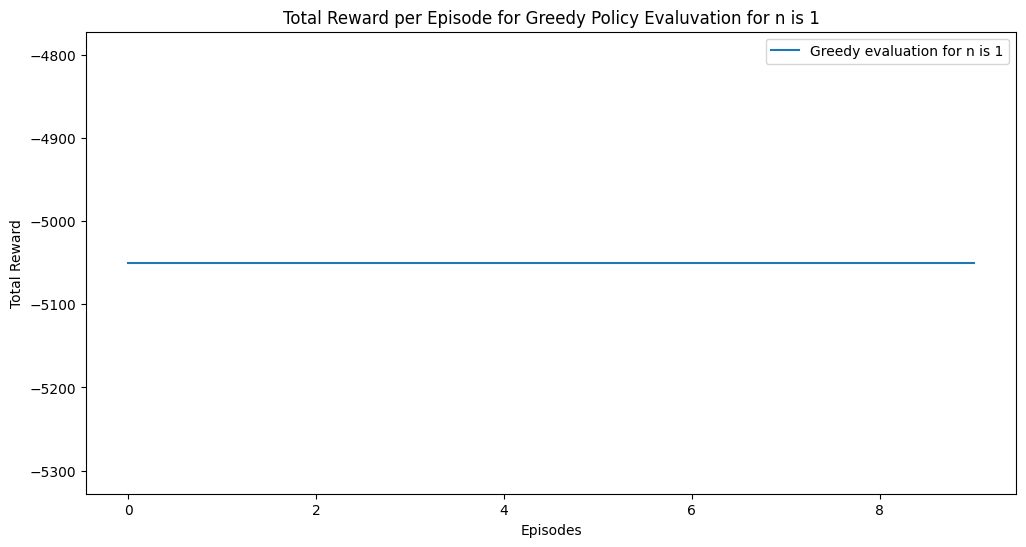

N value is -  2
Episode 100/3000, Total Reward: -464, Epsilon: 0.6058
Episode 200/3000, Total Reward: -340, Epsilon: 0.3670
Episode 300/3000, Total Reward: -2867, Epsilon: 0.2223
Episode 400/3000, Total Reward: -1596, Epsilon: 0.1347
Episode 500/3000, Total Reward: -4691, Epsilon: 0.0816
Episode 600/3000, Total Reward: -1081, Epsilon: 0.0494
Episode 700/3000, Total Reward: -4963, Epsilon: 0.0299
Episode 800/3000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/3000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/3000, Total Reward: -78, Epsilon: 0.0100
Episode 1300/3000, Total Reward: -4964, Epsilon: 0.0100
Episode 1400/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/3000, Total Reward: -2311, Epsilon: 0.0100
Episode 1700/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/3000, Total Reward: -5050, Epsil

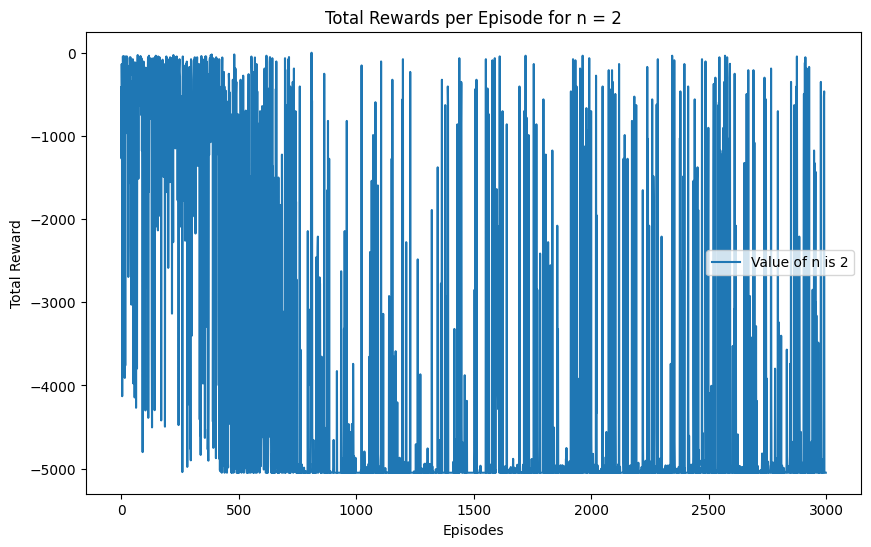

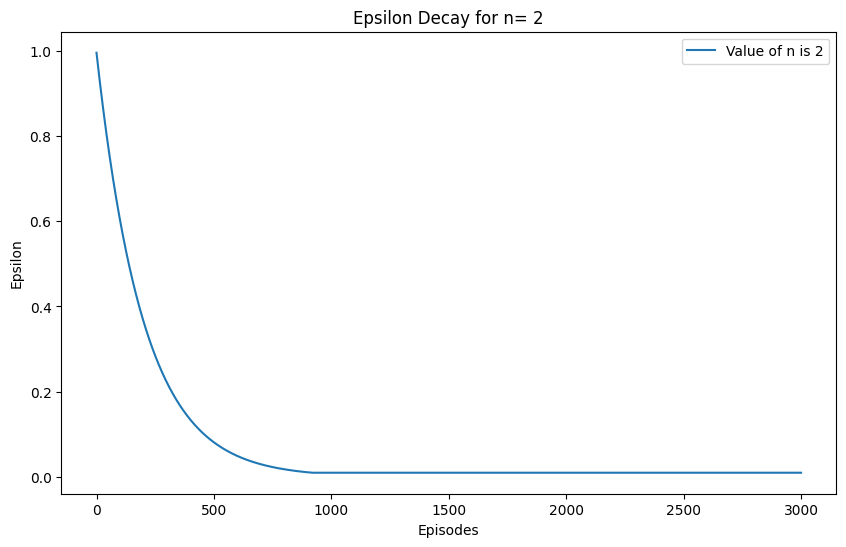

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↓ . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↓ . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↓ . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↓ . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↓ . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↓ . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↓ . . .
. . ↓ . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation 

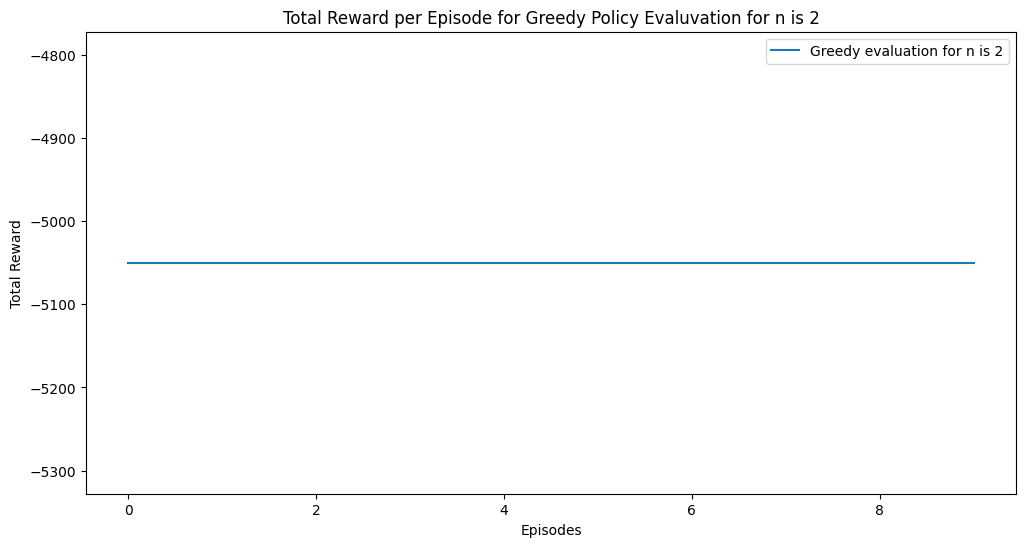

N value is -  3
Episode 100/3000, Total Reward: -205, Epsilon: 0.6058
Episode 200/3000, Total Reward: -2105, Epsilon: 0.3670
Episode 300/3000, Total Reward: -2766, Epsilon: 0.2223
Episode 400/3000, Total Reward: -190, Epsilon: 0.1347
Episode 500/3000, Total Reward: -28, Epsilon: 0.0816
Episode 600/3000, Total Reward: -4975, Epsilon: 0.0494
Episode 700/3000, Total Reward: -28, Epsilon: 0.0299
Episode 800/3000, Total Reward: -28, Epsilon: 0.0181
Episode 900/3000, Total Reward: -36, Epsilon: 0.0110
Episode 1000/3000, Total Reward: -45, Epsilon: 0.0100
Episode 1100/3000, Total Reward: -2211, Epsilon: 0.0100
Episode 1200/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/3000, Total Reward: -1590, Epsilon: 0.0100
Episode 1400/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/3000, Total Reward: -2775, Epsilon: 0.0100
Episode 1800/3000, Total Reward: -5050, Epsilon: 0.01

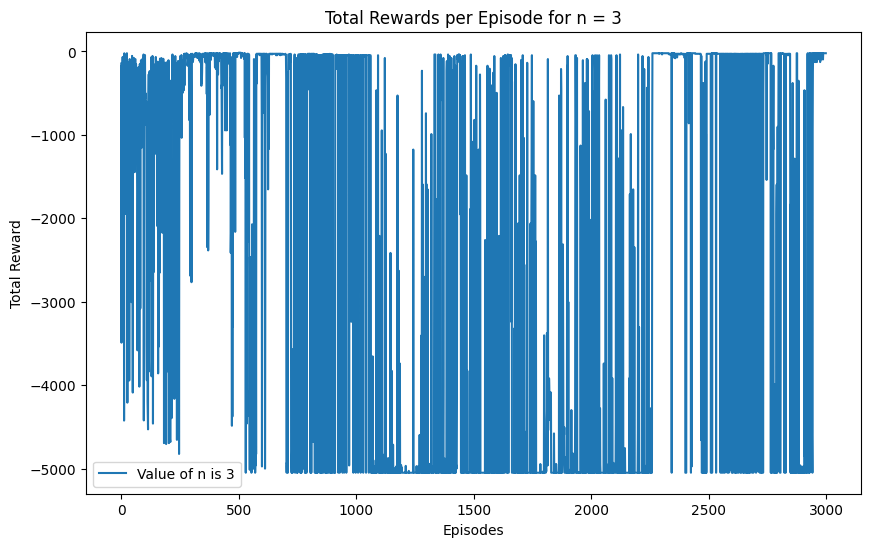

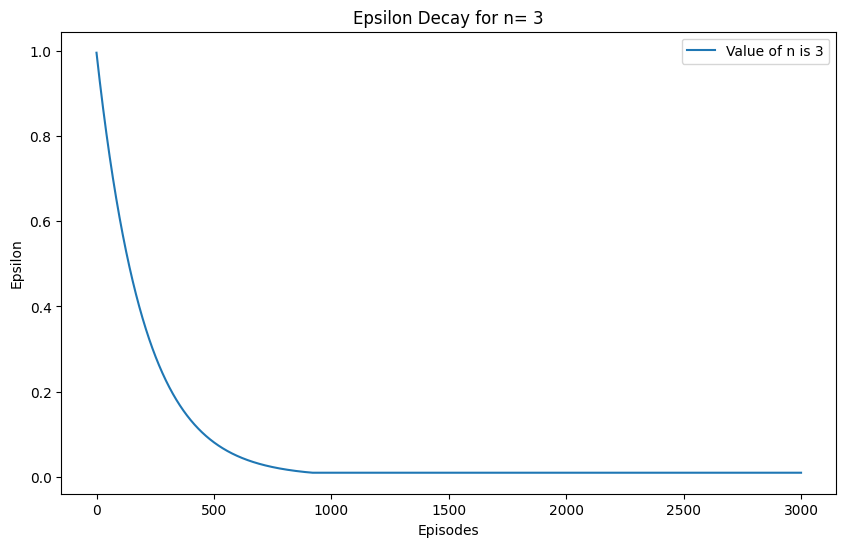

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -21
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -21
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -21
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -21
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -21
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -21
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -21
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 8: Tot

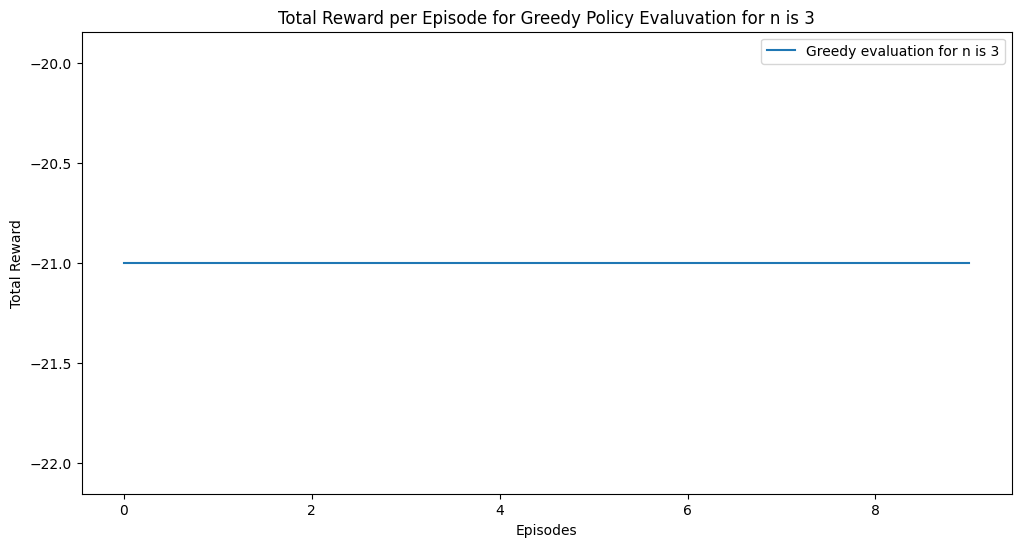

N value is -  4
Episode 100/3000, Total Reward: -1023, Epsilon: 0.6058
Episode 200/3000, Total Reward: -203, Epsilon: 0.3670
Episode 300/3000, Total Reward: -412, Epsilon: 0.2223
Episode 400/3000, Total Reward: -276, Epsilon: 0.1347
Episode 500/3000, Total Reward: -28, Epsilon: 0.0816
Episode 600/3000, Total Reward: -21, Epsilon: 0.0494
Episode 700/3000, Total Reward: -28, Epsilon: 0.0299
Episode 800/3000, Total Reward: -4186, Epsilon: 0.0181
Episode 900/3000, Total Reward: -21, Epsilon: 0.0110
Episode 1000/3000, Total Reward: -71, Epsilon: 0.0100
Episode 1100/3000, Total Reward: -28, Epsilon: 0.0100
Episode 1200/3000, Total Reward: -36, Epsilon: 0.0100
Episode 1300/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/3000, Total Reward: -28, Epsilon: 0.0100
Episode 1700/3000, Total Reward: -36, Epsilon: 0.0100
Episode 1800/3000, Total Reward: -36, Epsilon: 0.0100
Episode 

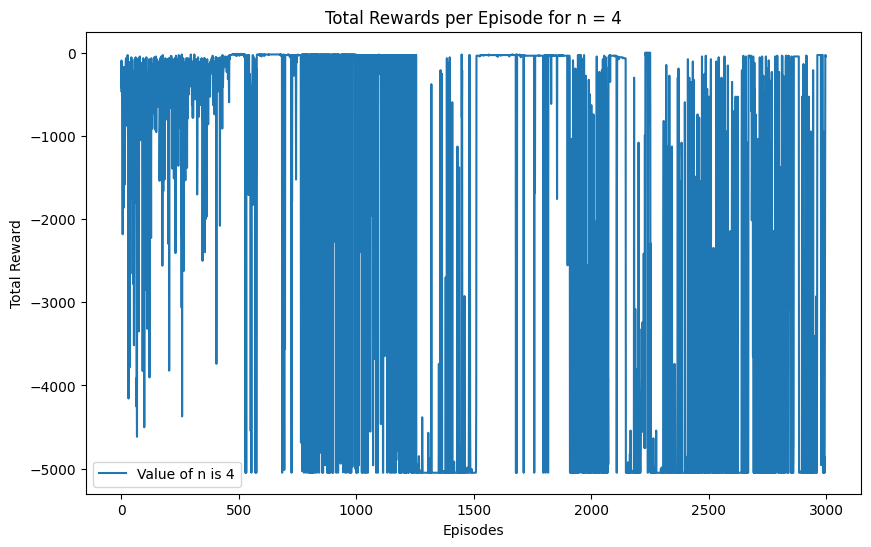

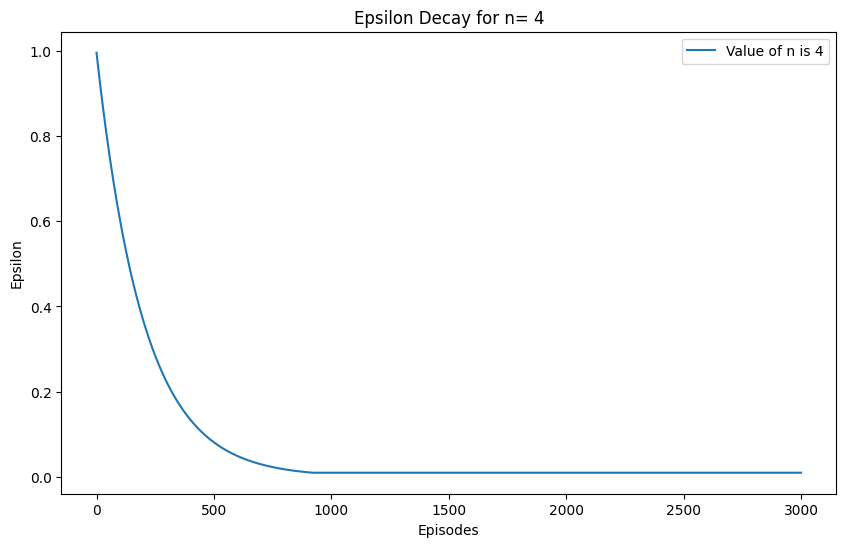

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . ↑ ← .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . ↑ ← .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . ↑ ← .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . ↑ ← .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . ↑ ← .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . ↑ ← .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . ↑ ← .


Greedy Evaluation 

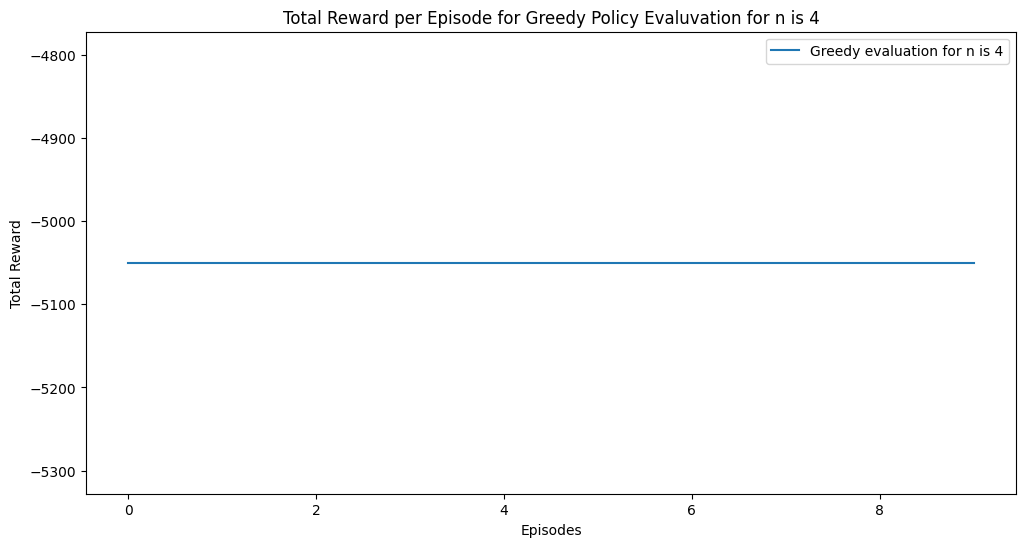

N value is -  5
Episode 100/3000, Total Reward: -411, Epsilon: 0.6058
Episode 200/3000, Total Reward: -990, Epsilon: 0.3670
Episode 300/3000, Total Reward: -5033, Epsilon: 0.2223
Episode 400/3000, Total Reward: -66, Epsilon: 0.1347
Episode 500/3000, Total Reward: -4981, Epsilon: 0.0816
Episode 600/3000, Total Reward: -4481, Epsilon: 0.0494
Episode 700/3000, Total Reward: -199, Epsilon: 0.0299
Episode 800/3000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/3000, Total Reward: -28, Epsilon: 0.0110
Episode 1000/3000, Total Reward: -36, Epsilon: 0.0100
Episode 1100/3000, Total Reward: -36, Epsilon: 0.0100
Episode 1200/3000, Total Reward: -36, Epsilon: 0.0100
Episode 1300/3000, Total Reward: -5003, Epsilon: 0.0100
Episode 1400/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/3000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/3000, Total Reward: -45, Epsilon: 0.0100
Episode 1800/3000, Total Reward: -55, Epsilon: 0.0100
Ep

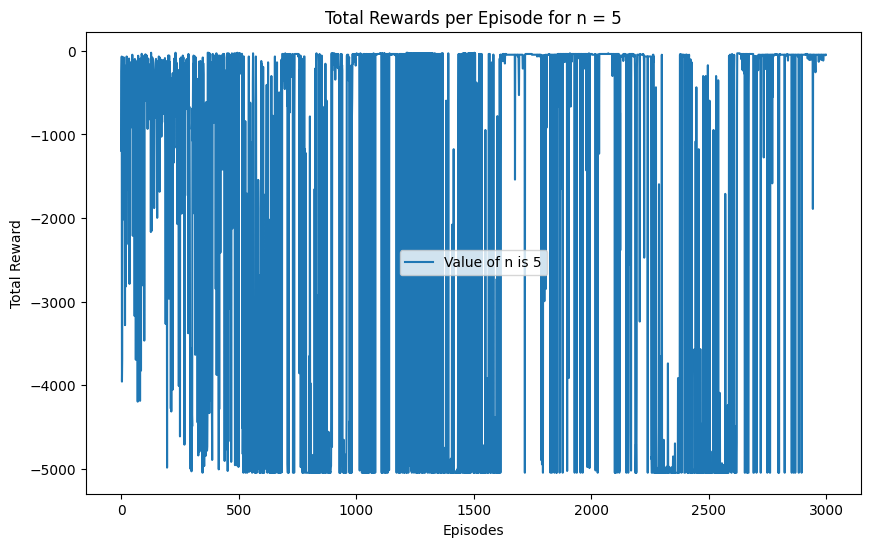

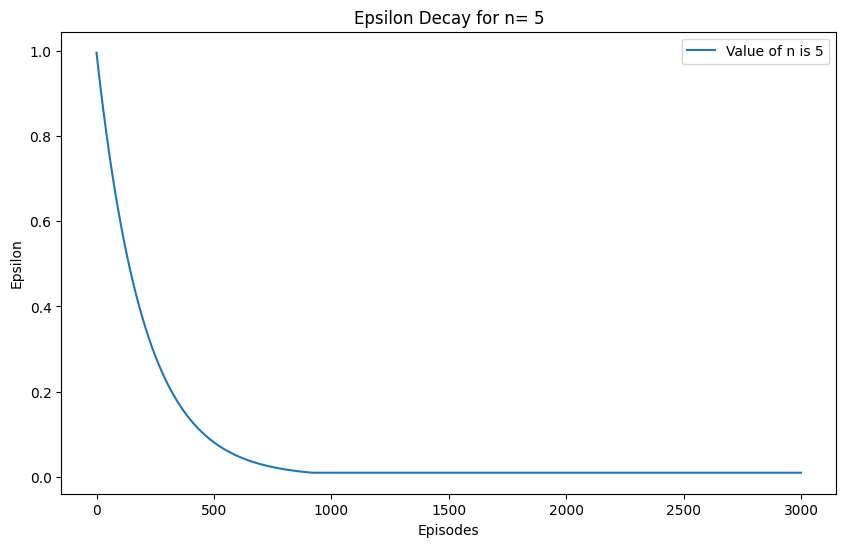

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -679
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↓ . . . .
. → → → → →
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -679
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↓ . . . .
. → → → → →
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -679
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↓ . . . .
. → → → → →
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -679
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↓ . . . .
. → → → → →
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -679
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↓ . . . .
. → → → → →
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -679
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↓ . . . .
. → → → → →
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -679
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↓ . . . .
. → → → → →
. . . . . .
. . . . . .


Greedy Evaluation Episode

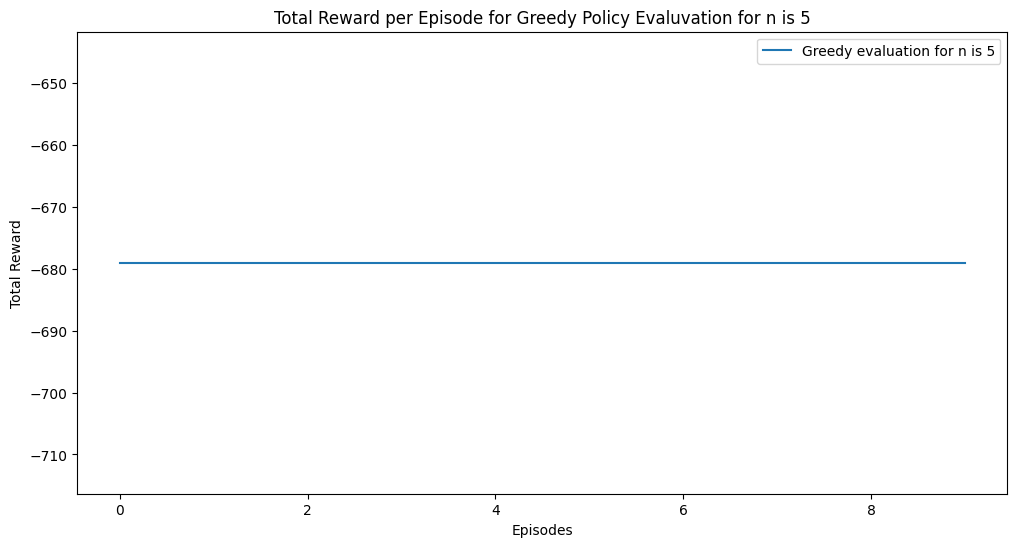

In [15]:
env = GridWorld()
discount = 1
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 3000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 2 - Discount Factor - Attempt 1

N value is -  1
Episode 100/2000, Total Reward: -602, Epsilon: 0.6058
Episode 200/2000, Total Reward: -59, Epsilon: 0.3670
Episode 300/2000, Total Reward: -406, Epsilon: 0.2223
Episode 400/2000, Total Reward: -556, Epsilon: 0.1347
Episode 500/2000, Total Reward: -758, Epsilon: 0.0816
Episode 600/2000, Total Reward: -630, Epsilon: 0.0494
Episode 700/2000, Total Reward: -45, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -300, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -2628, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5039, Epsilon: 0.0100
E

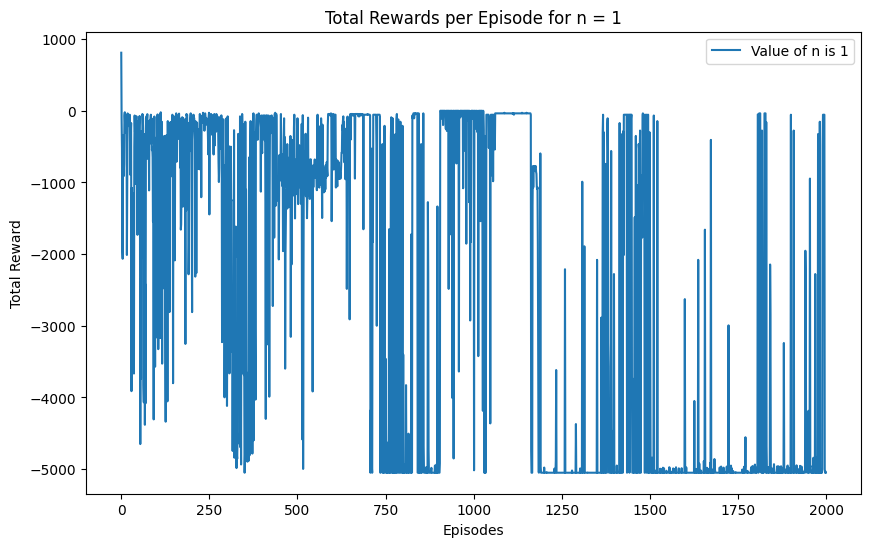

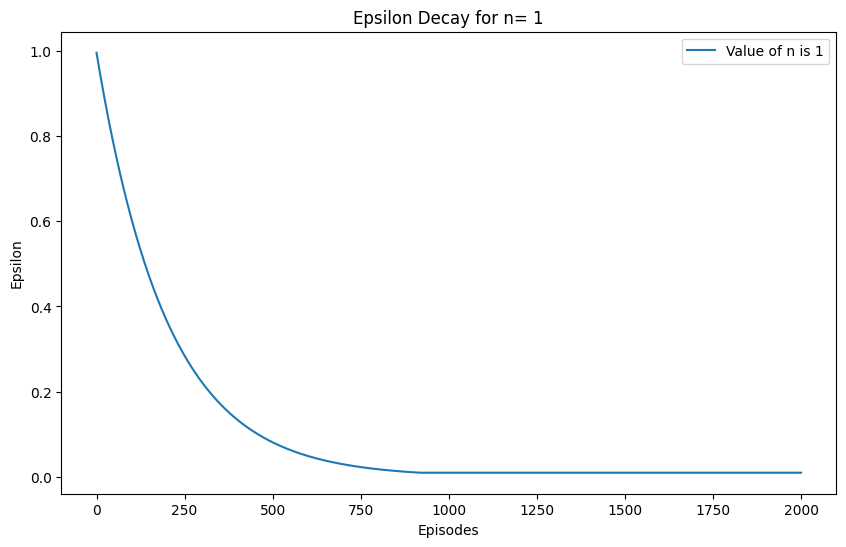

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. ↓ ← . . .
. ↘ . → → ←
. . → ↑ . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. ↓ ← . . .
. ↘ . → → ←
. . → ↑ . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. ↓ ← . . .
. ↘ . → → ←
. . → ↑ . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. ↓ ← . . .
. ↘ . → → ←
. . → ↑ . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. ↓ ← . . .
. ↘ . → → ←
. . → ↑ . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. ↓ ← . . .
. ↘ . → → ←
. . → ↑ . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. ↓ ← . . .
. ↘ . → → ←
. . → ↑ . .


Greedy Evaluation 

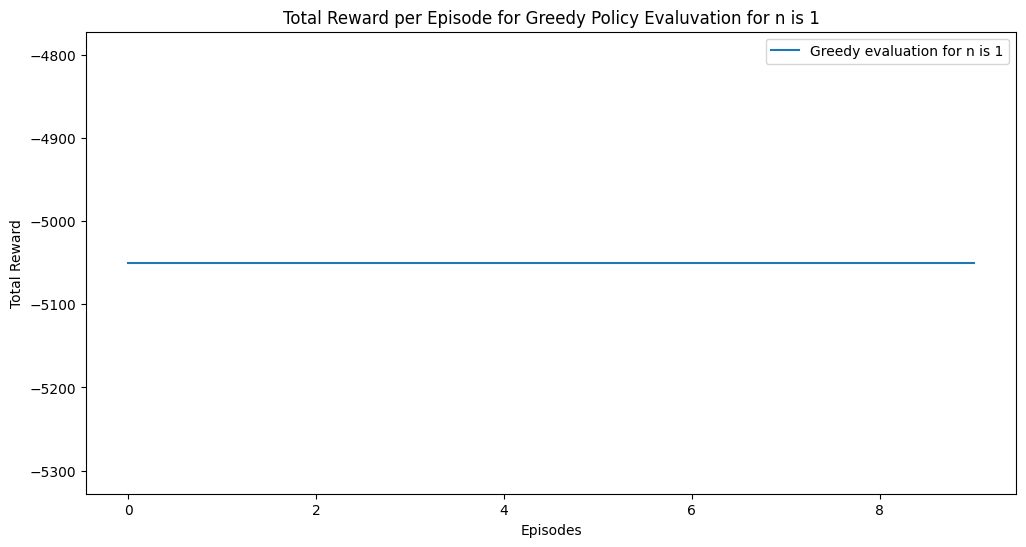

N value is -  2
Episode 100/2000, Total Reward: -371, Epsilon: 0.6058
Episode 200/2000, Total Reward: -231, Epsilon: 0.3670
Episode 300/2000, Total Reward: -981, Epsilon: 0.2223
Episode 400/2000, Total Reward: -1275, Epsilon: 0.1347
Episode 500/2000, Total Reward: -4714, Epsilon: 0.0816
Episode 600/2000, Total Reward: -3081, Epsilon: 0.0494
Episode 700/2000, Total Reward: -4278, Epsilon: 0.0299
Episode 800/2000, Total Reward: -1176, Epsilon: 0.0181
Episode 900/2000, Total Reward: 0, Epsilon: 0.0110
Episode 1000/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1100/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1200/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1300/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -257, Epsilon: 0.0100
Episode 1500/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1600/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -4962, Epsilon: 0.0100
Episode 1900/2000

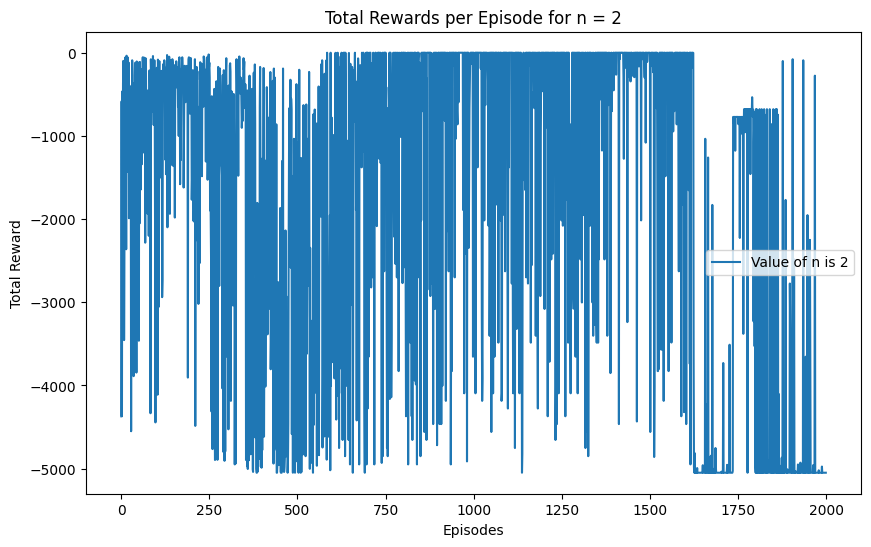

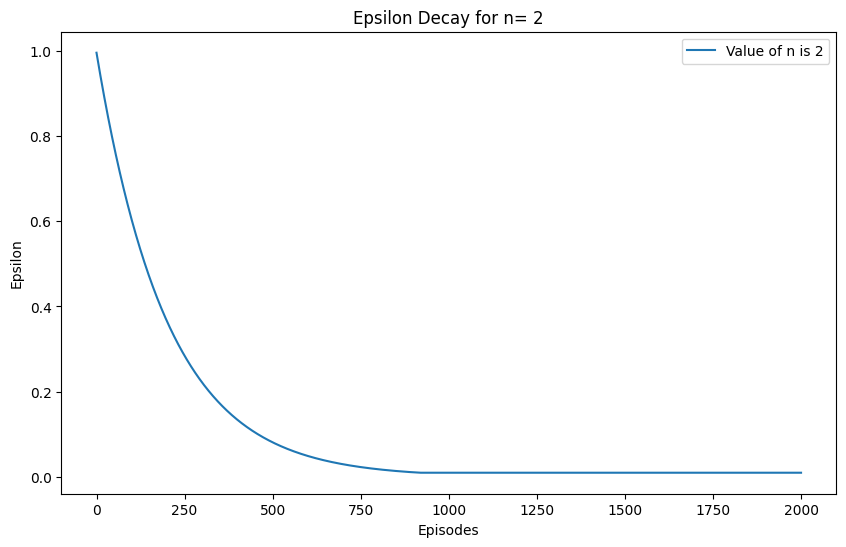

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↘ ↘ . .
. . . ↑ ↘ .
. . . . → ←
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↘ ↘ . .
. . . ↑ ↘ .
. . . . → ←
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↘ ↘ . .
. . . ↑ ↘ .
. . . . → ←
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↘ ↘ . .
. . . ↑ ↘ .
. . . . → ←
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↘ ↘ . .
. . . ↑ ↘ .
. . . . → ←
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↘ ↘ . .
. . . ↑ ↘ .
. . . . → ←
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . ↘ ↘ . .
. . . ↑ ↘ .
. . . . → ←
. . . . . .
. . . . . .


Greedy Evaluation 

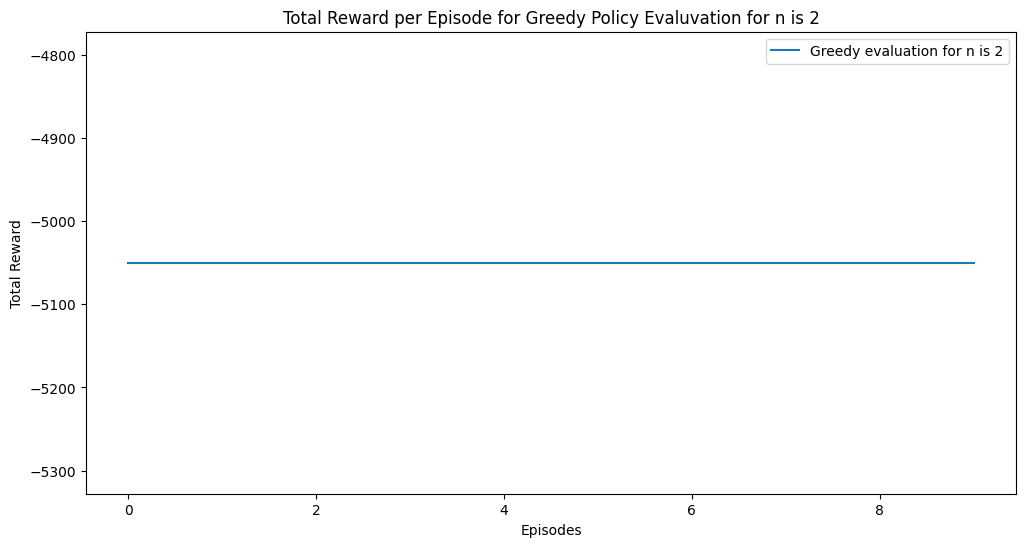

N value is -  3
Episode 100/2000, Total Reward: -1418, Epsilon: 0.6058
Episode 200/2000, Total Reward: -36, Epsilon: 0.3670
Episode 300/2000, Total Reward: -443, Epsilon: 0.2223
Episode 400/2000, Total Reward: -229, Epsilon: 0.1347
Episode 500/2000, Total Reward: -28, Epsilon: 0.0816
Episode 600/2000, Total Reward: -21, Epsilon: 0.0494
Episode 700/2000, Total Reward: -15, Epsilon: 0.0299
Episode 800/2000, Total Reward: -15, Epsilon: 0.0181
Episode 900/2000, Total Reward: -4912, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 190

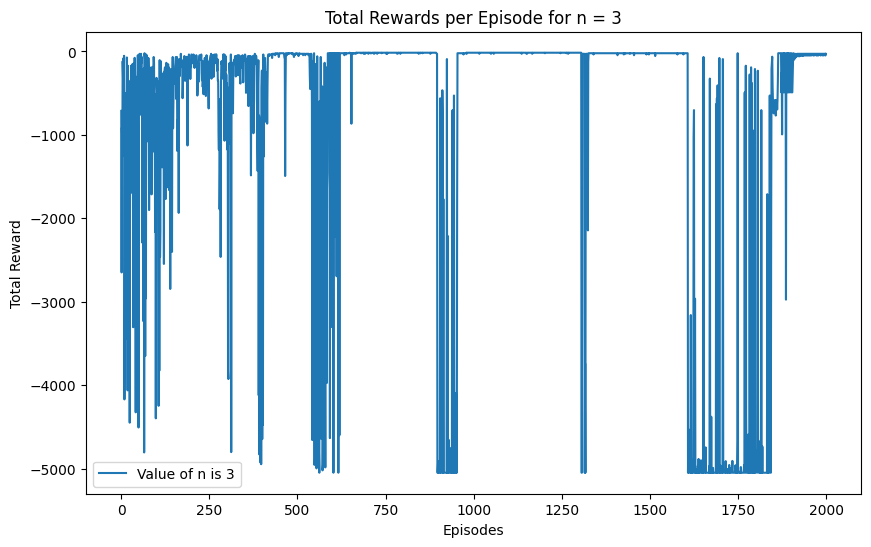

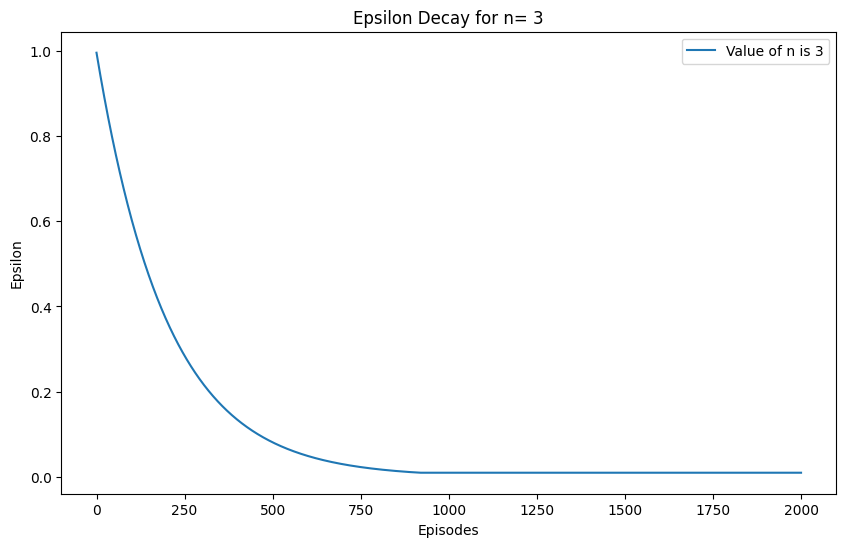

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -28
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↘ ←
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -28
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↘ ←
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -28
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↘ ←
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -28
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↘ ←
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -28
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↘ ←
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -28
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↘ ←
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -28
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↘ ←
. . . . . .


Greedy Evaluation Episode 8: Tot

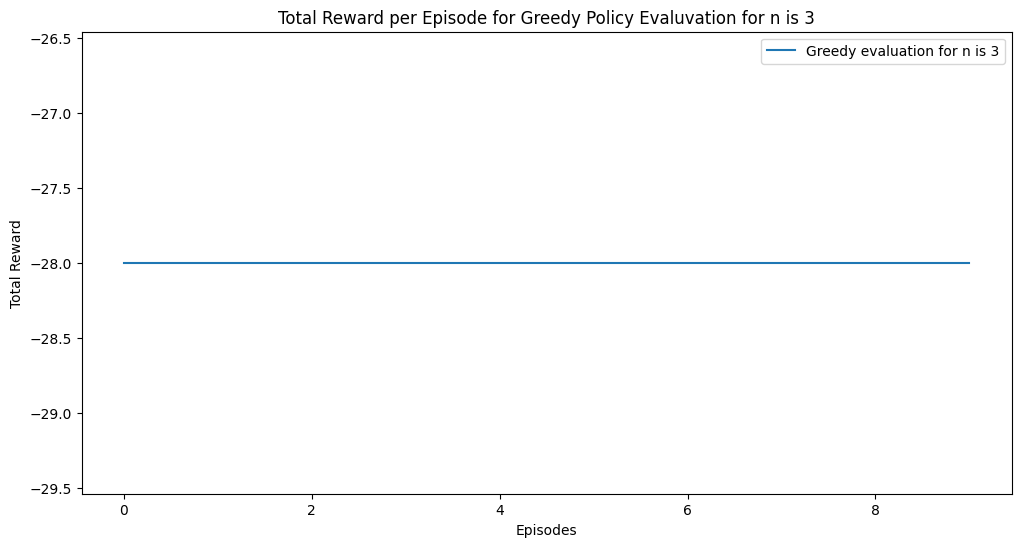

N value is -  4
Episode 100/2000, Total Reward: -96, Epsilon: 0.6058
Episode 200/2000, Total Reward: -528, Epsilon: 0.3670
Episode 300/2000, Total Reward: -397, Epsilon: 0.2223
Episode 400/2000, Total Reward: -2825, Epsilon: 0.1347
Episode 500/2000, Total Reward: -36, Epsilon: 0.0816
Episode 600/2000, Total Reward: -36, Epsilon: 0.0494
Episode 700/2000, Total Reward: -5019, Epsilon: 0.0299
Episode 800/2000, Total Reward: -990, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -4950, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -1081, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -4950, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -4095, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -55, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -4996, Epsilon: 0.0

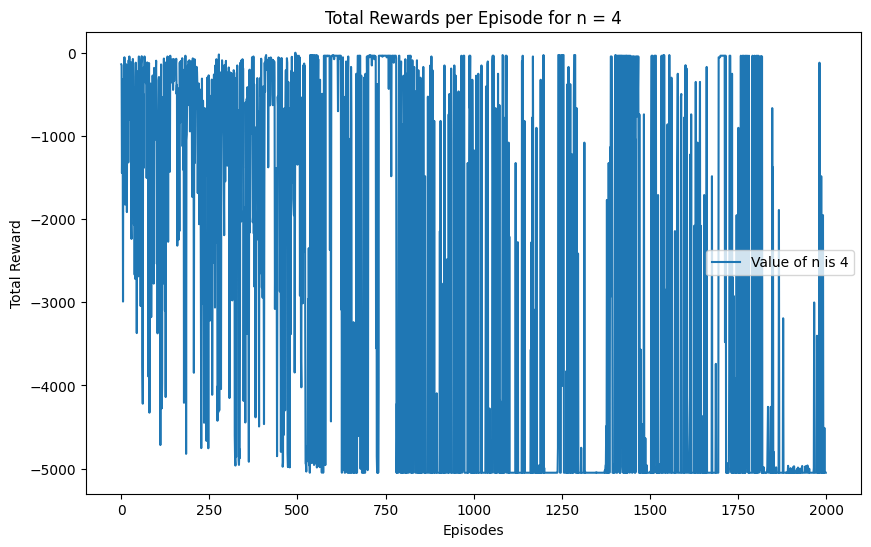

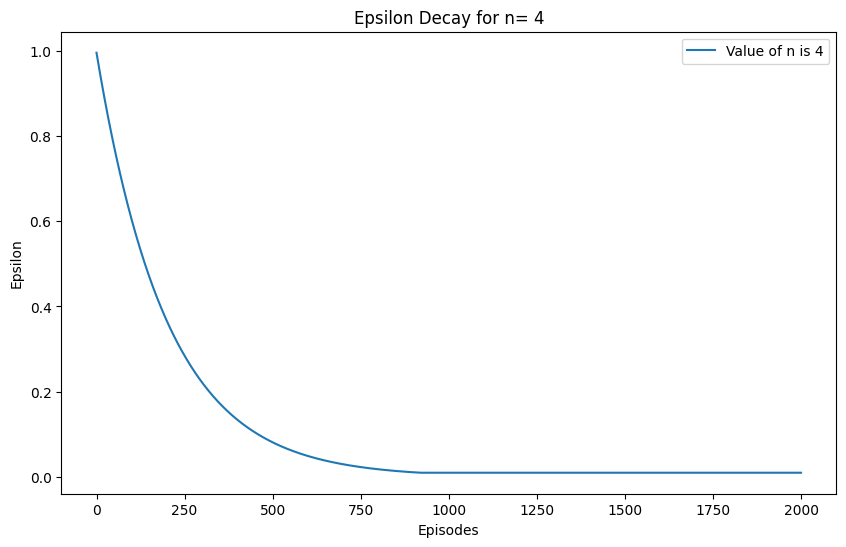

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↓ . . .
. . → → → ↓
. . . . . ↓
. . . → ↓ ←
. . . ↑ ← .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↓ . . .
. . → → → ↓
. . . . . ↓
. . . → ↓ ←
. . . ↑ ← .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↓ . . .
. . → → → ↓
. . . . . ↓
. . . → ↓ ←
. . . ↑ ← .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↓ . . .
. . → → → ↓
. . . . . ↓
. . . → ↓ ←
. . . ↑ ← .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↓ . . .
. . → → → ↓
. . . . . ↓
. . . → ↓ ←
. . . ↑ ← .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↓ . . .
. . → → → ↓
. . . . . ↓
. . . → ↓ ←
. . . ↑ ← .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ↓ . . .
. . → → → ↓
. . . . . ↓
. . . → ↓ ←
. . . ↑ ← .


Greedy Evaluation 

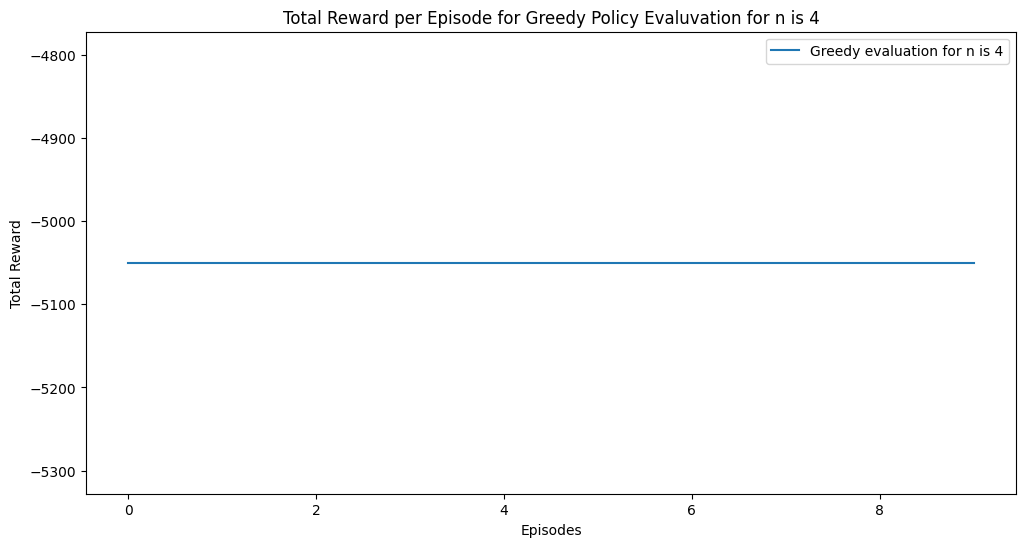

N value is -  5
Episode 100/2000, Total Reward: -64, Epsilon: 0.6058
Episode 200/2000, Total Reward: -213, Epsilon: 0.3670
Episode 300/2000, Total Reward: -203, Epsilon: 0.2223
Episode 400/2000, Total Reward: -5050, Epsilon: 0.1347
Episode 500/2000, Total Reward: -55, Epsilon: 0.0816
Episode 600/2000, Total Reward: -460, Epsilon: 0.0494
Episode 700/2000, Total Reward: -774, Epsilon: 0.0299
Episode 800/2000, Total Reward: -45, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -5005, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -443, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -490, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -490, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -740, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -2346, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -66, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -21, Epsilon: 0.0100
Episo

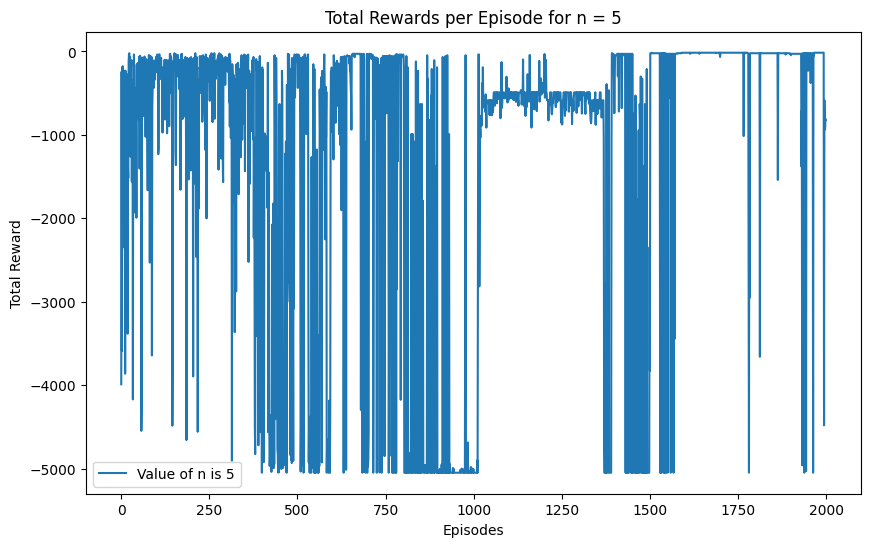

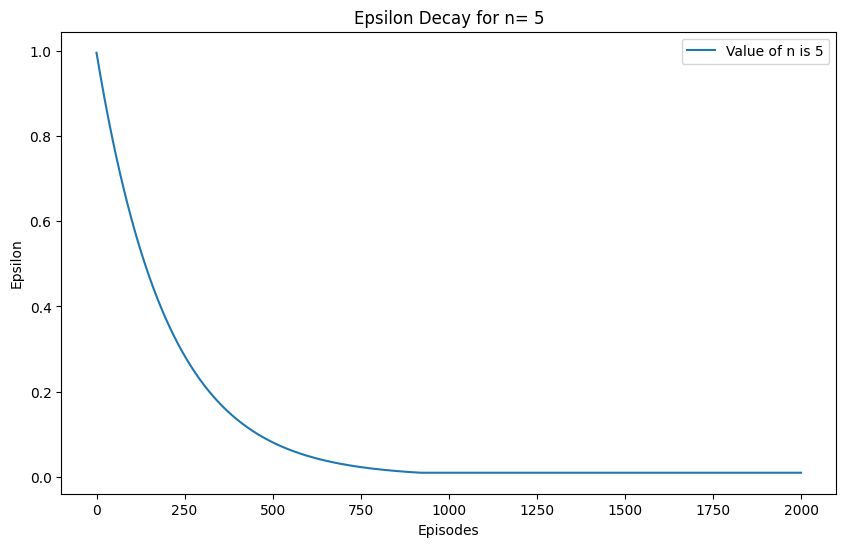

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -585
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . ↓ ← .
. . . ↓ . .


Greedy Evaluation Episode 2: Total Reward = -585
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . ↓ ← .
. . . ↓ . .


Greedy Evaluation Episode 3: Total Reward = -585
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . ↓ ← .
. . . ↓ . .


Greedy Evaluation Episode 4: Total Reward = -585
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . ↓ ← .
. . . ↓ . .


Greedy Evaluation Episode 5: Total Reward = -585
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . ↓ ← .
. . . ↓ . .


Greedy Evaluation Episode 6: Total Reward = -585
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . ↓ ← .
. . . ↓ . .


Greedy Evaluation Episode 7: Total Reward = -585
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . ↓ ← .
. . . ↓ . .


Greedy Evaluation Episode

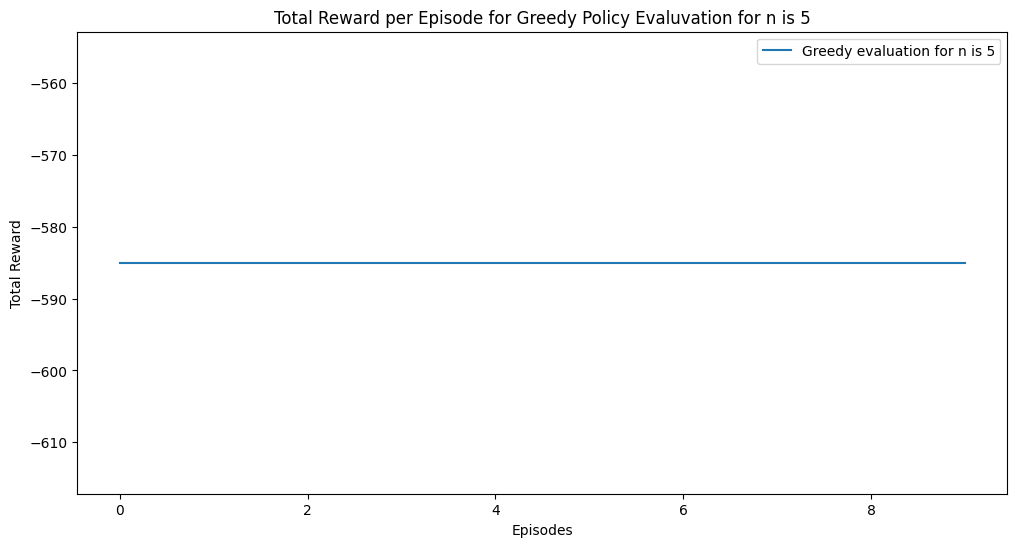

In [16]:
env = GridWorld()
discount = 0.90
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 2000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 2 - Discount Factor - Attempt 2

N value is -  1
Episode 100/2000, Total Reward: -386, Epsilon: 0.6058
Episode 200/2000, Total Reward: -374, Epsilon: 0.3670
Episode 300/2000, Total Reward: -2124, Epsilon: 0.2223
Episode 400/2000, Total Reward: -3506, Epsilon: 0.1347
Episode 500/2000, Total Reward: -1446, Epsilon: 0.0816
Episode 600/2000, Total Reward: -3464, Epsilon: 0.0494
Episode 700/2000, Total Reward: -98, Epsilon: 0.0299
Episode 800/2000, Total Reward: -55, Epsilon: 0.0181
Episode 900/2000, Total Reward: 0, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1400/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -578, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -61, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.0100
Episod

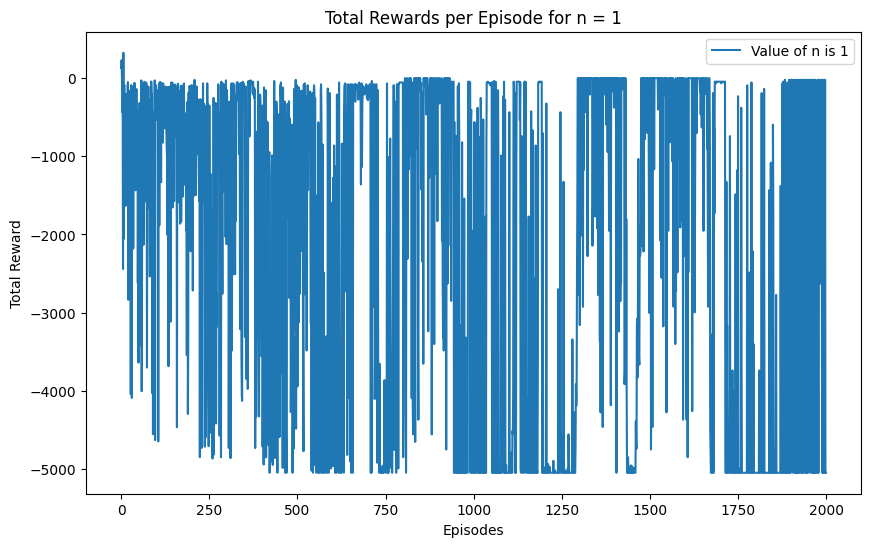

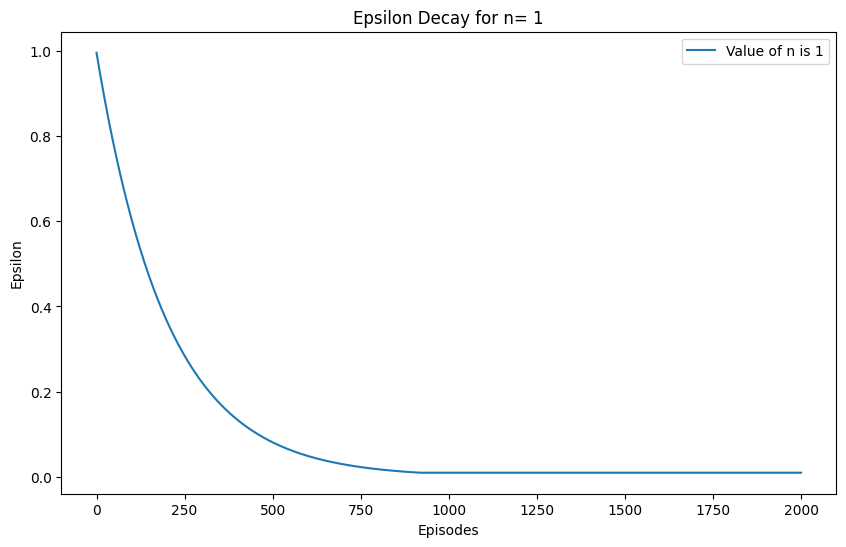

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -21
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . ↓
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -21
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . ↓
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -21
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . ↓
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -21
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . ↓
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -21
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . ↓
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -21
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . ↓
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -21
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . ↓
. . . . . .


Greedy Evaluation Episode 8: Tot

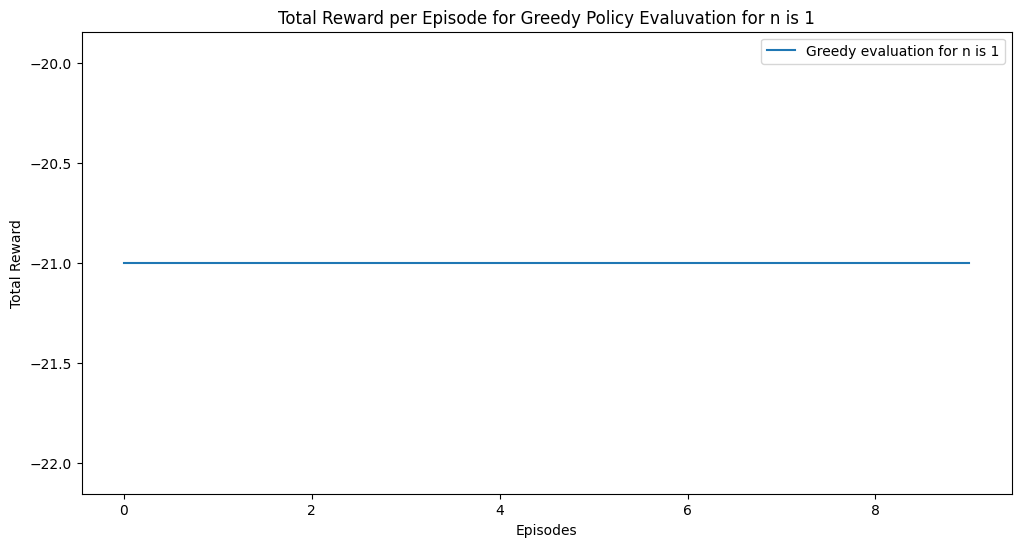

N value is -  2
Episode 100/2000, Total Reward: -100, Epsilon: 0.6058
Episode 200/2000, Total Reward: -3900, Epsilon: 0.3670
Episode 300/2000, Total Reward: -66, Epsilon: 0.2223
Episode 400/2000, Total Reward: -4967, Epsilon: 0.1347
Episode 500/2000, Total Reward: -4005, Epsilon: 0.0816
Episode 600/2000, Total Reward: -1350, Epsilon: 0.0494
Episode 700/2000, Total Reward: -5025, Epsilon: 0.0299
Episode 800/2000, Total Reward: -4656, Epsilon: 0.0181
Episode 900/2000, Total Reward: -4095, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -4998, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -4141, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -490, Epsil

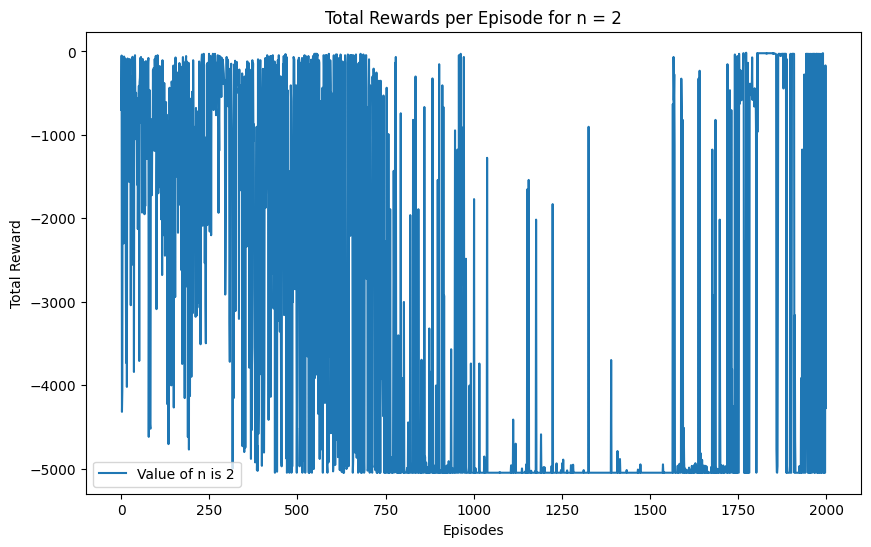

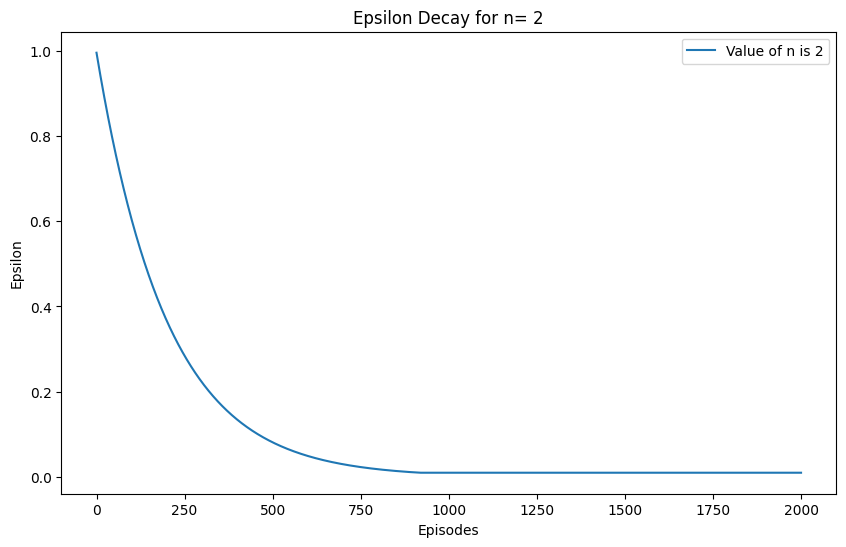

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . ↓ . .
. . . → → .


Greedy Evaluation Episode 2: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . ↓ . .
. . . → → .


Greedy Evaluation Episode 3: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . ↓ . .
. . . → → .


Greedy Evaluation Episode 4: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . ↓ . .
. . . → → .


Greedy Evaluation Episode 5: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . ↓ . .
. . . → → .


Greedy Evaluation Episode 6: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . ↓ . .
. . . → → .


Greedy Evaluation Episode 7: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . ↓ . .
. . . → → .


Greedy Evaluation Episode 8: Tot

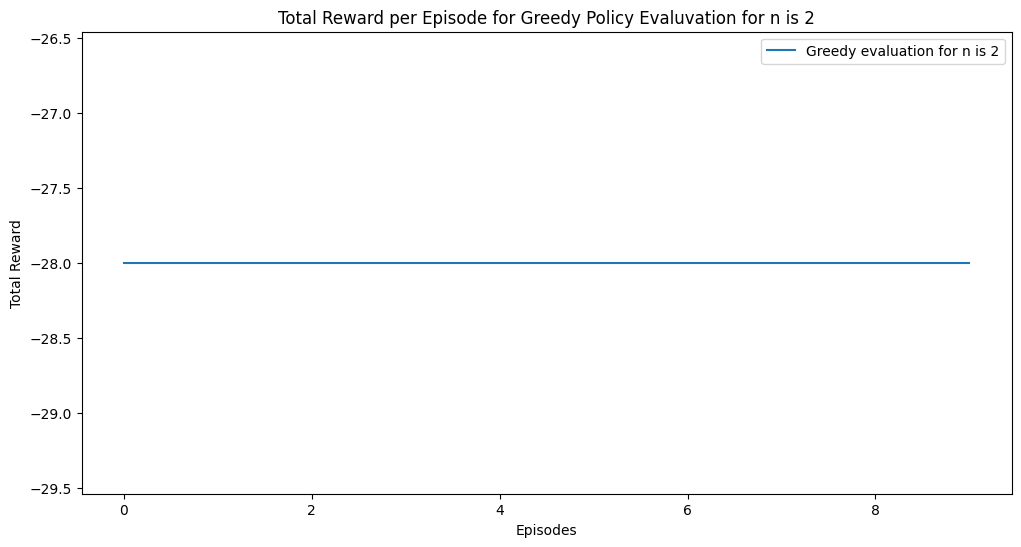

N value is -  3
Episode 100/2000, Total Reward: -451, Epsilon: 0.6058
Episode 200/2000, Total Reward: -105, Epsilon: 0.3670
Episode 300/2000, Total Reward: -36, Epsilon: 0.2223
Episode 400/2000, Total Reward: -28, Epsilon: 0.1347
Episode 500/2000, Total Reward: -1679, Epsilon: 0.0816
Episode 600/2000, Total Reward: -221, Epsilon: 0.0494
Episode 700/2000, Total Reward: -2016, Epsilon: 0.0299
Episode 800/2000, Total Reward: -45, Epsilon: 0.0181
Episode 900/2000, Total Reward: -136, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -55, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -55, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -55, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -105, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 19

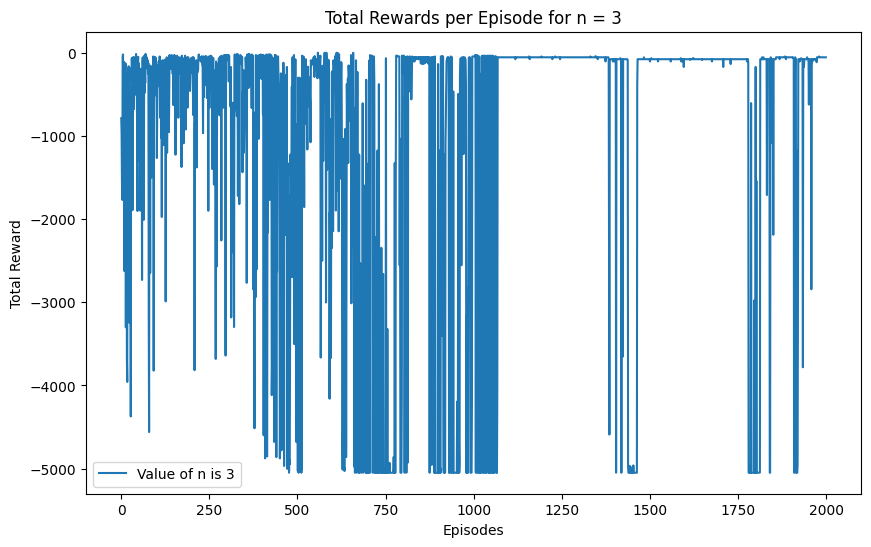

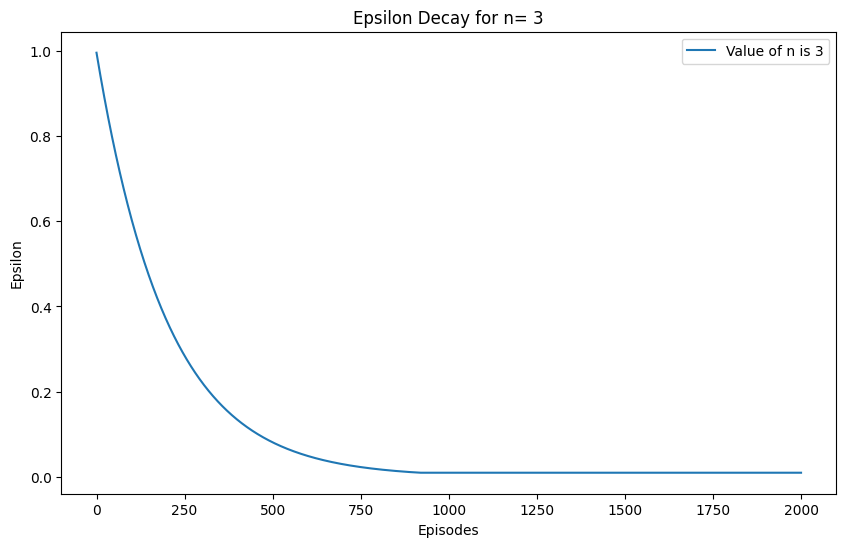

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -55
Action Grid:
→ → → ↓ . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -55
Action Grid:
→ → → ↓ . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -55
Action Grid:
→ → → ↓ . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -55
Action Grid:
→ → → ↓ . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -55
Action Grid:
→ → → ↓ . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -55
Action Grid:
→ → → ↓ . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -55
Action Grid:
→ → → ↓ . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → ↓
. . . . . .


Greedy Evaluation Episode 8: Tot

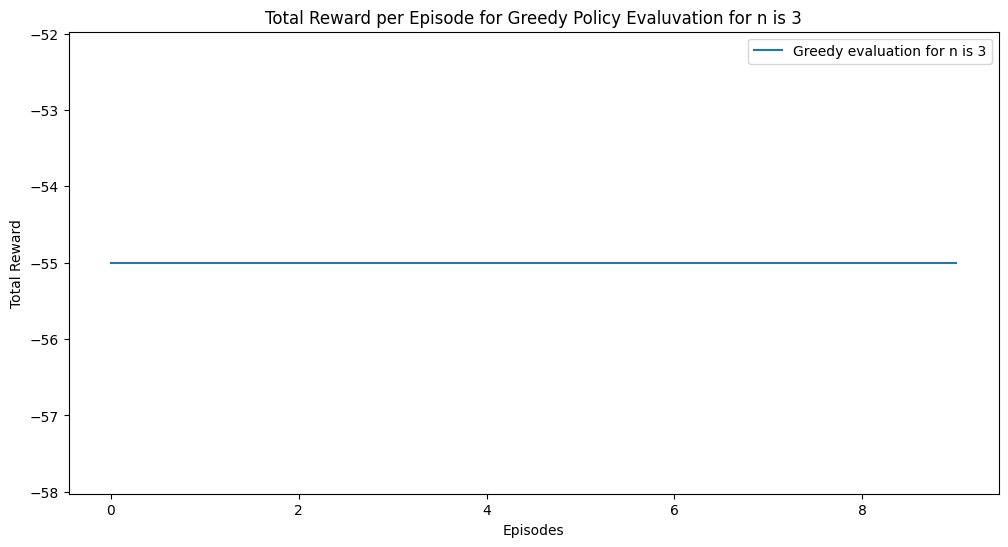

N value is -  4
Episode 100/2000, Total Reward: -375, Epsilon: 0.6058
Episode 200/2000, Total Reward: -21, Epsilon: 0.3670
Episode 300/2000, Total Reward: -105, Epsilon: 0.2223
Episode 400/2000, Total Reward: -2465, Epsilon: 0.1347
Episode 500/2000, Total Reward: -36, Epsilon: 0.0816
Episode 600/2000, Total Reward: -36, Epsilon: 0.0494
Episode 700/2000, Total Reward: -1002, Epsilon: 0.0299
Episode 800/2000, Total Reward: -151, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -210, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -3741, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -1081, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.

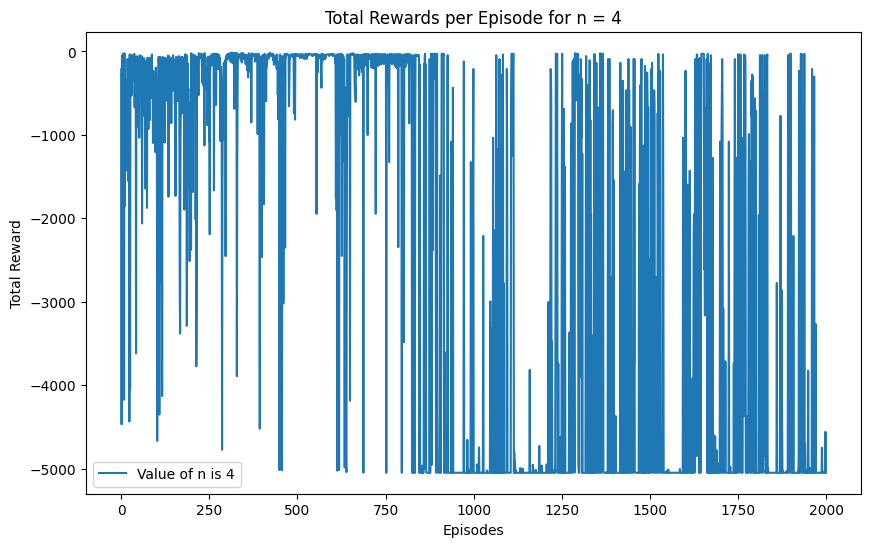

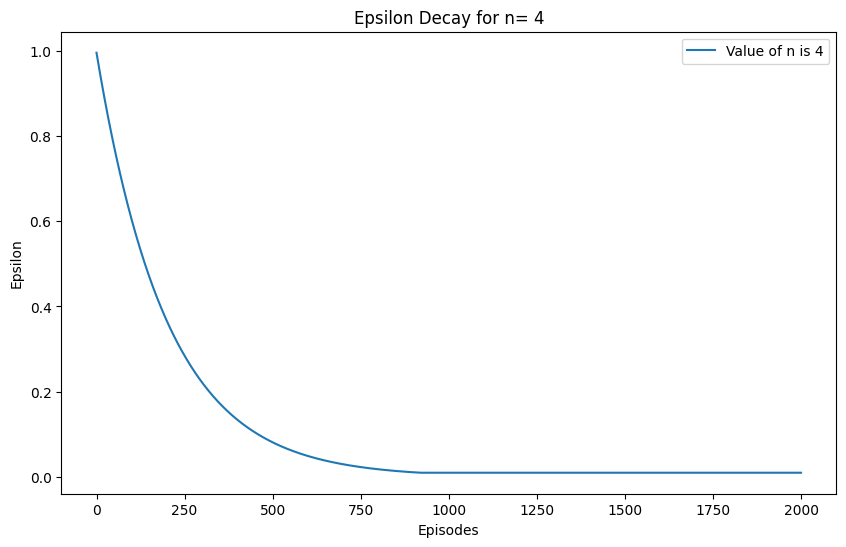

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

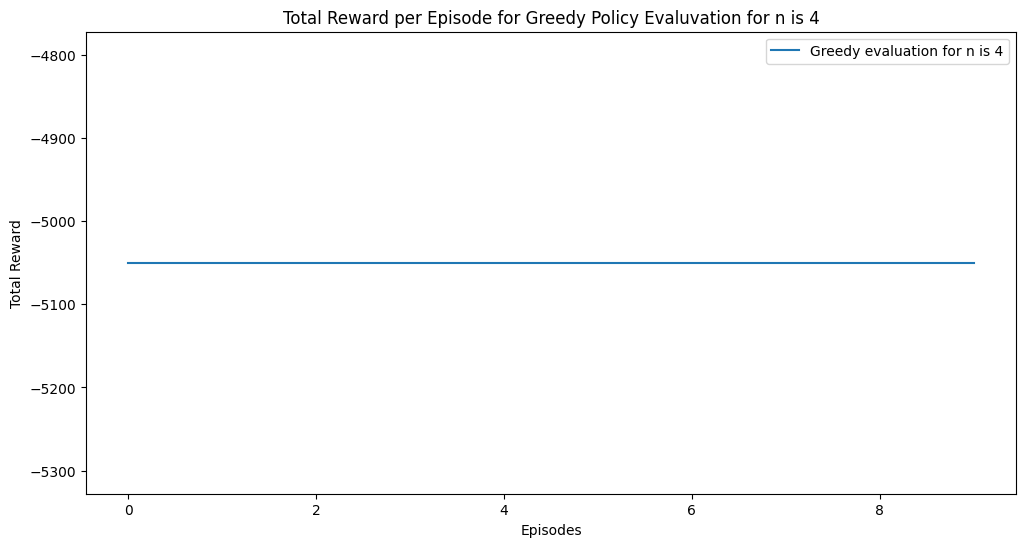

N value is -  5
Episode 100/2000, Total Reward: -55, Epsilon: 0.6058
Episode 200/2000, Total Reward: -265, Epsilon: 0.3670
Episode 300/2000, Total Reward: -300, Epsilon: 0.2223
Episode 400/2000, Total Reward: -351, Epsilon: 0.1347
Episode 500/2000, Total Reward: -120, Epsilon: 0.0816
Episode 600/2000, Total Reward: -1128, Epsilon: 0.0494
Episode 700/2000, Total Reward: -28, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -28, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1900/

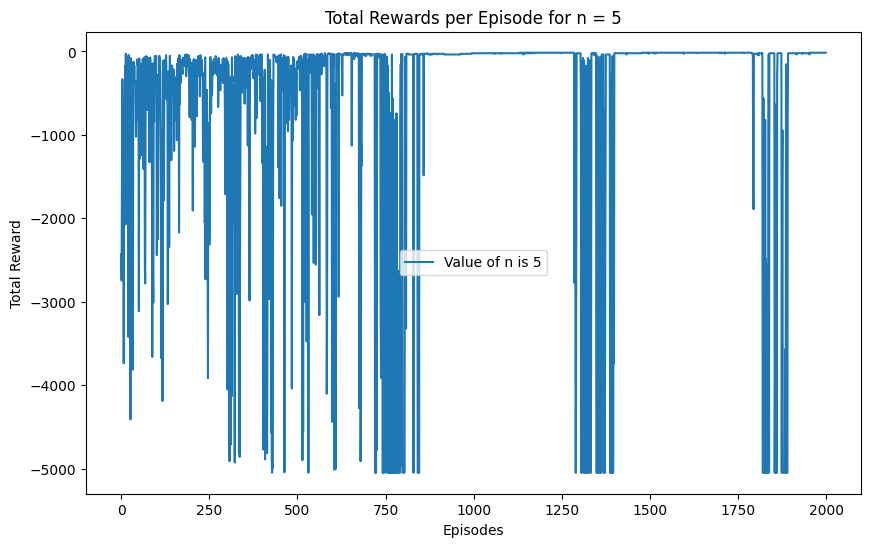

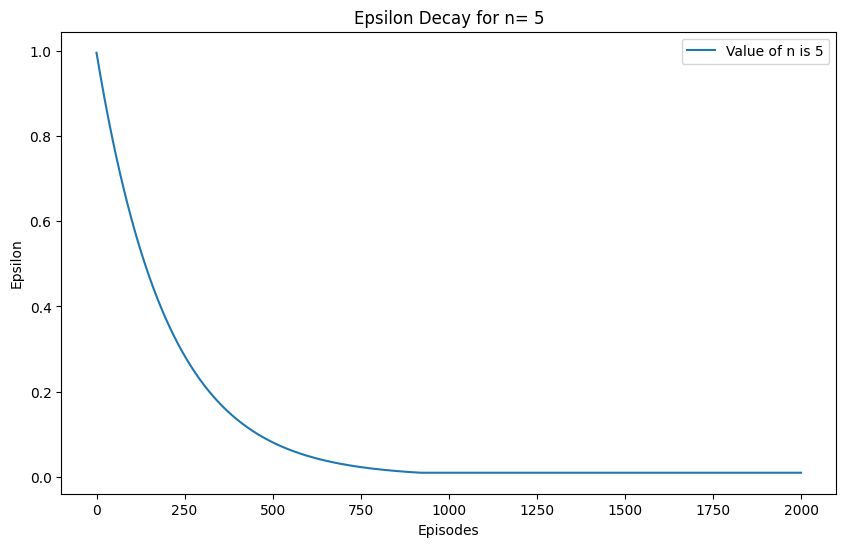

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 8: Tot

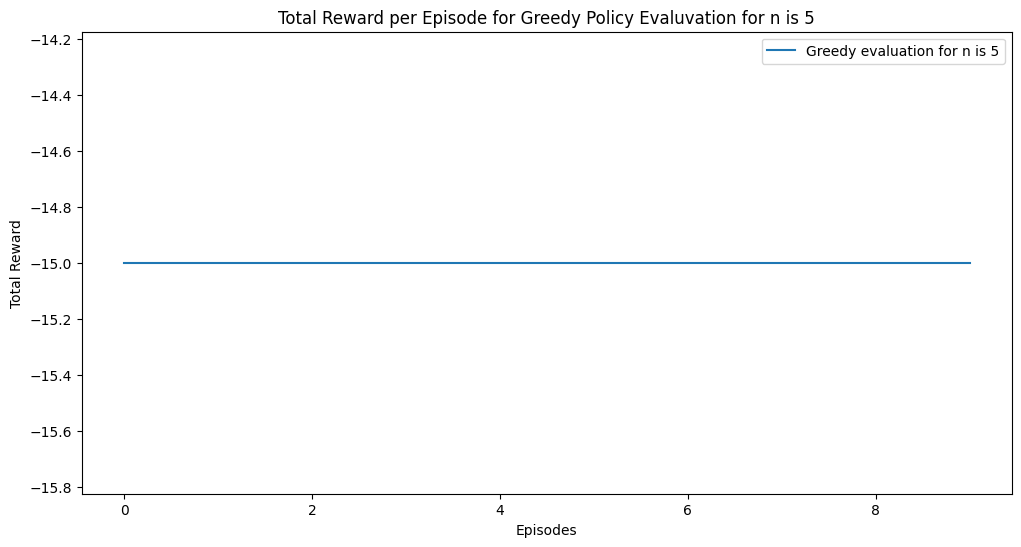

In [17]:
env = GridWorld()
discount = 0.95
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 2000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 2 - Discount Factor - Attempt 3

N value is -  1
Episode 100/2000, Total Reward: -45, Epsilon: 0.6058
Episode 200/2000, Total Reward: -751, Epsilon: 0.3670
Episode 300/2000, Total Reward: -4110, Epsilon: 0.2223
Episode 400/2000, Total Reward: -2133, Epsilon: 0.1347
Episode 500/2000, Total Reward: -21, Epsilon: 0.0816
Episode 600/2000, Total Reward: -28, Epsilon: 0.0494
Episode 700/2000, Total Reward: -28, Epsilon: 0.0299
Episode 800/2000, Total Reward: -95, Epsilon: 0.0181
Episode 900/2000, Total Reward: -28, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -55, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -61, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -66, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -780, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -3403, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -21, Epsilon: 0.0100
Episode 190

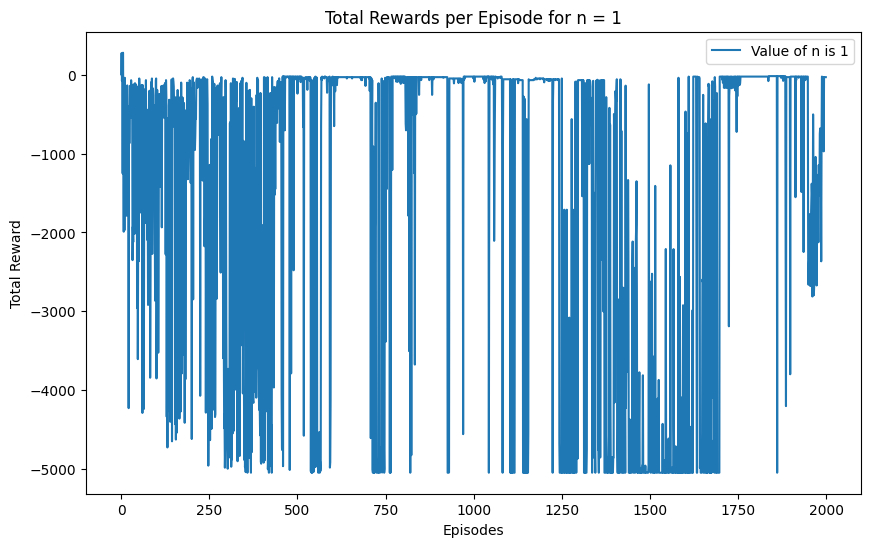

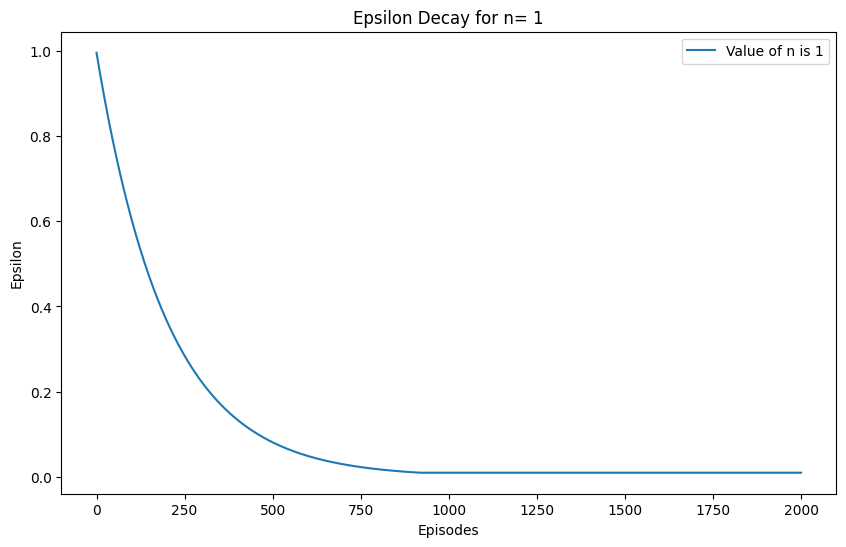

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 2: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 3: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 4: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 5: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 6: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 7: Total Reward = -28
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . → .


Greedy Evaluation Episode 8: Tot

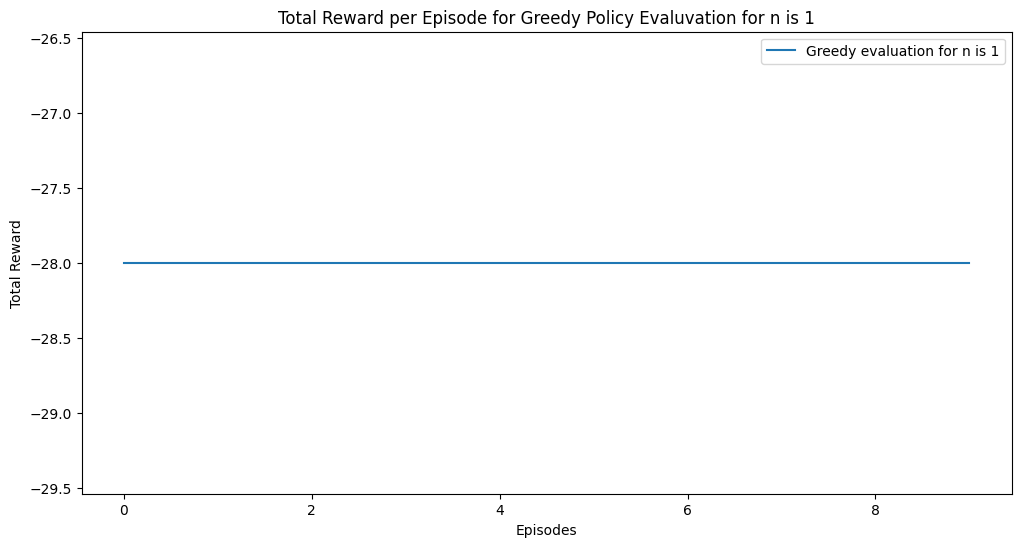

N value is -  2
Episode 100/2000, Total Reward: -2063, Epsilon: 0.6058
Episode 200/2000, Total Reward: -4634, Epsilon: 0.3670
Episode 300/2000, Total Reward: -4037, Epsilon: 0.2223
Episode 400/2000, Total Reward: -4983, Epsilon: 0.1347
Episode 500/2000, Total Reward: -780, Epsilon: 0.0816
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0494
Episode 700/2000, Total Reward: -4628, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -4953, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -4986, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Ep

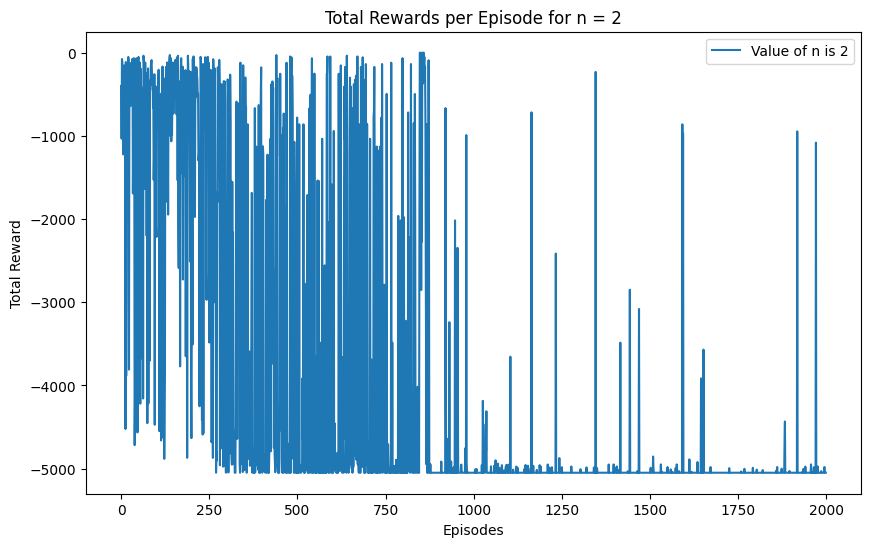

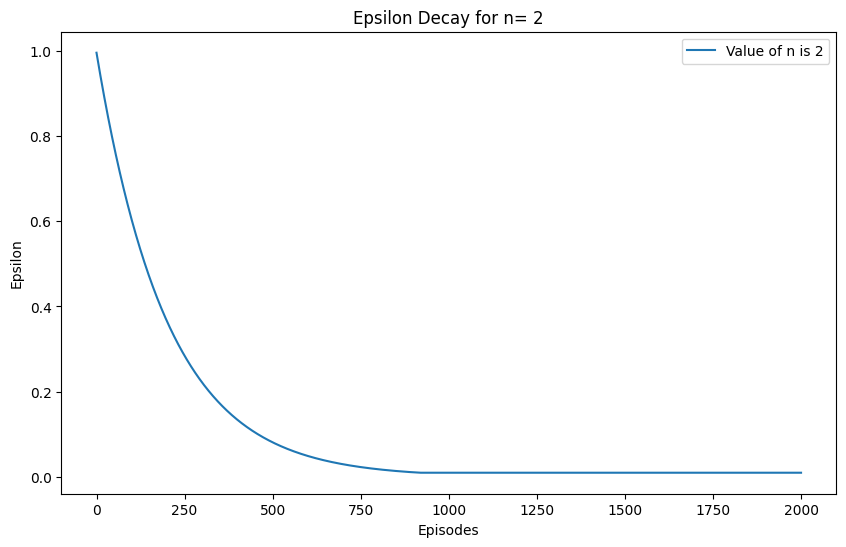

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
→ → ↓ . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
→ → ↓ . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
→ → ↓ . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
→ → ↓ . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
→ → ↓ . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
→ → ↓ . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
→ → ↓ . . .
. → ← . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

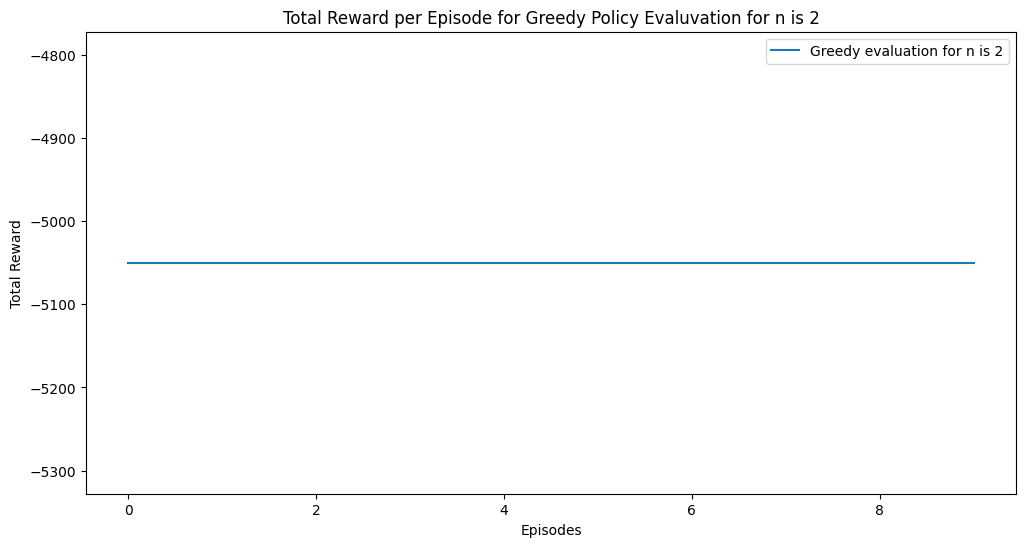

N value is -  3
Episode 100/2000, Total Reward: -153, Epsilon: 0.6058
Episode 200/2000, Total Reward: -1101, Epsilon: 0.3670
Episode 300/2000, Total Reward: -165, Epsilon: 0.2223
Episode 400/2000, Total Reward: -28, Epsilon: 0.1347
Episode 500/2000, Total Reward: -465, Epsilon: 0.0816
Episode 600/2000, Total Reward: -15, Epsilon: 0.0494
Episode 700/2000, Total Reward: -15, Epsilon: 0.0299
Episode 800/2000, Total Reward: -28, Epsilon: 0.0181
Episode 900/2000, Total Reward: -15, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1900/2

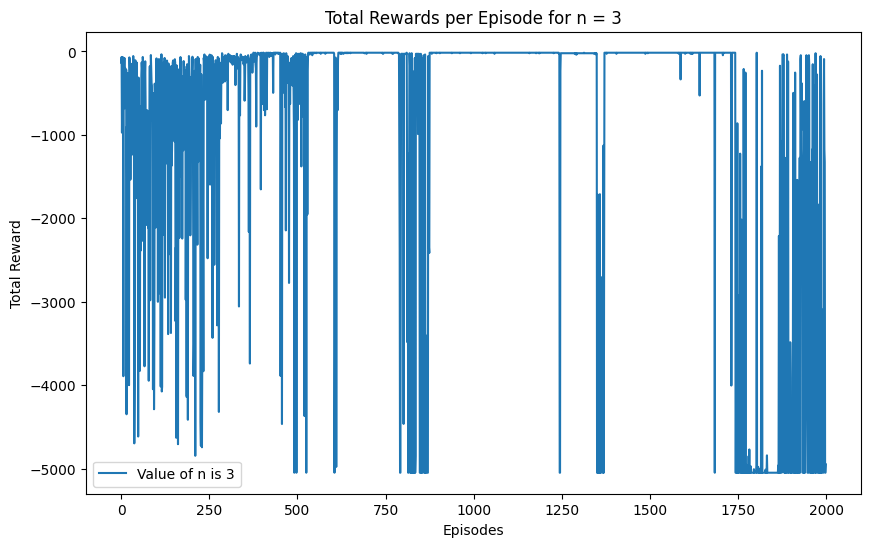

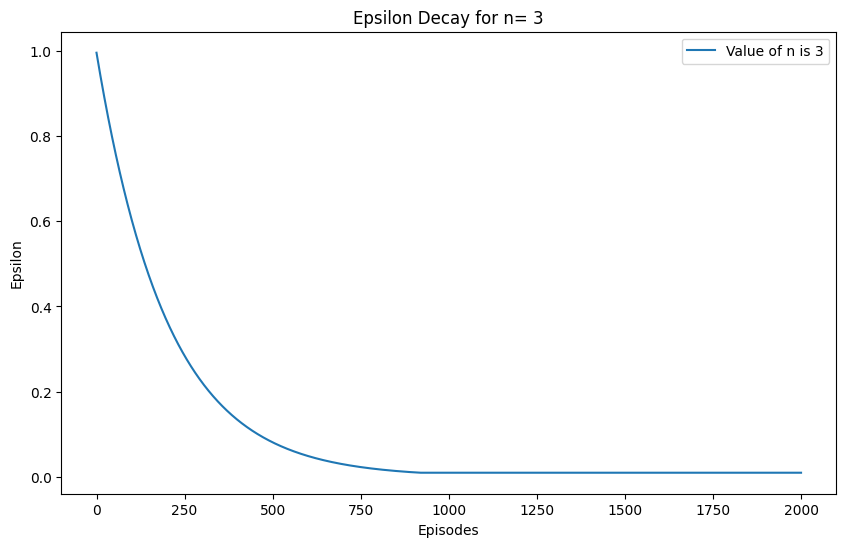

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ← .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ← .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ← .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ← .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ← .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ← .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↓ . . .
. . ↘ . . .
. . . → ← .
. . . . . .


Greedy Evaluation 

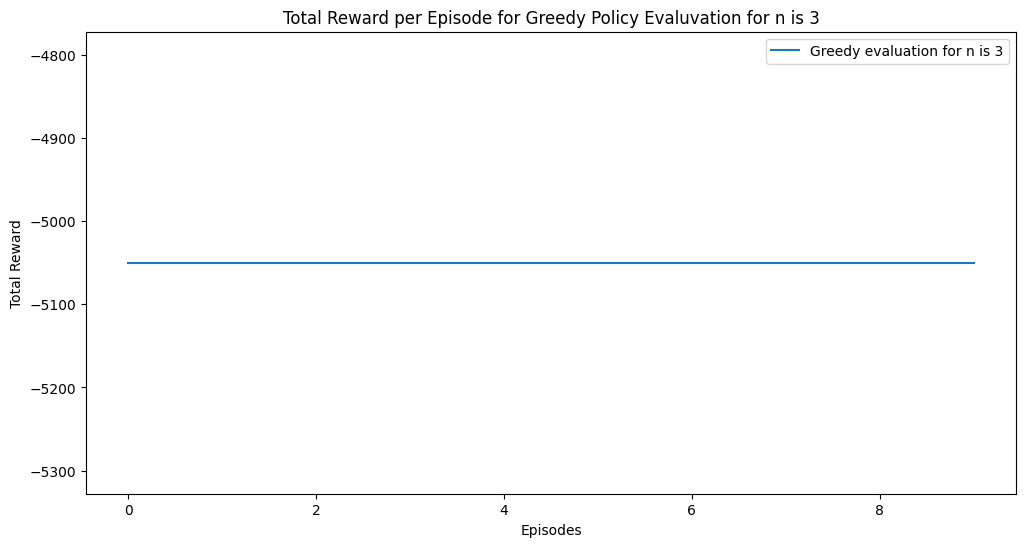

N value is -  4
Episode 100/2000, Total Reward: -29, Epsilon: 0.6058
Episode 200/2000, Total Reward: -105, Epsilon: 0.3670
Episode 300/2000, Total Reward: -5050, Epsilon: 0.2223
Episode 400/2000, Total Reward: -4994, Epsilon: 0.1347
Episode 500/2000, Total Reward: -233, Epsilon: 0.0816
Episode 600/2000, Total Reward: -28, Epsilon: 0.0494
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0299
Episode 800/2000, Total Reward: -28, Epsilon: 0.0181
Episode 900/2000, Total Reward: -28, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5005, Epsilon: 0.0100
Episo

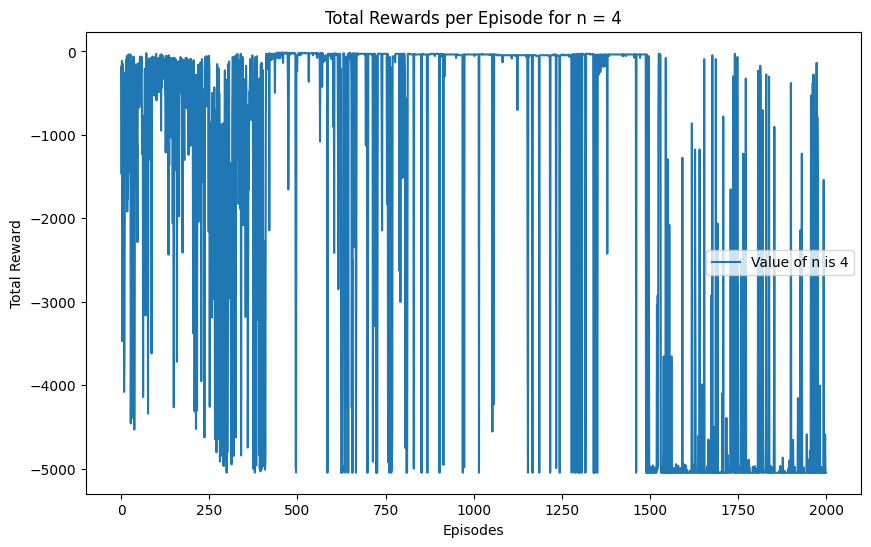

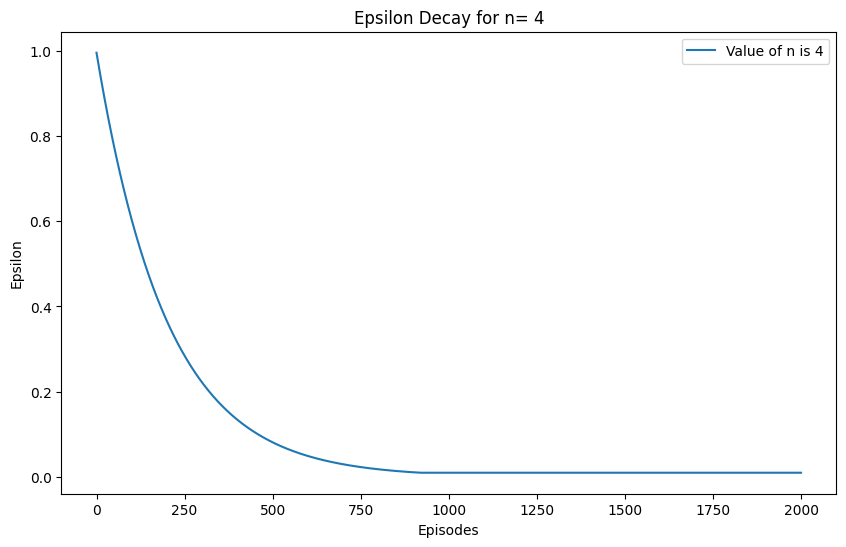

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↘ . . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↘ . . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↘ . . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↘ . . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↘ . . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↘ . . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
. ↘ . . . .
. . → ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation 

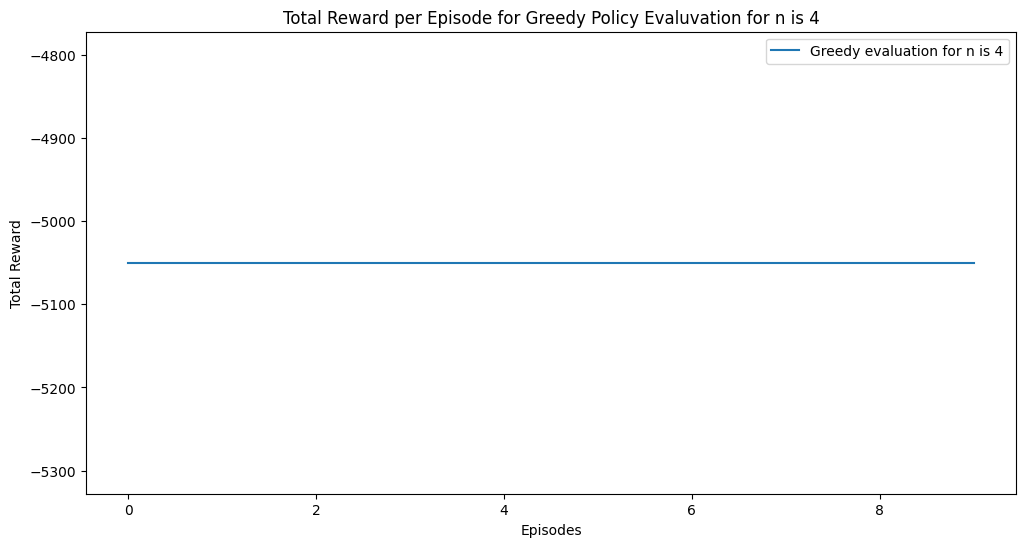

N value is -  5
Episode 100/2000, Total Reward: -76, Epsilon: 0.6058
Episode 200/2000, Total Reward: -783, Epsilon: 0.3670
Episode 300/2000, Total Reward: -210, Epsilon: 0.2223
Episode 400/2000, Total Reward: -4918, Epsilon: 0.1347
Episode 500/2000, Total Reward: -78, Epsilon: 0.0816
Episode 600/2000, Total Reward: -45, Epsilon: 0.0494
Episode 700/2000, Total Reward: -4974, Epsilon: 0.0299
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0181
Episode 900/2000, Total Reward: -231, Epsilon: 0.0110
Episode 1000/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -36, Epsilon: 0.0100
Episode 

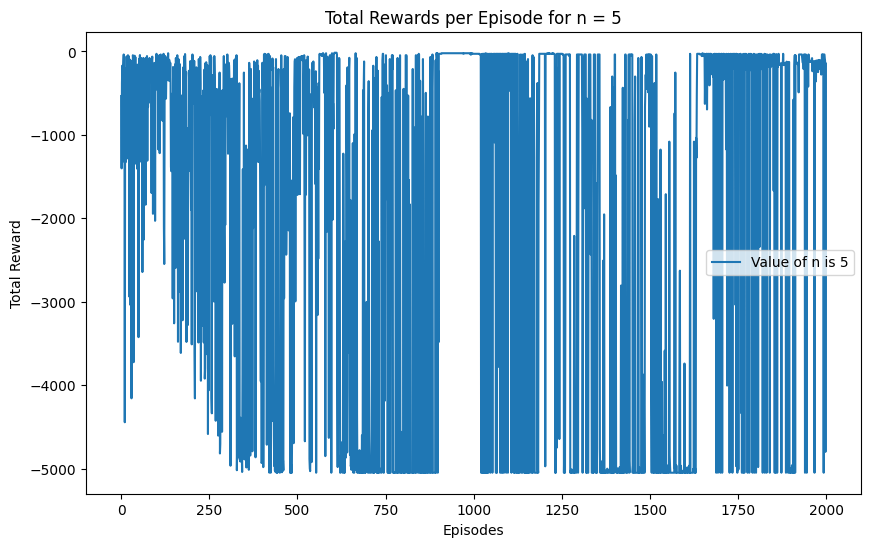

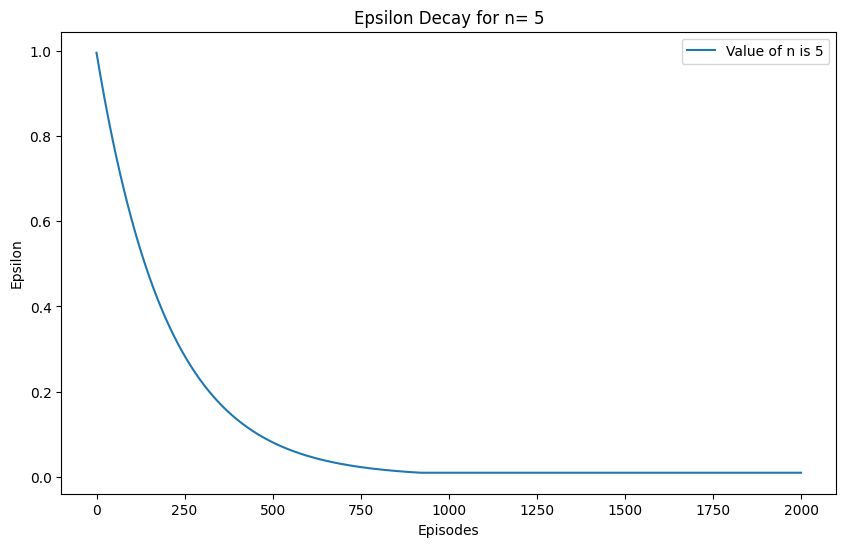

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -585
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . → ↓ .
. . . . ↘ .
. . . . . ↘
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -585
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . → ↓ .
. . . . ↘ .
. . . . . ↘
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -585
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . → ↓ .
. . . . ↘ .
. . . . . ↘
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -585
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . → ↓ .
. . . . ↘ .
. . . . . ↘
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -585
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . → ↓ .
. . . . ↘ .
. . . . . ↘
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -585
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . → ↓ .
. . . . ↘ .
. . . . . ↘
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -585
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . → ↓ .
. . . . ↘ .
. . . . . ↘
. . . . . .


Greedy Evaluation Episode

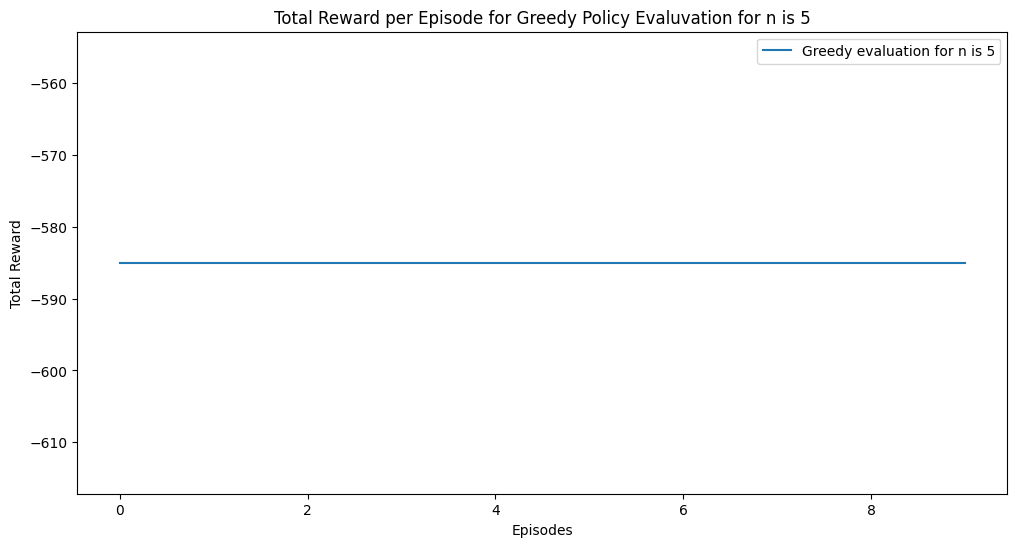

In [18]:
env = GridWorld()
discount = 0.99
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 2000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 3 - Epsilon Decay Rate - Attempt 1

N value is -  1
Episode 100/2000, Total Reward: -45, Epsilon: 0.0100
Episode 200/2000, Total Reward: -45, Epsilon: 0.0100
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5029, Epsilon: 0.0100
Episode 900/2000, Total Reward: -4993, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -4979, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -3160, Epsil

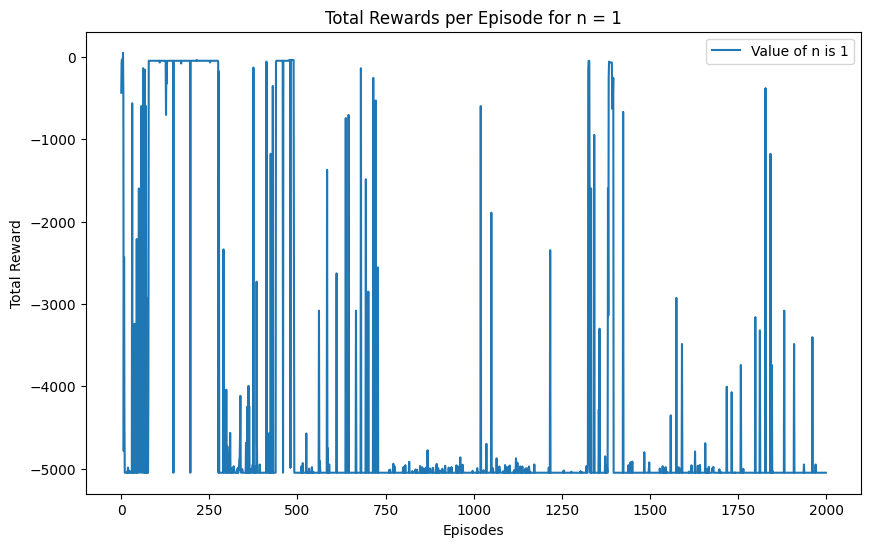

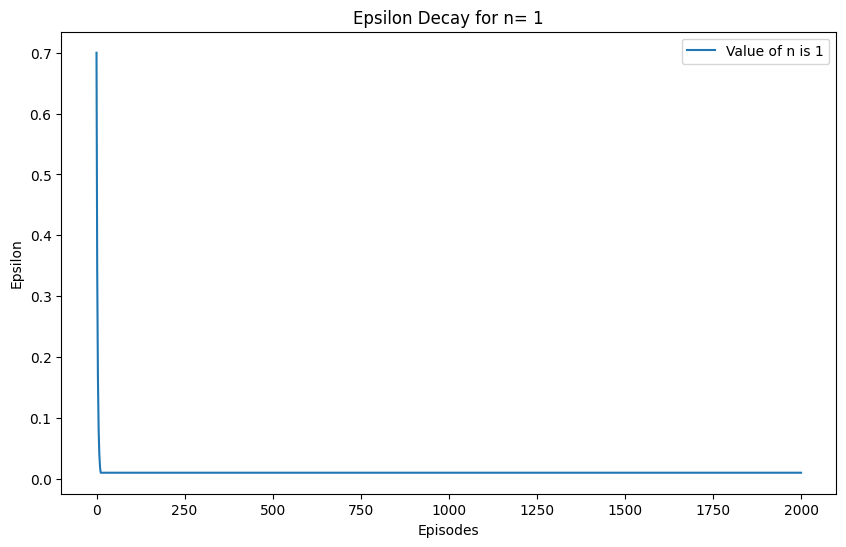

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ → ↓ . . .
. ↑ ← . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ → ↓ . . .
. ↑ ← . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ → ↓ . . .
. ↑ ← . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ → ↓ . . .
. ↑ ← . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ → ↓ . . .
. ↑ ← . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ → ↓ . . .
. ↑ ← . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ → ↓ . . .
. ↑ ← . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

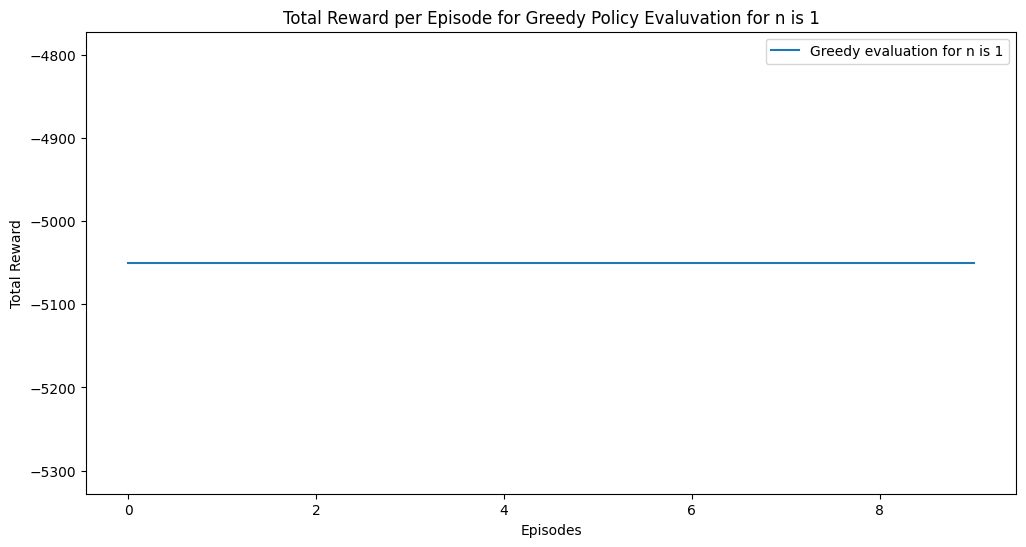

N value is -  2
Episode 100/2000, Total Reward: -66, Epsilon: 0.0100
Episode 200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -378, Epsilon: 0.0100
Episode 500/2000, Total Reward: -45, Epsilon: 0.0100
Episode 600/2000, Total Reward: -45, Epsilon: 0.0100
Episode 700/2000, Total Reward: -45, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5023, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5026, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -1136, Epsilon: 0.010

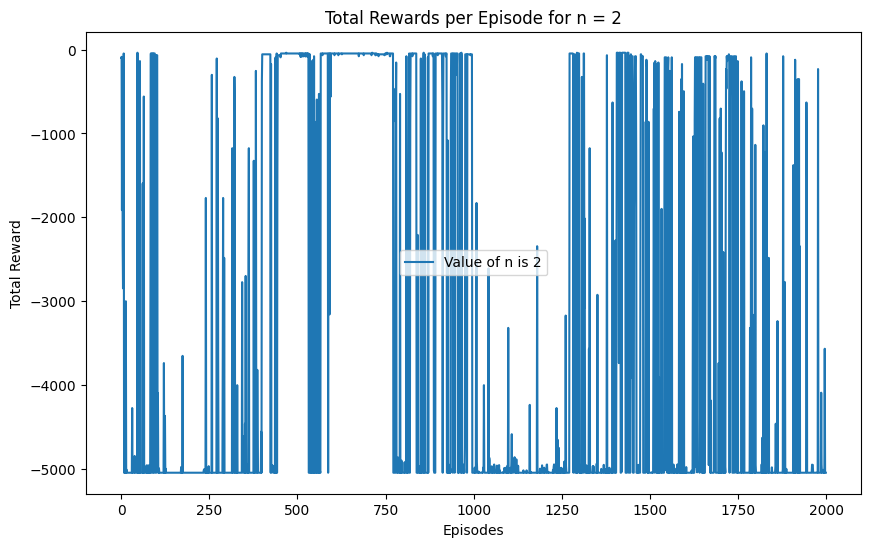

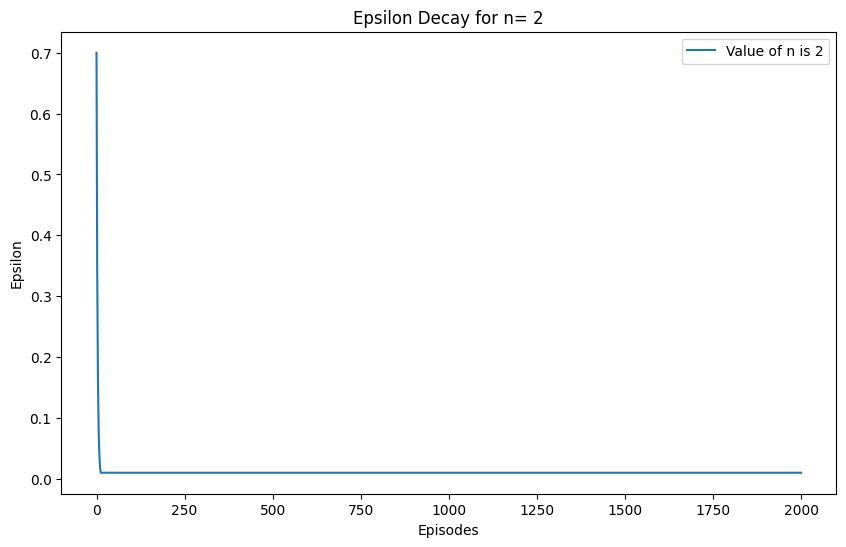

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. → → ↘ . .
. . . ↓ ← .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. → → ↘ . .
. . . ↓ ← .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. → → ↘ . .
. . . ↓ ← .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. → → ↘ . .
. . . ↓ ← .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. → → ↘ . .
. . . ↓ ← .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. → → ↘ . .
. . . ↓ ← .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. → → ↘ . .
. . . ↓ ← .
. . → ← . .
. . . . . .
. . . . . .


Greedy Evaluation 

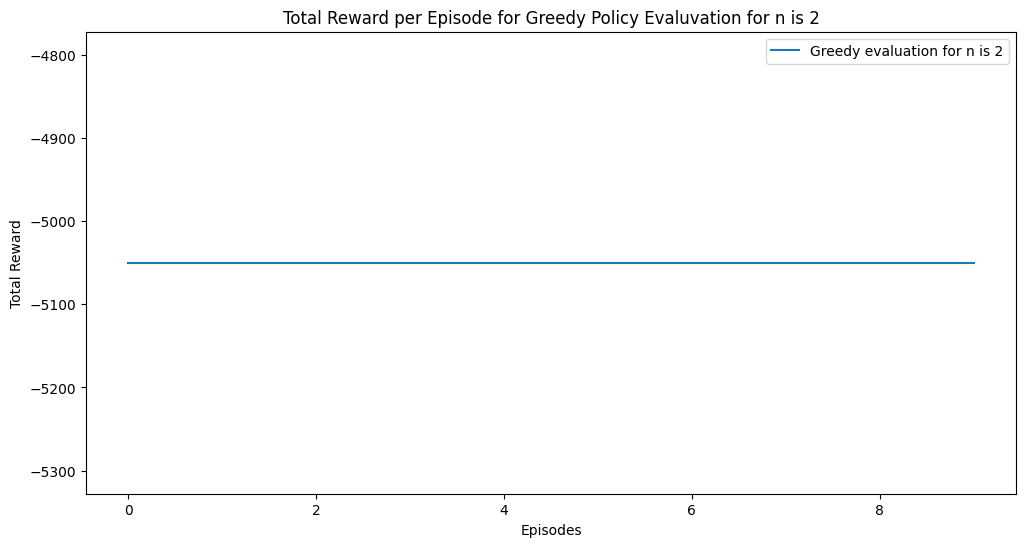

N value is -  3
Episode 100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -91, Epsilon: 0.0100
Episode 600/2000, Total Reward: -55, Epsilon: 0.0100
Episode 700/2000, Total Reward: -55, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -206, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -114, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -98, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -4684, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -153, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -66, Epsilon: 0.010

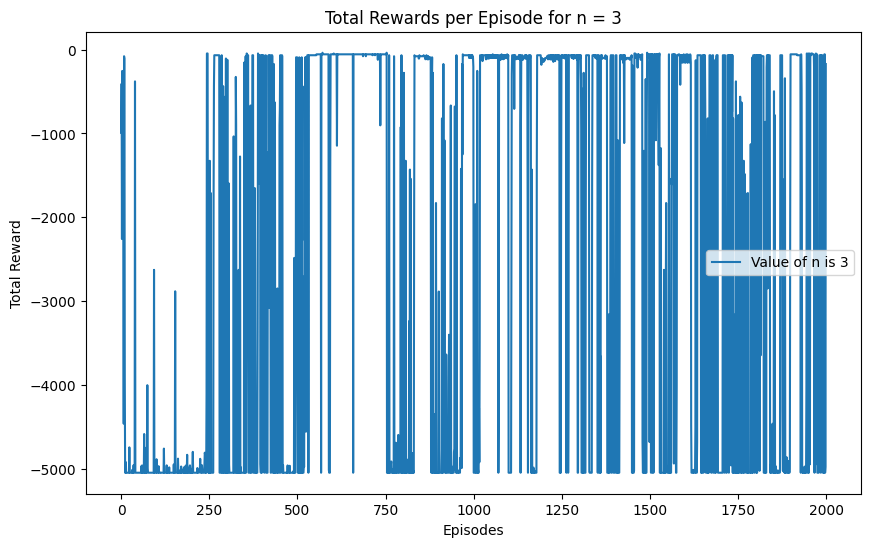

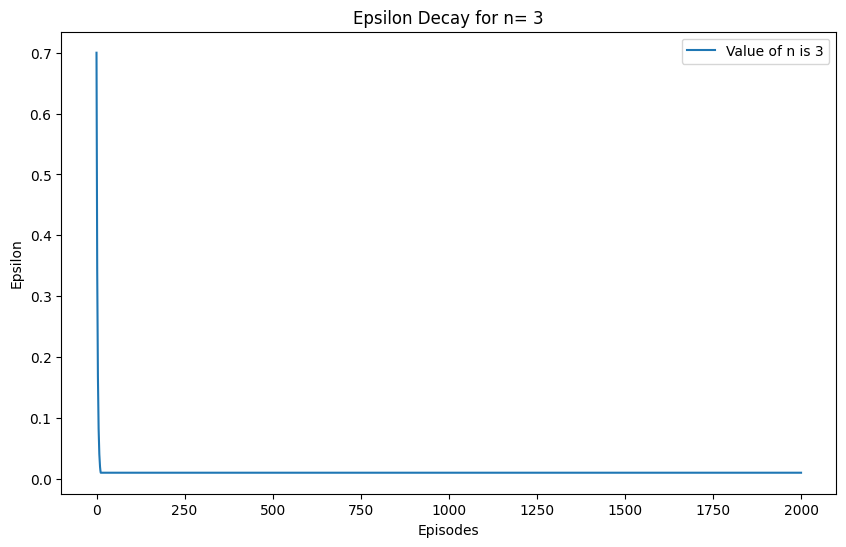

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
↓ ← . . . .
↘ ↑ . . . .
. ↑ . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
↓ ← . . . .
↘ ↑ . . . .
. ↑ . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
↓ ← . . . .
↘ ↑ . . . .
. ↑ . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
↓ ← . . . .
↘ ↑ . . . .
. ↑ . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
↓ ← . . . .
↘ ↑ . . . .
. ↑ . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
↓ ← . . . .
↘ ↑ . . . .
. ↑ . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . . .
. ↓ . . . .
↓ ← . . . .
↘ ↑ . . . .
. ↑ . . . .
. . . . . .


Greedy Evaluation 

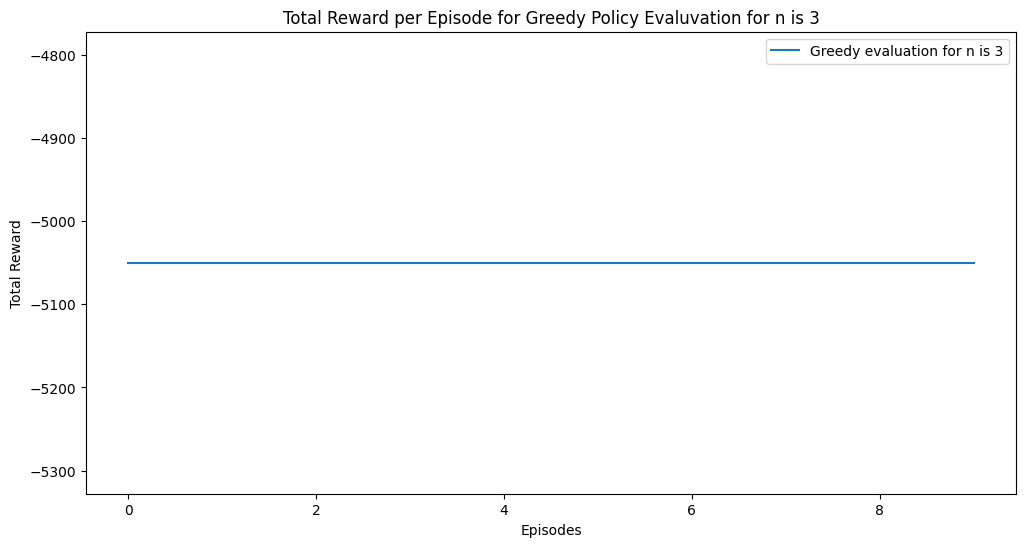

N value is -  4
Episode 100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 200/2000, Total Reward: -4999, Epsilon: 0.0100
Episode 300/2000, Total Reward: -869, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -864, Epsilon: 0.0100
Episode 600/2000, Total Reward: -983, Epsilon: 0.0100
Episode 700/2000, Total Reward: -4955, Epsilon: 0.0100
Episode 800/2000, Total Reward: -2842, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -91, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -351, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -4971, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -45, Epsilon: 0.0100

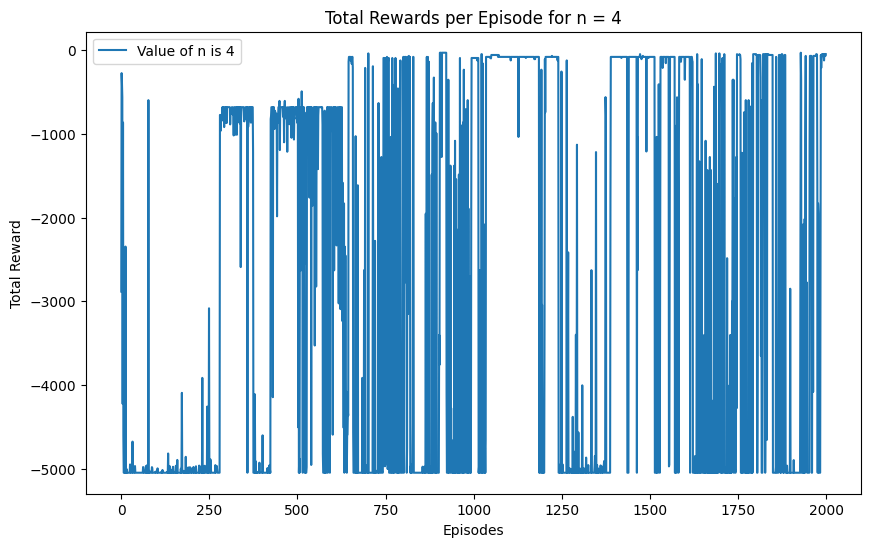

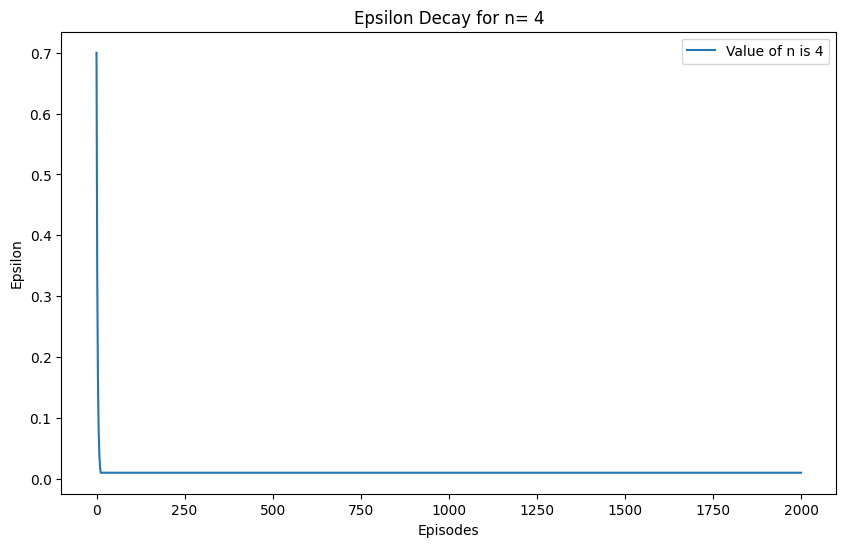

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -45
Action Grid:
↓ . . . . .
→ → ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 2: Total Reward = -45
Action Grid:
↓ . . . . .
→ → ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 3: Total Reward = -45
Action Grid:
↓ . . . . .
→ → ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 4: Total Reward = -45
Action Grid:
↓ . . . . .
→ → ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 5: Total Reward = -45
Action Grid:
↓ . . . . .
→ → ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 6: Total Reward = -45
Action Grid:
↓ . . . . .
→ → ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 7: Total Reward = -45
Action Grid:
↓ . . . . .
→ → ↘ . . .
. . . ↓ . .
. . . → ↓ .
. . . . ↓ .
. . . . → .


Greedy Evaluation Episode 8: Tot

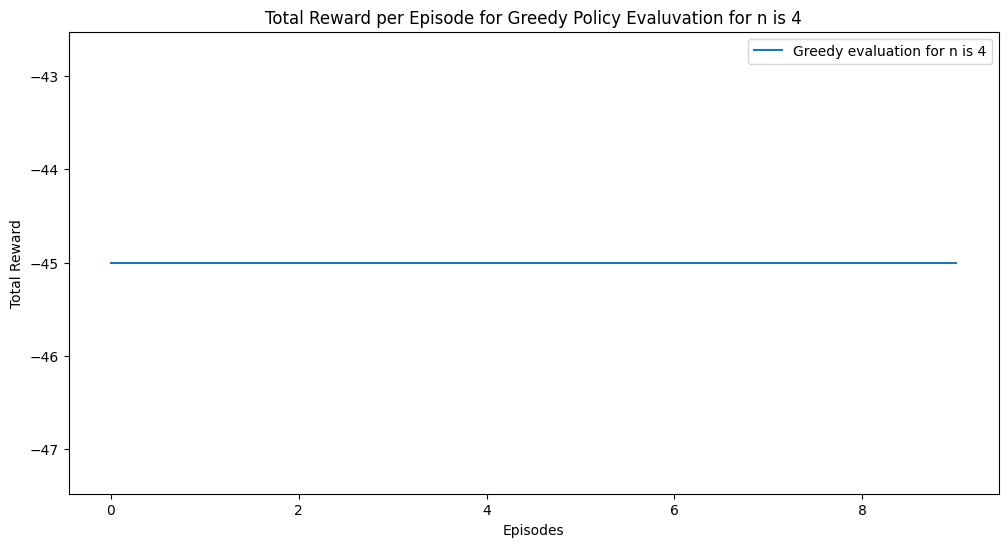

N value is -  5
Episode 100/2000, Total Reward: -2588, Epsilon: 0.0100
Episode 200/2000, Total Reward: -105, Epsilon: 0.0100
Episode 300/2000, Total Reward: -91, Epsilon: 0.0100
Episode 400/2000, Total Reward: -136, Epsilon: 0.0100
Episode 500/2000, Total Reward: -105, Epsilon: 0.0100
Episode 600/2000, Total Reward: -91, Epsilon: 0.0100
Episode 700/2000, Total Reward: -91, Epsilon: 0.0100
Episode 800/2000, Total Reward: -4582, Epsilon: 0.0100
Episode 900/2000, Total Reward: -136, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -91, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -4959, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -4005, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -78, Epsilon: 0.0100
Episo

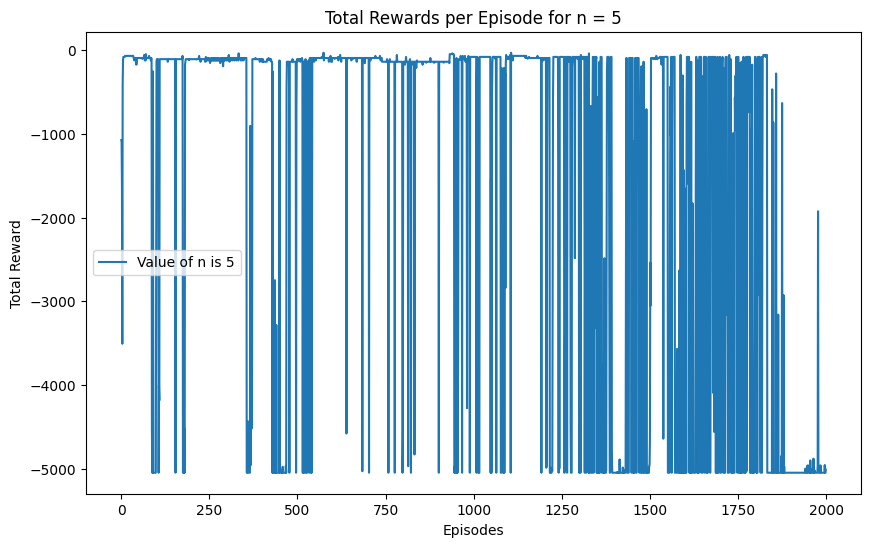

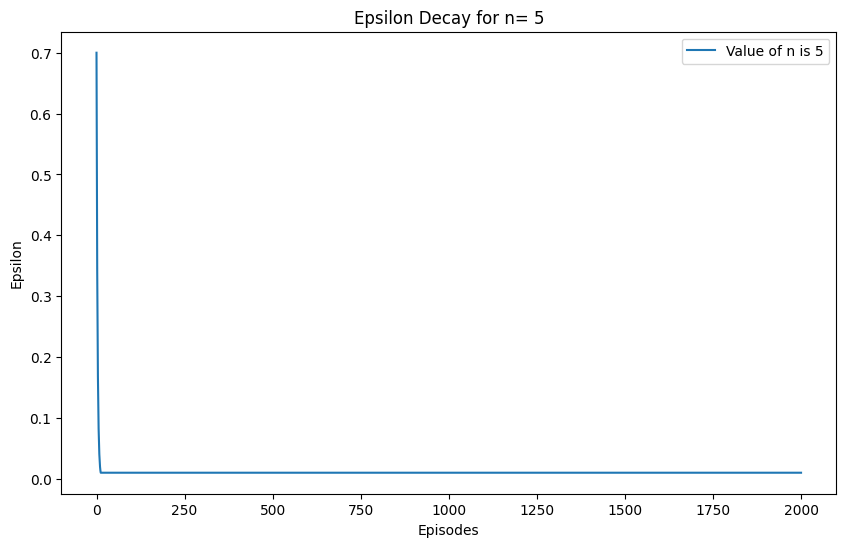

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↘ . . . ↓ ←
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↘ . . . ↓ ←
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↘ . . . ↓ ←
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↘ . . . ↓ ←
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↘ . . . ↓ ←
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↘ . . . ↓ ←
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↘ . . . ↓ ←
. → ↘ . → ↑
. . . → ↑ .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

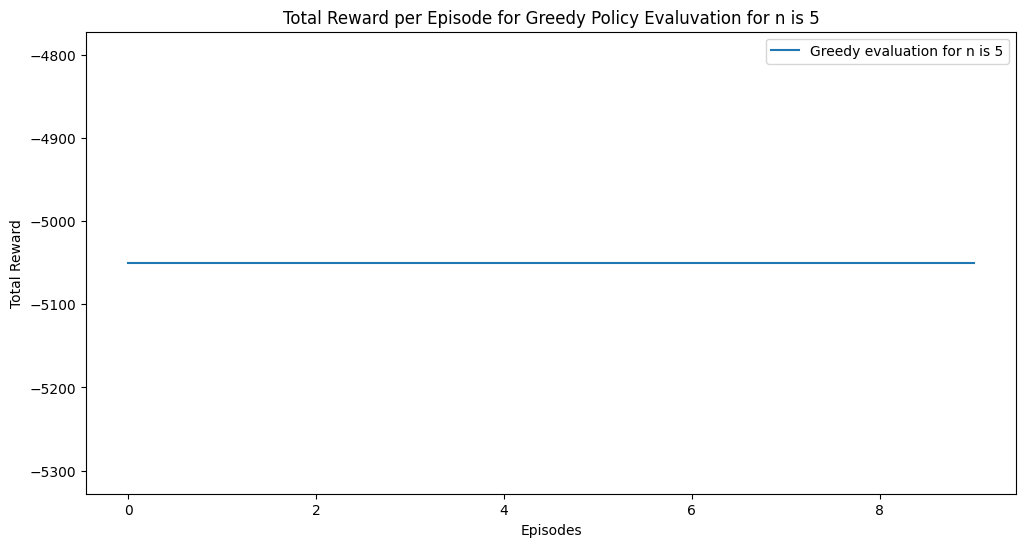

In [19]:
env = GridWorld()
discount = 0.95
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.70
episodes = 2000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 3 - Epsilon Decay Rate - Attempt 2

N value is -  1
Episode 100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 200/2000, Total Reward: -4756, Epsilon: 0.0100
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -4188, Epsilon: 0.0100
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -946, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -4950, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -36, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -1135, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -4789, Epsilon: 0.0100
Episode 1600/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -4560, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -4186, Epsilon: 0

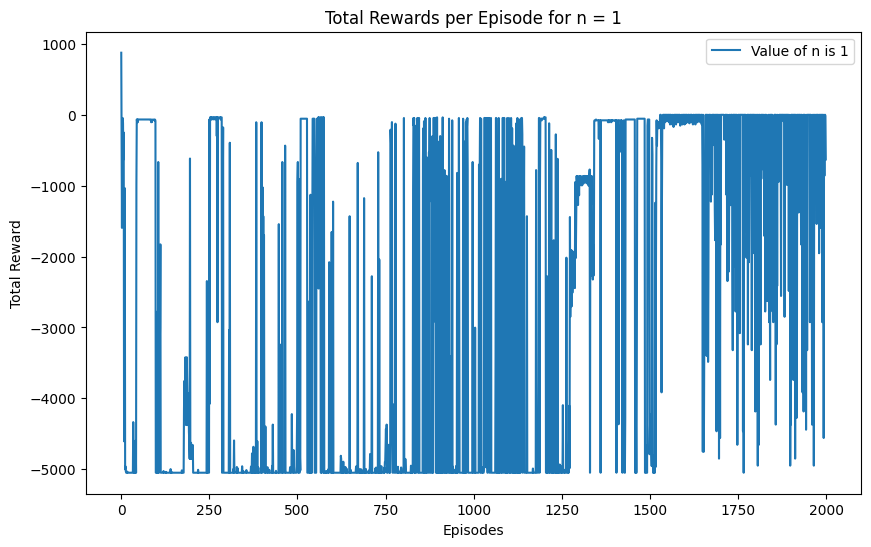

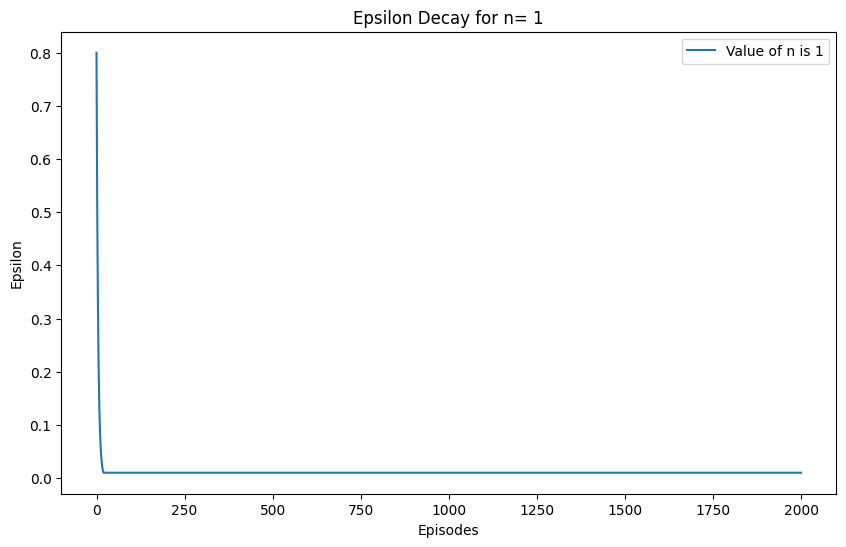

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 8: Total Reward = 0


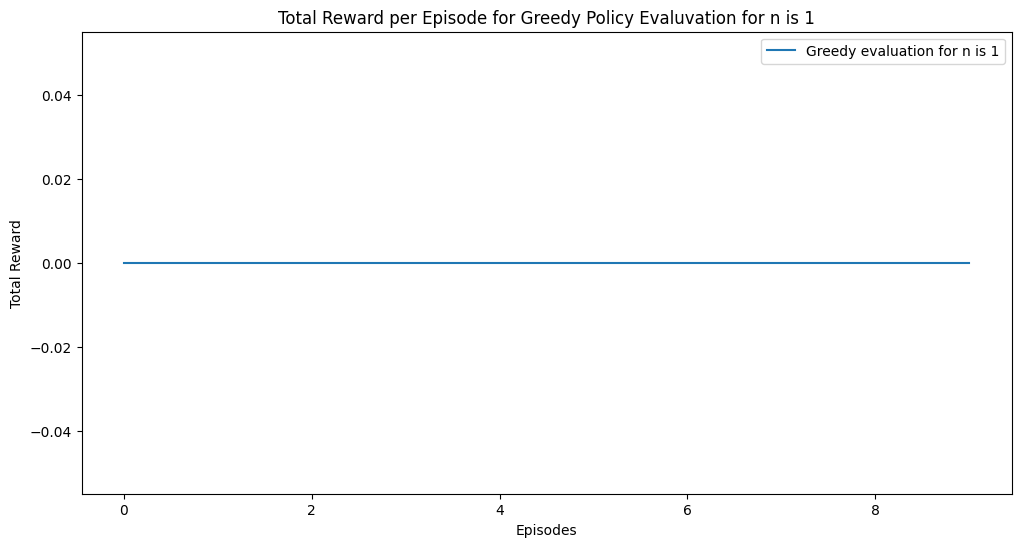

N value is -  2
Episode 100/2000, Total Reward: -55, Epsilon: 0.0100
Episode 200/2000, Total Reward: -55, Epsilon: 0.0100
Episode 300/2000, Total Reward: -55, Epsilon: 0.0100
Episode 400/2000, Total Reward: -55, Epsilon: 0.0100
Episode 500/2000, Total Reward: -55, Epsilon: 0.0100
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5031, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5022, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -4465, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -36, Epsilon: 0.0100

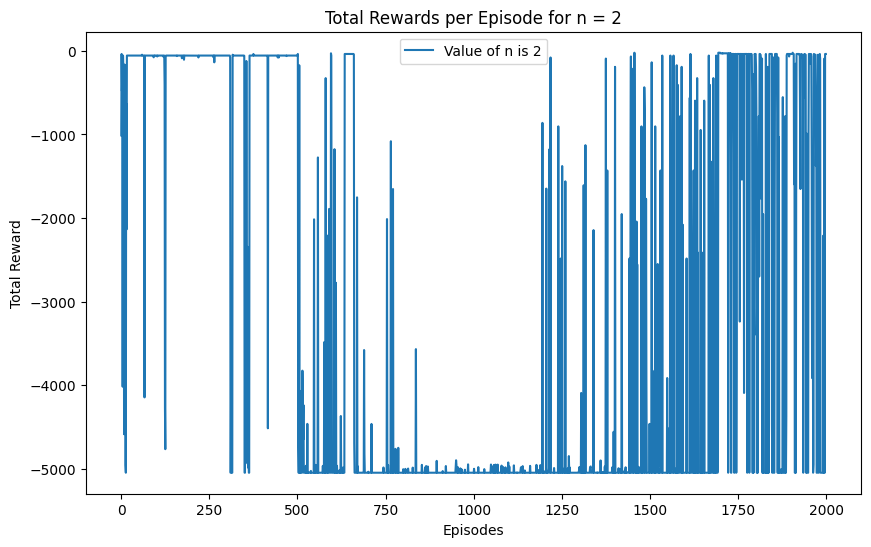

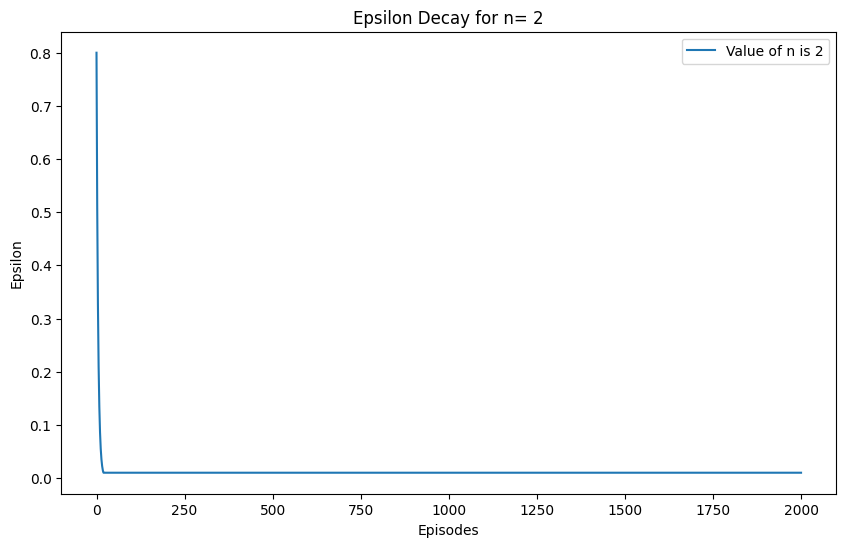

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -36
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↓ ←
. . . . → .


Greedy Evaluation Episode 2: Total Reward = -36
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↓ ←
. . . . → .


Greedy Evaluation Episode 3: Total Reward = -36
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↓ ←
. . . . → .


Greedy Evaluation Episode 4: Total Reward = -36
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↓ ←
. . . . → .


Greedy Evaluation Episode 5: Total Reward = -36
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↓ ←
. . . . → .


Greedy Evaluation Episode 6: Total Reward = -36
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↓ ←
. . . . → .


Greedy Evaluation Episode 7: Total Reward = -36
Action Grid:
→ ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . ↓ ←
. . . . → .


Greedy Evaluation Episode 8: Tot

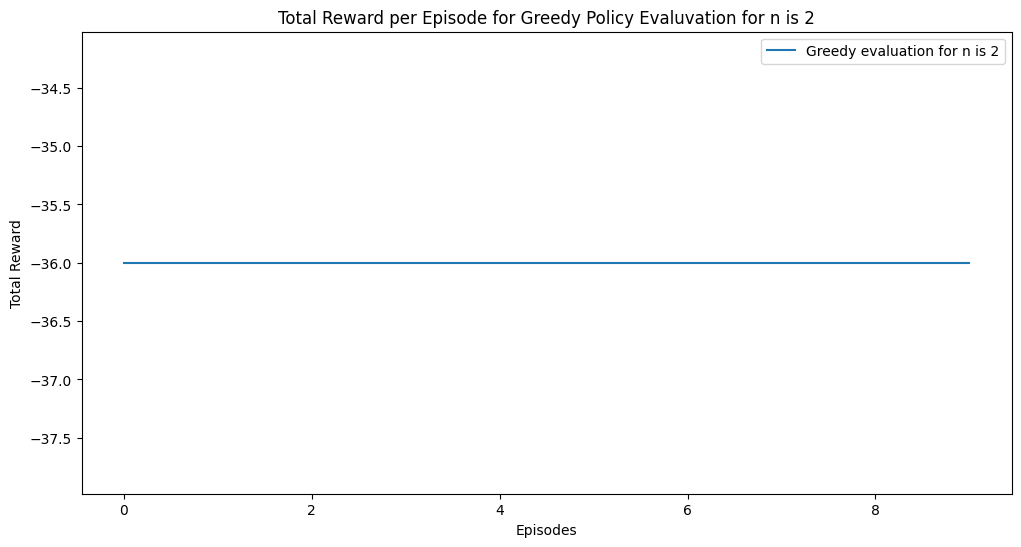

N value is -  3
Episode 100/2000, Total Reward: -66, Epsilon: 0.0100
Episode 200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 600/2000, Total Reward: -87, Epsilon: 0.0100
Episode 700/2000, Total Reward: -1653, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -105, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -4997, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0

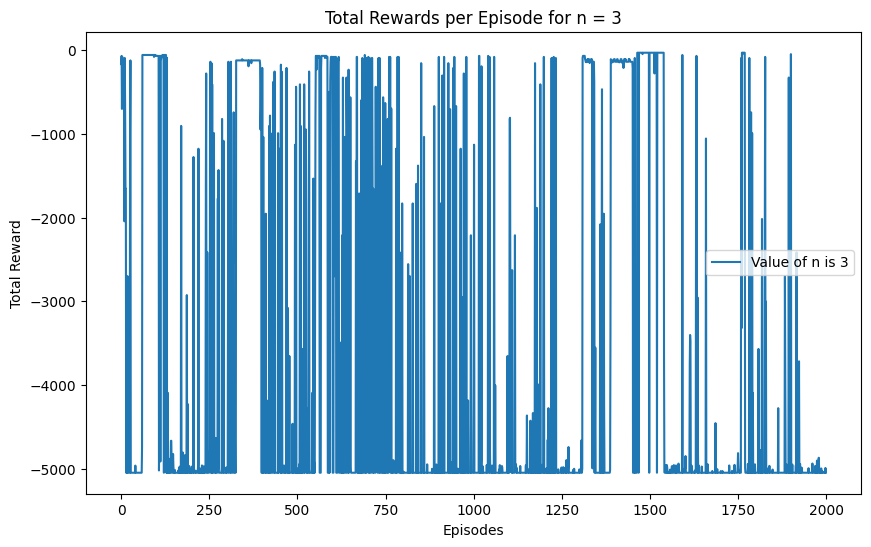

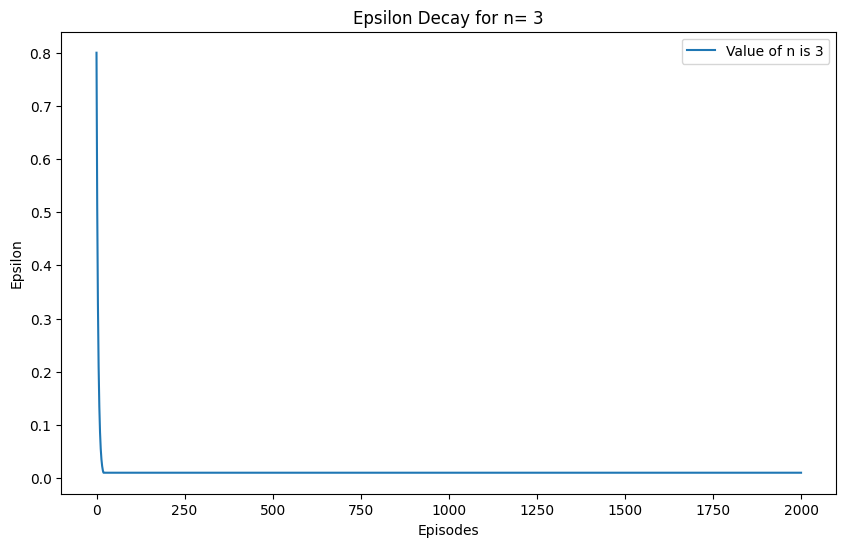

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . . .
↓ ← . . . .
↘ . . . . .
→ ↓ . . . .
↑ ← . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . . .
↓ ← . . . .
↘ . . . . .
→ ↓ . . . .
↑ ← . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . . .
↓ ← . . . .
↘ . . . . .
→ ↓ . . . .
↑ ← . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . . .
↓ ← . . . .
↘ . . . . .
→ ↓ . . . .
↑ ← . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . . .
↓ ← . . . .
↘ . . . . .
→ ↓ . . . .
↑ ← . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . . .
↓ ← . . . .
↘ . . . . .
→ ↓ . . . .
↑ ← . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . . .
↓ ← . . . .
↘ . . . . .
→ ↓ . . . .
↑ ← . . . .


Greedy Evaluation 

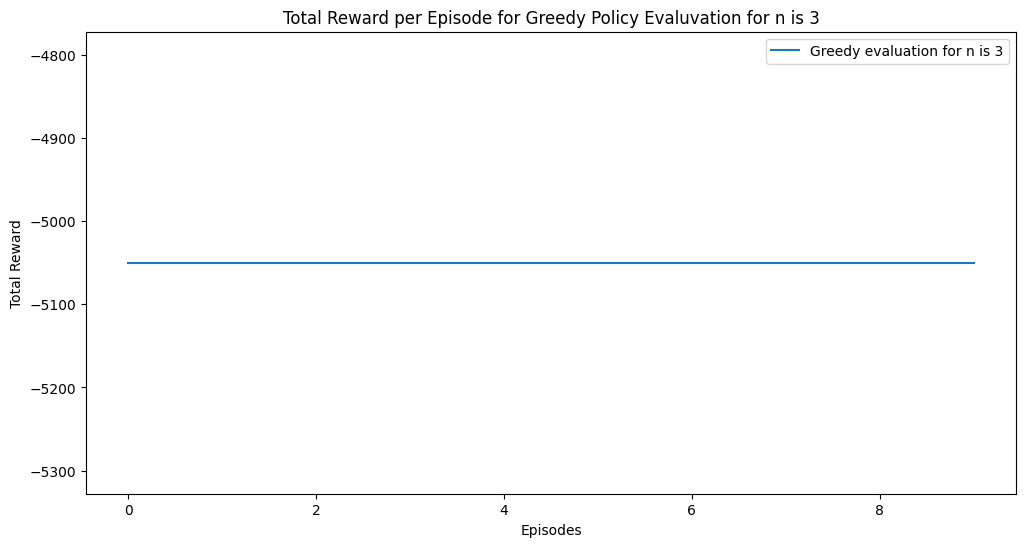

N value is -  4
Episode 100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -4959, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5031, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -190, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.0

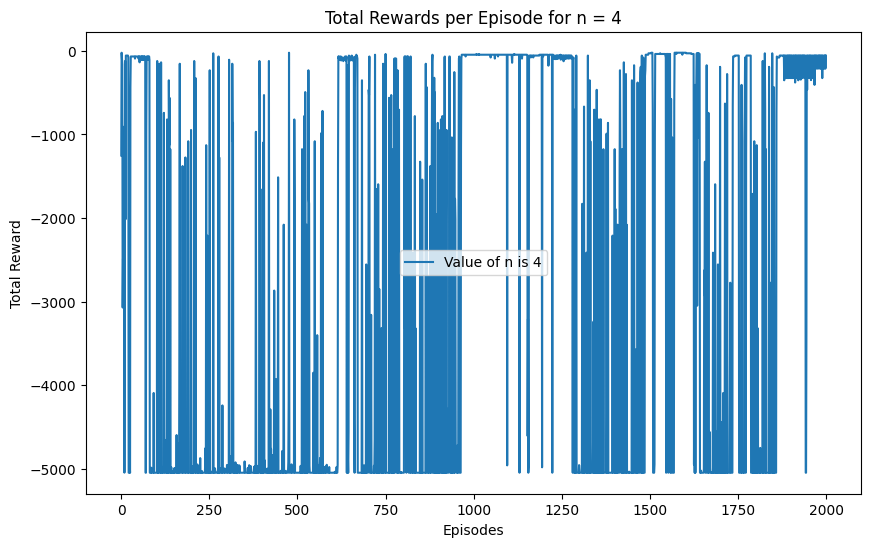

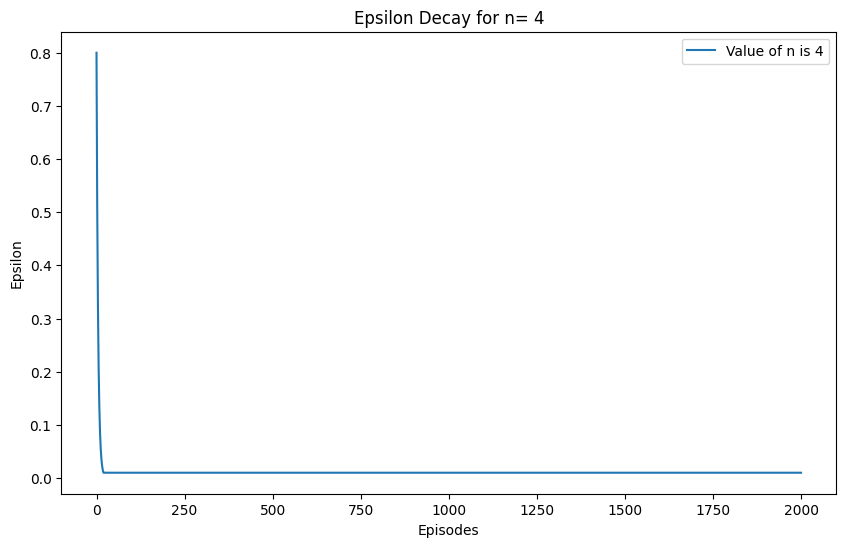

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -55
Action Grid:
↓ . . . . .
↓ . . . . .
↓ . . . . .
↘ . → ↘ . .
. → ↑ . ↓ .
. . . . → .


Greedy Evaluation Episode 2: Total Reward = -55
Action Grid:
↓ . . . . .
↓ . . . . .
↓ . . . . .
↘ . → ↘ . .
. → ↑ . ↓ .
. . . . → .


Greedy Evaluation Episode 3: Total Reward = -55
Action Grid:
↓ . . . . .
↓ . . . . .
↓ . . . . .
↘ . → ↘ . .
. → ↑ . ↓ .
. . . . → .


Greedy Evaluation Episode 4: Total Reward = -55
Action Grid:
↓ . . . . .
↓ . . . . .
↓ . . . . .
↘ . → ↘ . .
. → ↑ . ↓ .
. . . . → .


Greedy Evaluation Episode 5: Total Reward = -55
Action Grid:
↓ . . . . .
↓ . . . . .
↓ . . . . .
↘ . → ↘ . .
. → ↑ . ↓ .
. . . . → .


Greedy Evaluation Episode 6: Total Reward = -55
Action Grid:
↓ . . . . .
↓ . . . . .
↓ . . . . .
↘ . → ↘ . .
. → ↑ . ↓ .
. . . . → .


Greedy Evaluation Episode 7: Total Reward = -55
Action Grid:
↓ . . . . .
↓ . . . . .
↓ . . . . .
↘ . → ↘ . .
. → ↑ . ↓ .
. . . . → .


Greedy Evaluation Episode 8: Tot

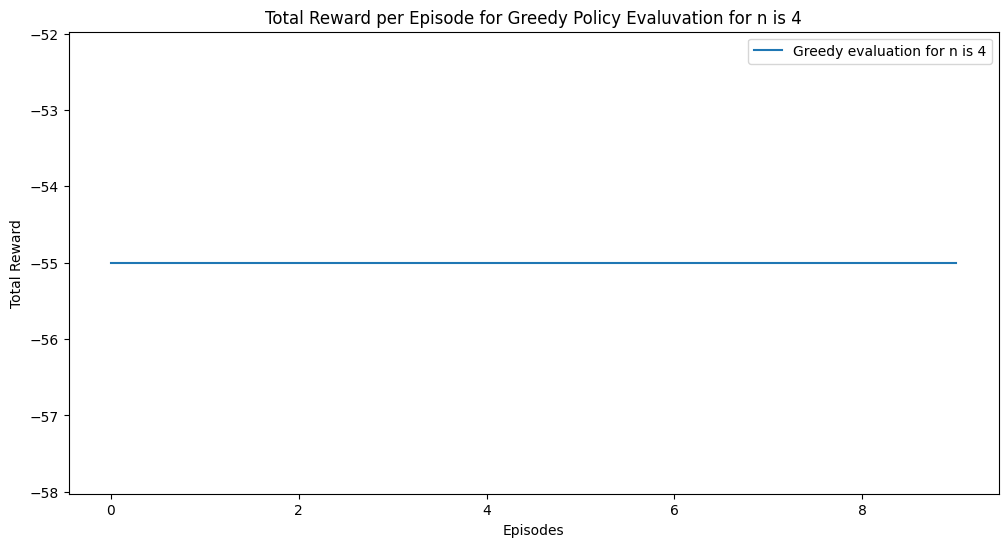

N value is -  5
Episode 100/2000, Total Reward: -45, Epsilon: 0.0100
Episode 200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -181, Epsilon: 0.0100
Episode 500/2000, Total Reward: -66, Epsilon: 0.0100
Episode 600/2000, Total Reward: -66, Epsilon: 0.0100
Episode 700/2000, Total Reward: -5005, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -171, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -955, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0

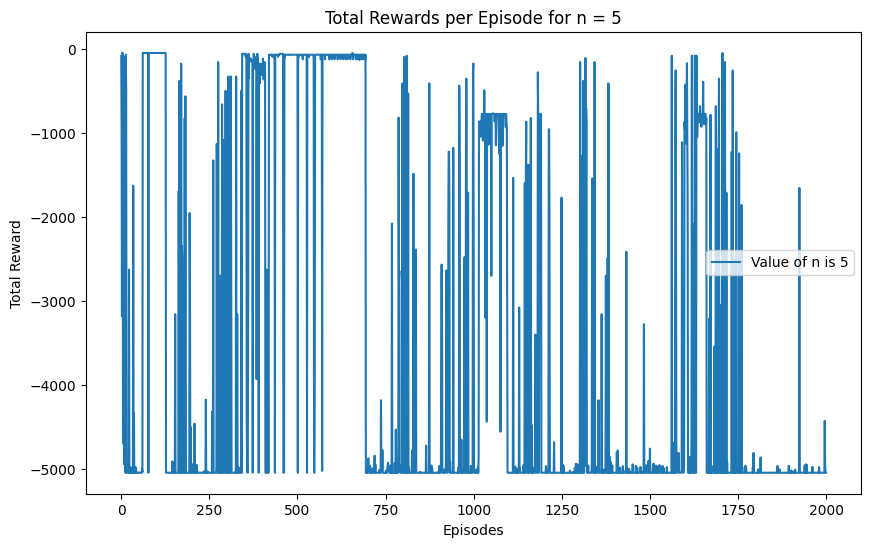

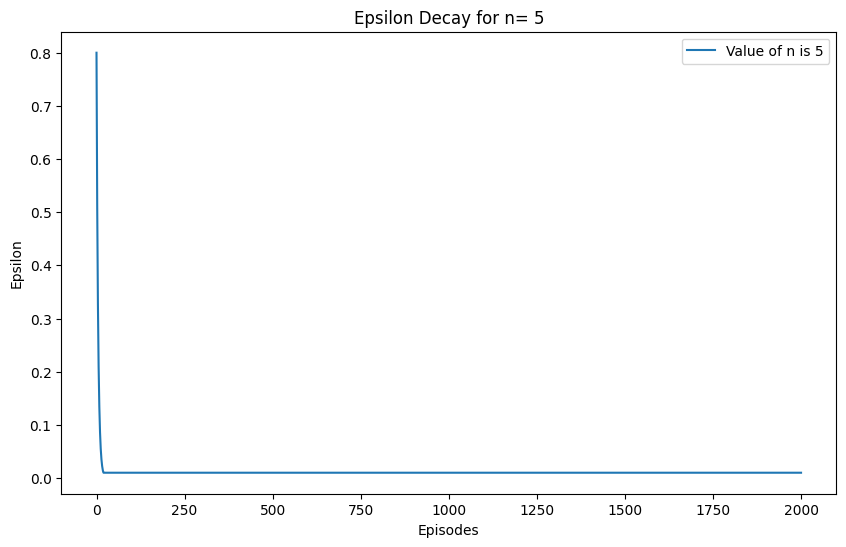

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↘ . . . .
. ↓ ← . . .
→ ← . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↘ . . . .
. ↓ ← . . .
→ ← . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↘ . . . .
. ↓ ← . . .
→ ← . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↘ . . . .
. ↓ ← . . .
→ ← . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↘ . . . .
. ↓ ← . . .
→ ← . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↘ . . . .
. ↓ ← . . .
→ ← . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ . . . . .
→ ↘ . . . .
. ↓ ← . . .
→ ← . . . .
. . . . . .
. . . . . .


Greedy Evaluation 

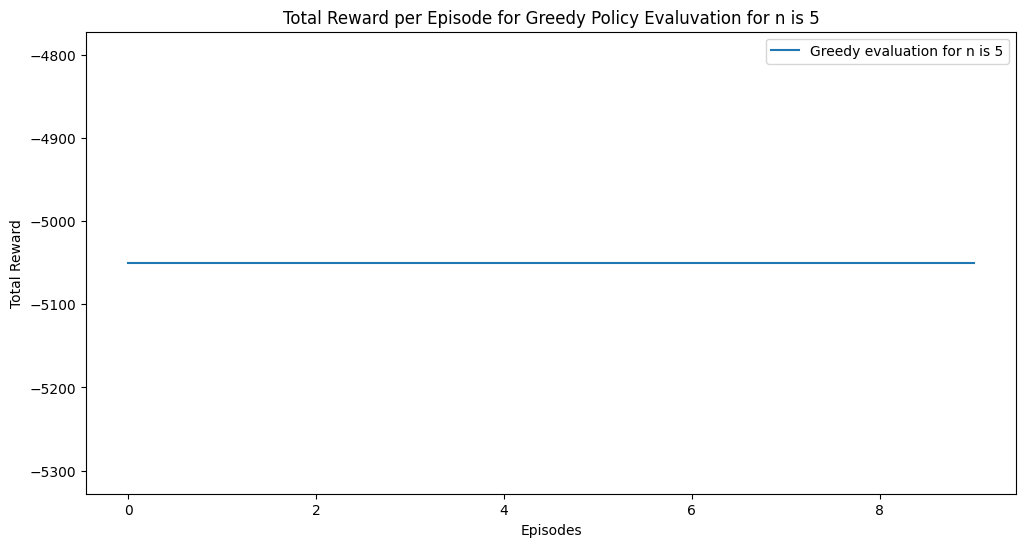

In [20]:
env = GridWorld()
discount = 0.95
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.80
episodes = 2000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Hyperparameter Tuning 3 - Epsilon Decay Rate - Attempt 3

N value is -  1
Episode 100/2000, Total Reward: -2360, Epsilon: 0.1326
Episode 200/2000, Total Reward: -45, Epsilon: 0.0176
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -1275, Epsilon: 0.0100
Episode 500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -178, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -4927, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -4993, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5036, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsi

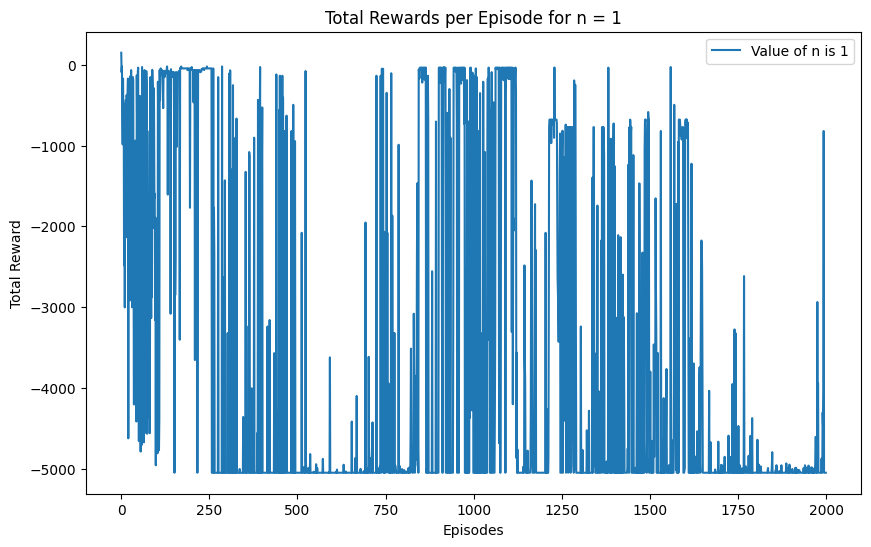

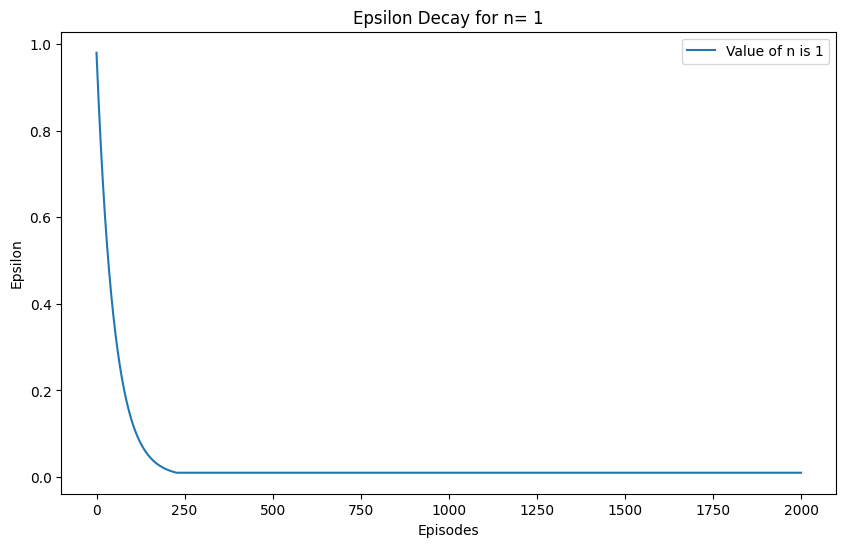

Evaluation for n is 1:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
→ ↘ . . . .
. . → ↓ . .
. . . ↓ . .
. . . ↘ . .
. . . . → ←
. . . . . .


Greedy Evaluation 

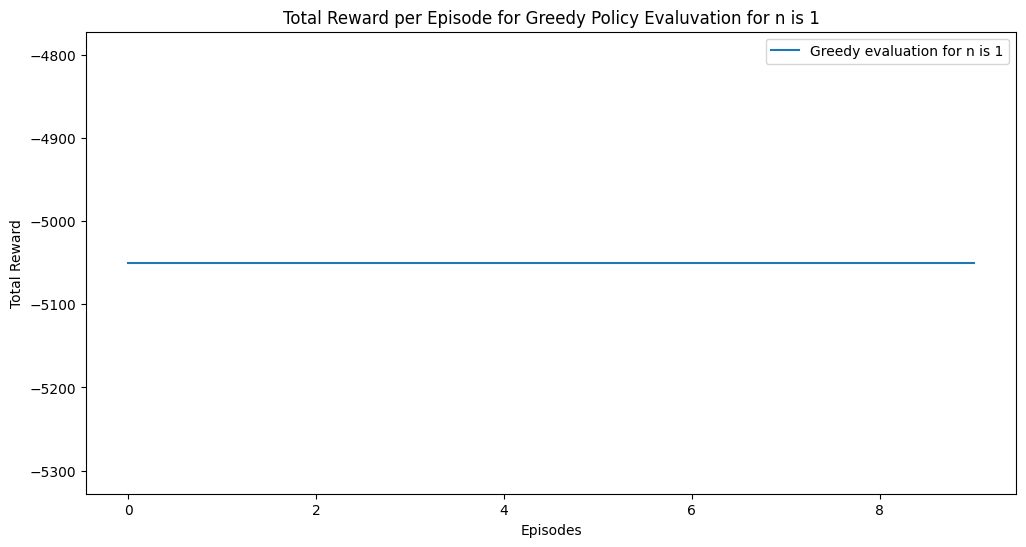

N value is -  2
Episode 100/2000, Total Reward: -66, Epsilon: 0.1326
Episode 200/2000, Total Reward: -5050, Epsilon: 0.0176
Episode 300/2000, Total Reward: -861, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -3802, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -15, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -15, Epsilon: 0.0100
Epis

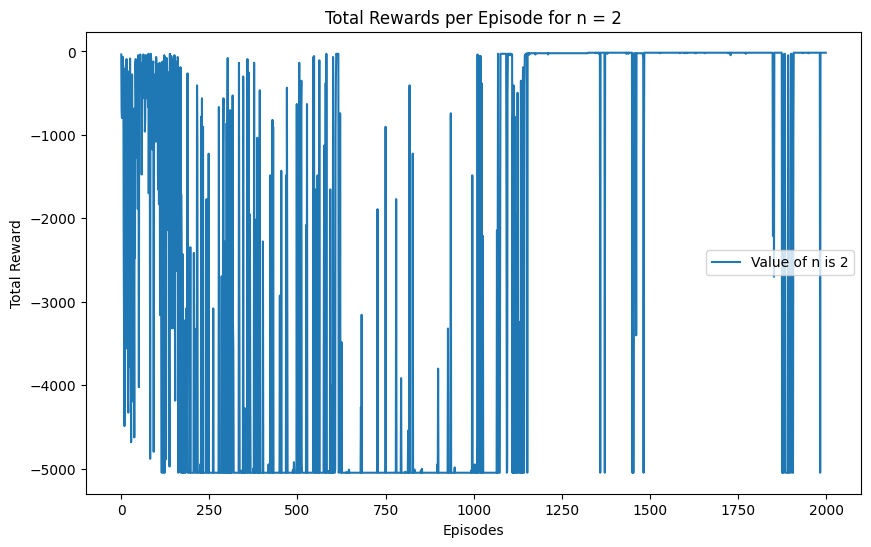

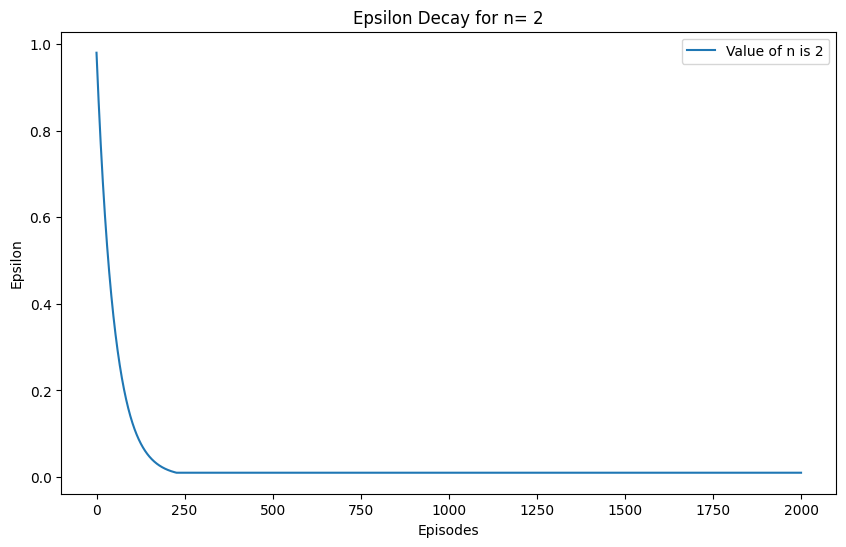

Evaluation for n is 2:
Greedy Evaluation Episode 1: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -15
Action Grid:
↘ . . . . .
. ↘ . . . .
. . ↘ . . .
. . . ↘ . .
. . . . ↘ .
. . . . . .


Greedy Evaluation Episode 8: Tot

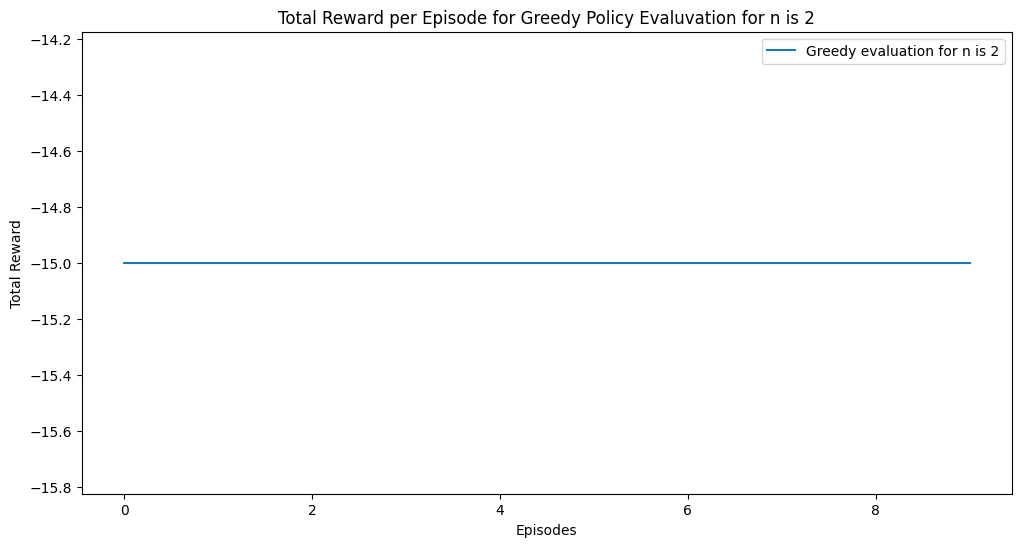

N value is -  3
Episode 100/2000, Total Reward: -21, Epsilon: 0.1326
Episode 200/2000, Total Reward: -2007, Epsilon: 0.0176
Episode 300/2000, Total Reward: -28, Epsilon: 0.0100
Episode 400/2000, Total Reward: -28, Epsilon: 0.0100
Episode 500/2000, Total Reward: -28, Epsilon: 0.0100
Episode 600/2000, Total Reward: -28, Epsilon: 0.0100
Episode 700/2000, Total Reward: -28, Epsilon: 0.0100
Episode 800/2000, Total Reward: -28, Epsilon: 0.0100
Episode 900/2000, Total Reward: -28, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -21, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -3392, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -4967, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -45, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -36, Epsilon: 0.0100
Episode

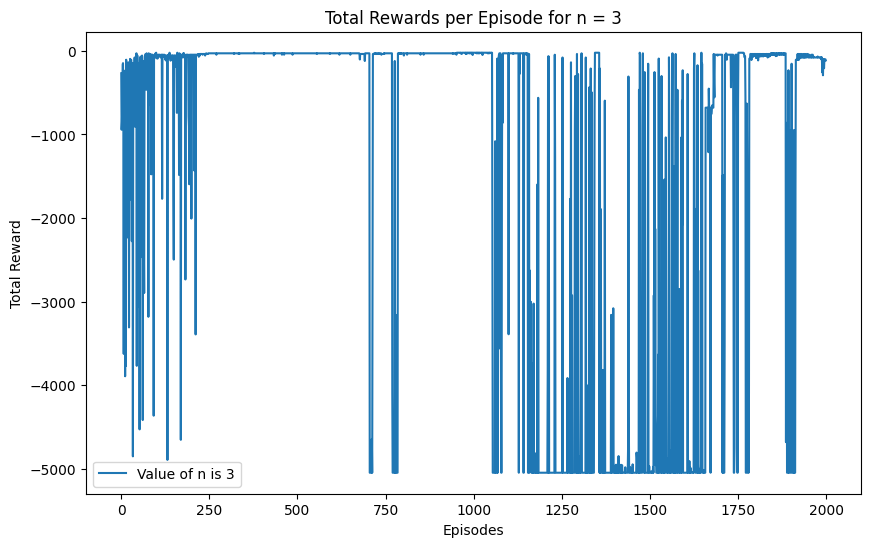

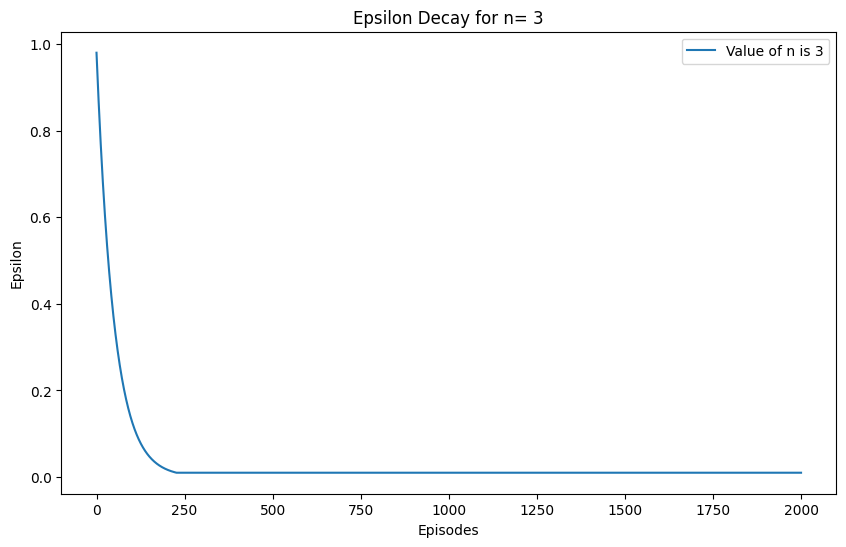

Evaluation for n is 3:
Greedy Evaluation Episode 1: Total Reward = -100
Action Grid:
→ ↑ . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -100
Action Grid:
→ ↑ . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -100
Action Grid:
→ ↑ . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -100
Action Grid:
→ ↑ . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -100
Action Grid:
→ ↑ . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -100
Action Grid:
→ ↑ . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -100
Action Grid:
→ ↑ . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode

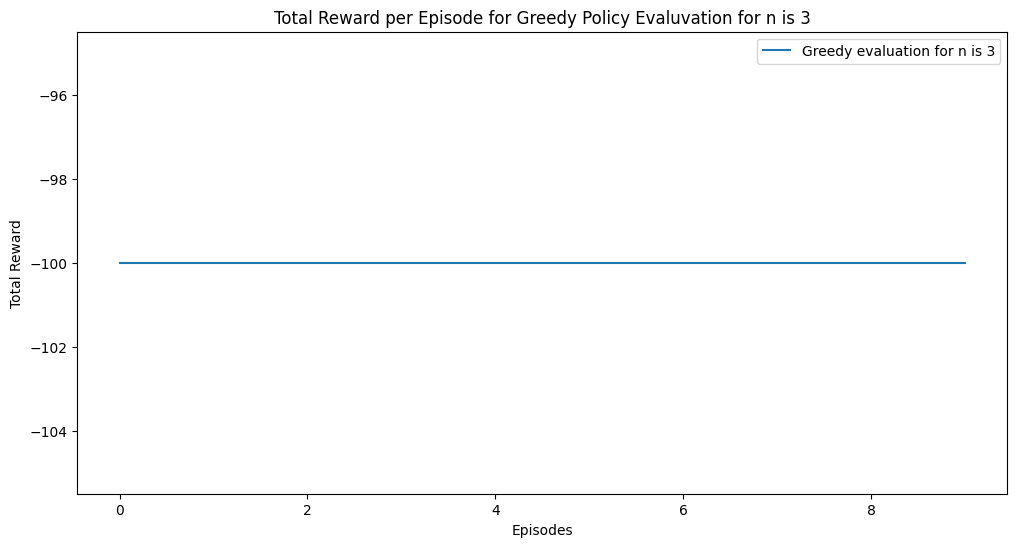

N value is -  4
Episode 100/2000, Total Reward: -136, Epsilon: 0.1326
Episode 200/2000, Total Reward: -351, Epsilon: 0.0176
Episode 300/2000, Total Reward: -3916, Epsilon: 0.0100
Episode 400/2000, Total Reward: 0, Epsilon: 0.0100
Episode 500/2000, Total Reward: -4095, Epsilon: 0.0100
Episode 600/2000, Total Reward: 0, Epsilon: 0.0100
Episode 700/2000, Total Reward: 0, Epsilon: 0.0100
Episode 800/2000, Total Reward: -3486, Epsilon: 0.0100
Episode 900/2000, Total Reward: -77, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -78, Epsilon: 0.0100
Episode 1100/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -4851, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -308, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -654, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -772, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 19

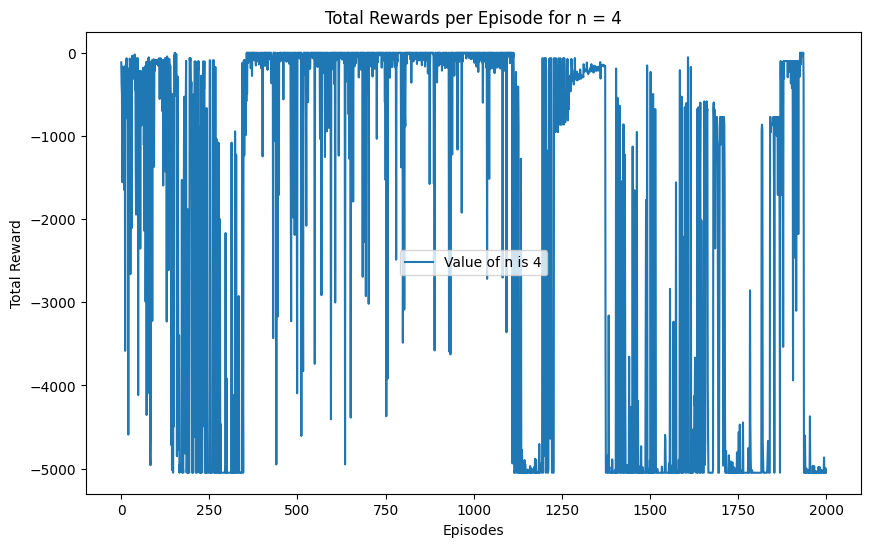

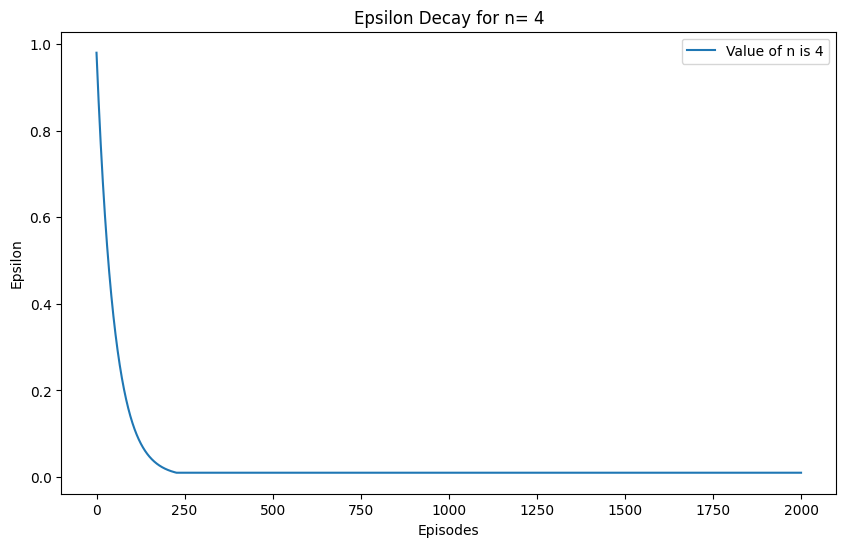

Evaluation for n is 4:
Greedy Evaluation Episode 1: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . ↘ ←
. → ↘ → ↑ ↑
. . . ↑ . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . ↘ ←
. → ↘ → ↑ ↑
. . . ↑ . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . ↘ ←
. → ↘ → ↑ ↑
. . . ↑ . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . ↘ ←
. → ↘ → ↑ ↑
. . . ↑ . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . ↘ ←
. → ↘ → ↑ ↑
. . . ↑ . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . ↘ ←
. → ↘ → ↑ ↑
. . . ↑ . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = -5050
Action Grid:
↓ . . . . .
↘ . . . ↘ ←
. → ↘ → ↑ ↑
. . . ↑ . .
. . . . . .
. . . . . .


Greedy Evaluation 

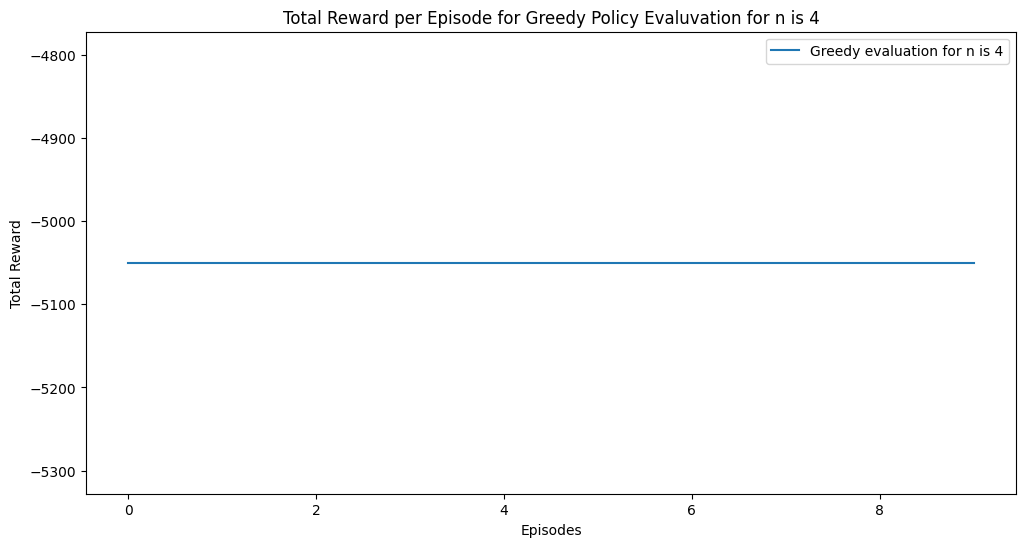

N value is -  5
Episode 100/2000, Total Reward: -55, Epsilon: 0.1326
Episode 200/2000, Total Reward: -1326, Epsilon: 0.0176
Episode 300/2000, Total Reward: -173, Epsilon: 0.0100
Episode 400/2000, Total Reward: -36, Epsilon: 0.0100
Episode 500/2000, Total Reward: -3682, Epsilon: 0.0100
Episode 600/2000, Total Reward: -231, Epsilon: 0.0100
Episode 700/2000, Total Reward: -193, Epsilon: 0.0100
Episode 800/2000, Total Reward: -135, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -55, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -127, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -4753, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -351, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -325, Epsilon: 0.0100
Episode 1500/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1600/2000, Total Reward: 0, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -679, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -990, Epsilon: 0.0100
Episode 

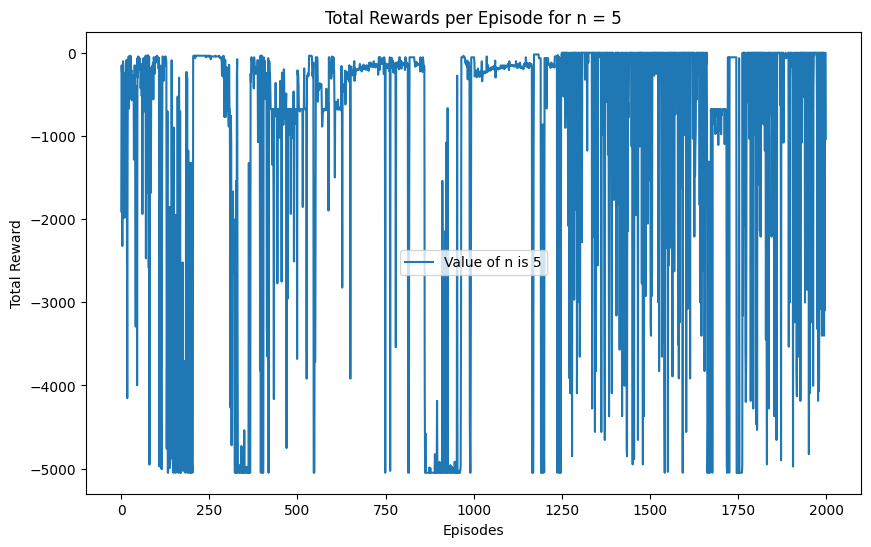

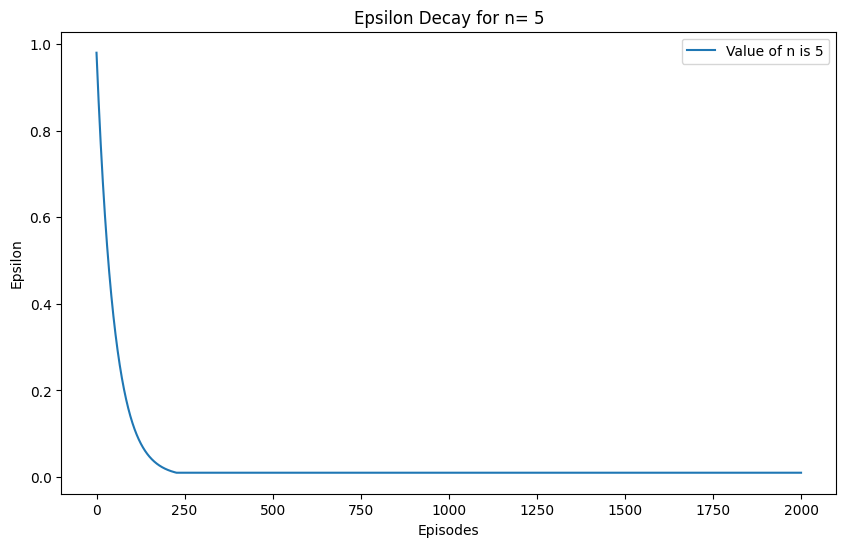

Evaluation for n is 5:
Greedy Evaluation Episode 1: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 2: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 3: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 4: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 5: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 6: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 7: Total Reward = 0
Action Grid:
← . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .
. . . . . .


Greedy Evaluation Episode 8: Total Reward = 0


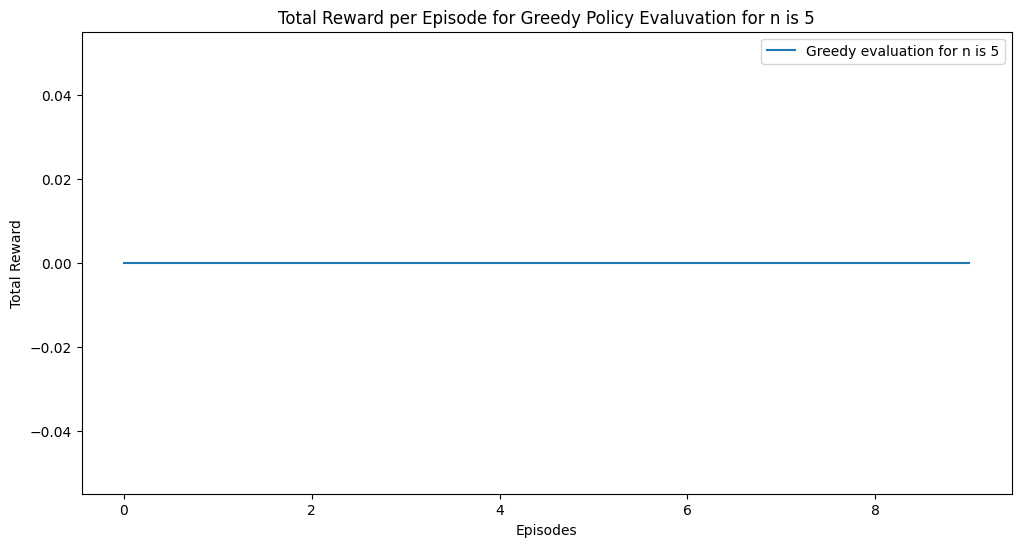

In [ ]:
env = GridWorld()
discount = 0.95
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.98
episodes = 2000
max_steps = 100
tryFordifferentN(env, discount, alpha, epsilon, epsilon_min, epsilon_decay, episodes, max_steps)

Best Model Found - <br>
Best Hyperparameter Values Found - discount = 0.95
alpha = 0.1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.98
episodes = 2000
max_steps = 100<br>
Most efficient n value - 2 <br>

Comparison of SARSA and Double Q learning with best hyperparameters

Referencing SARSA from part 2

In [7]:
# Epsilon-greedy function
def epsilon_greedy(Q, state, epsilon, num_actions):
    if random.uniform(0, 1) < epsilon:
        # Exploration: Choose a random action
        return random.randint(0, num_actions - 1)
    else:
        # Exploitation: Choose the action with the highest Q-value
        return np.argmax(Q[state[0] * 6 + state[1]])  # Convert 2D state to 1D


# SARSA approach implementation
def sarsaApproach(env, episodes, alpha, discount, epsilon, epsilon_min, epsilon_decay):
    # Initialize Q-table with random small values
    Q = np.random.uniform(low=0.00, high=0.02, size=(env.state_space, env.action_space.n))
    #zero initialize
    #Q = np.zeros((env.state_space, env.action_space.n))
    # Ensure terminal state (5,5) has Q-values of 0
    Q[5 * 6 + 5, :] = 0

    total_rewards = []
    epsilon_values = []

    # Track initial Q-table for later printing
    initial_Q = Q.copy()

    for episode in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)

        total_reward = 0
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)

            # Update Q-value using SARSA formula, except for terminal state
            if next_state != (5, 5):
                Q[state[0] * 6 + state[1], action] += alpha * (reward + discount * Q[next_state[0] * 6 + next_state[1], next_action] - Q[state[0] * 6 + state[1], action])

            state, action = next_state, next_action
            total_reward += reward

        #ensure terminal state Q-value is 0
        Q[5 * 6 + 5, :] = 0

        total_rewards.append(total_reward)

        # Epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return Q, initial_Q, total_rewards, epsilon_values



Episode 100/2000, Total Reward: -3081, Epsilon: 0.1326
Episode 200/2000, Total Reward: -4882, Epsilon: 0.0176
Episode 300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 700/2000, Total Reward: -3321, Epsilon: 0.0100
Episode 800/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 900/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1000/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1100/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1200/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1300/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1400/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1500/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1600/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1700/2000, Total Reward: -5050, Epsilon: 0.0100
Episode 1800/2000, Total Reward: -15, Epsilon: 0.0100
Epi

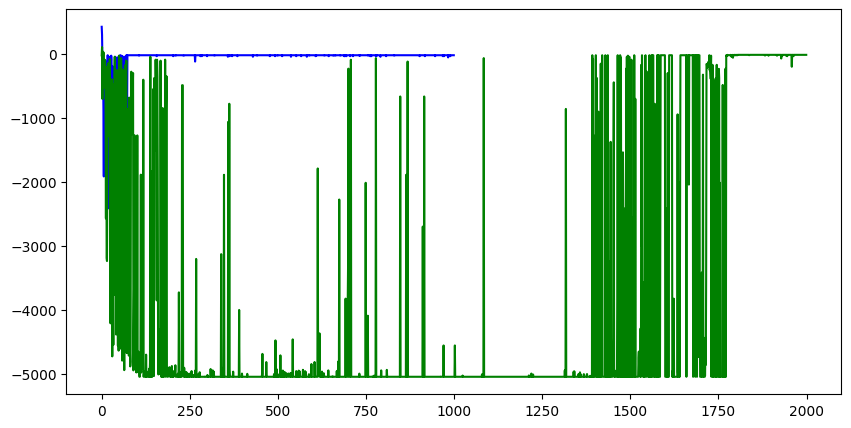

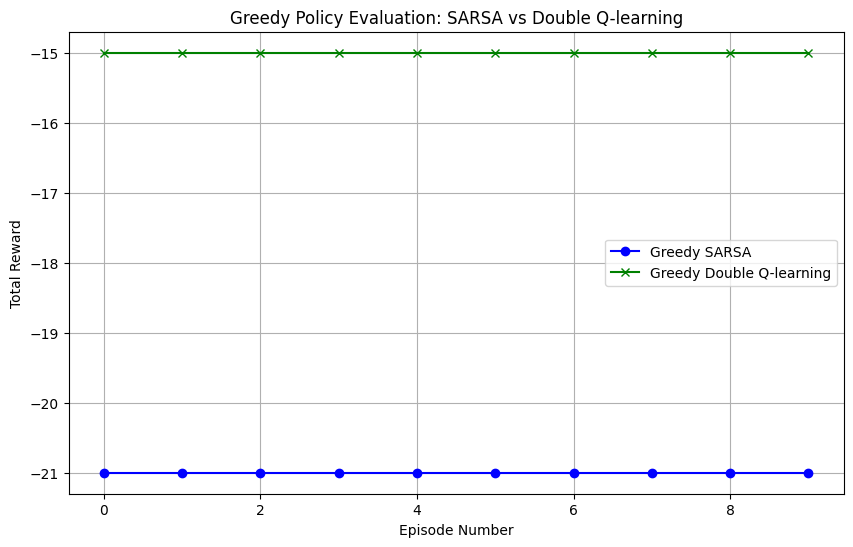

In [20]:
# Running the SARSA approach
env_sarsa = GridWorld()
episodes_sarsa = 1000
alpha_sarsa = 0.222
discount_sarsa = 0.999
epsilon_sarsa = 1
epsilon_min_sarsa = 0.0199
epsilon_decay_sarsa = 0.95


Q_values_sarsa, initial_Q_values_sarsa, total_rewards_sarsa, epsilon_values_sarsa = sarsaApproach(env_sarsa, episodes_sarsa, alpha_sarsa, discount_sarsa, epsilon_sarsa, epsilon_min_sarsa, epsilon_decay_sarsa)


#Running n step Double Q learning
env_double = GridWorld()
discount_double = 0.95
alpha_double = 0.1
epsilon_double = 1.0
epsilon_min_double = 0.01
epsilon_decay_double = 0.98
episodes_double = 2000
n_double = 2
max_steps_double = 100


initial_Q1_double, initial_Q2_double, Q1_double, Q2_double, total_rewards_double, epsilon_values_double = nstep_double_q_learning(env_double, episodes_double, alpha_double, discount_double, epsilon_double, epsilon_min_double, epsilon_decay_double, n_double, max_steps_double)

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(range(episodes_sarsa), total_rewards_sarsa, label="SARSA", color="blue")
plt.plot(range(episodes_double), total_rewards_double, label="n-step Double Q-learning", color="green")

## Greedy policy evaluation
greedy_rewards_sarsa = []
for episode in range(10):
    state = env_sarsa.reset()
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(Q_values_sarsa[state[0] * 6 + state[1]])  # Choose greedy action
        next_state, reward, done, _, _ = env_sarsa.step(action)
        total_reward += reward
        state = next_state

        # Check if the agent has reached the goal state (5,5)
        if state == (5, 5):
            done = True  # Set done to True when the goal state is reached

    greedy_rewards_sarsa.append(total_reward)

# Evaluation of performance with greedy actions
rewards_greedy_double = []
action_grids = []
for episode_number in range(10):
    state = env_double.reset()
    done = False
    total_reward = 0
    actions_taken = {}
    step = 0
    while not done and step < max_steps_double:
        state_index = s_index(state, env_double.grid_size)
        q_values = Q1_double[state_index, :] + Q2_double[state_index, :]
        action = np.argmax(q_values)
        actions_taken[state] = action
        next_state, reward, done, _, _ = env_double.step(action)
        total_reward += reward
        state = next_state
        step += 1
    rewards_greedy_double.append(total_reward)

plt.figure(figsize=(10, 6))
plt.plot(greedy_rewards_sarsa, label="Greedy SARSA", color='blue', marker='o')
plt.plot(rewards_greedy_double, label="Greedy Double Q-learning", color='green', marker='x')
plt.xlabel('Episode Number')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation: SARSA vs Double Q-learning')
plt.legend()
plt.grid(True)
plt.show()